# Devign Function Call Pattern Analysis

In [100]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import random

from collections import Counter
from pathlib import Path
from typing import List, Tuple
from tqdm import tqdm


from scipy.stats import pointbiserialr

## Function Call Distribution

In [101]:
DEVIGN_DIR = Path('raw_data/devign')
ACTION_LIST = [
    "summarize_code()",
    "list_variables()",
    "list_functions()",
    "list_freed_variables()",
    "list_null_assigned_variables()",
    "check_pattern(buffer_overflow)",
    "check_pattern('buffer_overflow')",
    "check_pattern(null_deref)",
    "check_pattern('null_deref')",
    "check_pattern(use_after_free)",
    "check_pattern('use_after_free')",
    "positive_alarm(<int line_number>)",
    "negative_alarm()",
]
func_cnt_dict = {}

def find_action(func_call):
    for action in ACTION_LIST:
        if action in func_call:
            if action == "check_pattern(buffer_overflow)" or action == "check_pattern('buffer_overflow')":
                return "check_pattern(buffer_overflow)"
            if action == "check_pattern(null_deref)" or action == "check_pattern('null_deref')":
                return "check_pattern(null_deref)"
            if action == "check_pattern(use_after_free)" or action == "check_pattern('use_after_free')":
                return "check_pattern(use_after_free)"
            return action
    return None

In [100]:
for model_dir in tqdm(os.listdir(DEVIGN_DIR)):
    if not os.path.isdir(DEVIGN_DIR / model_dir):
        continue
    
    model_id = model_dir.split('-')[0]
    for split_dir in os.listdir(DEVIGN_DIR / model_dir):
        if not os.path.isdir(DEVIGN_DIR / model_dir / split_dir):
            continue
        for file in os.listdir(DEVIGN_DIR / model_dir / split_dir):
            assert 'json' in file
            episode_id = int(file.split('_')[1].split('.')[0])
            with open(DEVIGN_DIR / model_dir / split_dir / file) as f:
                data = json.load(f)
                if 'trajectory' not in data or type(data['trajectory']) != dict:
                    continue # zero occurrence
                trajectory = data['trajectory']
                if 'done' not in trajectory or not trajectory['done']:
                    continue # zero occurrence
                
                for action_info in trajectory["state"]["processed_actions"]:
                    func_call, is_valid = action_info[0], action_info[1]
                    if "positive_alarm" in func_call or "negative_alarm" in func_call:
                        continue
                    action = find_action(func_call)
                    if not action: # action not found
                        continue
                    if action in func_cnt_dict:
                        if is_valid == "VALID":
                            func_cnt_dict[action]["valid"] += 1
                        else:
                            func_cnt_dict[action]["invalid"] += 1
                    else:
                        func_cnt_dict[action] = {"valid": 0, "invalid": 0}
                        if is_valid == "VALID":
                            func_cnt_dict[action]["valid"] += 1
                        else:
                            func_cnt_dict[action]["invalid"] += 1



100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


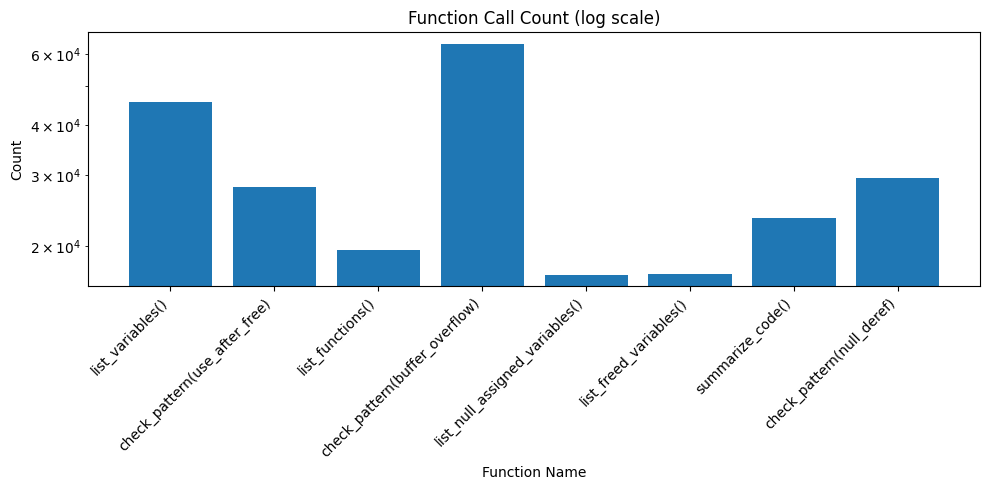

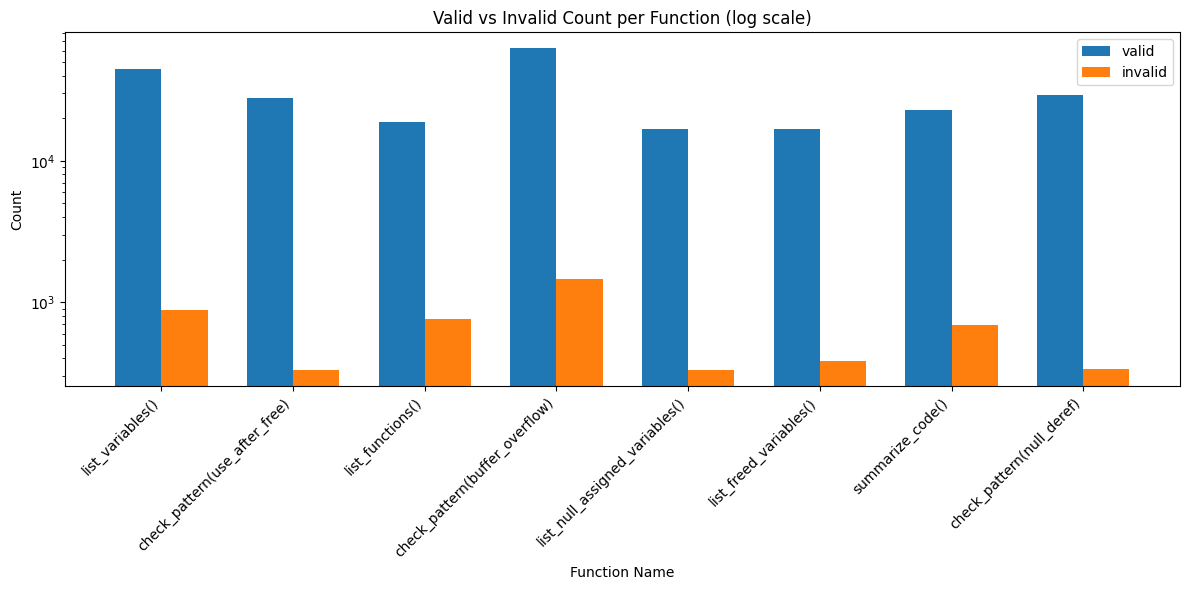

In [101]:
def plot_dict(data, split=False):
    # 함수 이름과 카운트를 분리
    keys = list(data.keys())
    if not split:
        values = [e["valid"] + e["invalid"] for e in data.values()]
    

    # 그래프 크기 설정
    plt.figure(figsize=(10, 5))

    # 막대그래프 그리기
    plt.bar(keys, values)

    # 라벨과 제목 설정
    plt.xlabel("Function Name")
    plt.ylabel("Count")
    plt.title("Function Call Count (log scale)")

    # x축 라벨이 겹치지 않도록 회전
    plt.xticks(rotation=45, ha="right")
    plt.yscale("log")
    # 그래프 표시
    plt.tight_layout()
    plt.show()

def plot_valid_invalid(data):
    func_names = list(data.keys())
    valid_counts = [data[f]["valid"] for f in func_names]
    invalid_counts = [data[f]["invalid"] for f in func_names]

    x = np.arange(len(func_names))  # x축 위치
    width = 0.35  # 막대 너비

    plt.figure(figsize=(12, 6))

    # valid / invalid 막대를 나란히 배치
    plt.bar(x - width/2, valid_counts, width, label="valid")
    plt.bar(x + width/2, invalid_counts, width, label="invalid")

    plt.xticks(x, func_names, rotation=45, ha="right")
    plt.xlabel("Function Name")
    plt.yscale("log")
    plt.ylabel("Count")
    plt.title("Valid vs Invalid Count per Function (log scale)")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_dict(func_cnt_dict)
plot_valid_invalid(func_cnt_dict)

## 4-gram Analysis without Validity

In [102]:
def extract_function_call_sequence(action_list):
    sequence = []
    for action_info in action_list:
        func_call = action_info[0]
        if "positive_alarm" in func_call or "negative_alarm" in func_call:
            continue
        action = find_action(func_call)
        if action:
            sequence.append(action)
    return sequence

def extract_function_call_sequence_with_validity(action_list):
    sequence = []
    for action_info in action_list:
        func_call, is_valid = action_info[0], action_info[1]
        if "positive_alarm" in func_call or "negative_alarm" in func_call:
            continue
        action = find_action(func_call)
        if action:
            if is_valid == "VALID":
                action = action + "_valid"
            else:
                action = action + "_invalid"
            sequence.append(action)
    return sequence


def get_n_grams(sequence, n=4):
    n_grams = []
    for i in range(len(sequence) - (n-1)):
        n_gram = tuple(sequence[i:i+n])
        n_grams.append(n_gram)
    return n_grams


def get_n_grams_for_all_executions_in_directory(directory_path, n=4, with_validity=False):
    all_n_grams = []

    for json_file in directory_path.glob("*.json"):
        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)

            if 'trajectory' not in data or type(data['trajectory']) != dict:
                continue # zero occurrence
            trajectory = data['trajectory']
            if 'done' not in trajectory or not trajectory['done']:
                continue # zero occurrence
            if not "reward" in trajectory:
                continue
            if not with_validity:
                sequence = extract_function_call_sequence(trajectory["state"]["processed_actions"])
            if with_validity:
                sequence = extract_function_call_sequence_with_validity(trajectory["state"]["processed_actions"])
            # print(sequence)
            n_grams = get_n_grams(sequence, n)

            # for four_gram in n_grams:
            #     if ' -> '.join(four_gram) == "check_pattern(buffer_overflow)_valid -> check_pattern(buffer_overflow)_invalid -> check_pattern(buffer_overflow)_invalid -> check_pattern(buffer_overflow)_valid":
            #         print(f"Found in {json_file}")
            #         print(n_grams)

            
            all_n_grams.extend(n_grams)
        except Exception as e:
            print(f"Error processing {json_file}: {e}")

    return all_n_grams

def get_n_grams_for_successful_executions_in_directory(directory_path, n=4, with_validity=False):
    all_n_grams = []


    for json_file in directory_path.glob("*.json"):
        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            if 'trajectory' not in data or type(data['trajectory']) != dict:
                continue # zero occurrence
            trajectory = data['trajectory']
            if 'done' not in trajectory or not trajectory['done']:
                continue # zero occurrence
                
            if not "reward" in trajectory or trajectory["reward"] == 0:
                continue
            if not with_validity:
                sequence = extract_function_call_sequence(trajectory["state"]["processed_actions"])
            if with_validity:
                sequence = extract_function_call_sequence_with_validity(trajectory["state"]["processed_actions"])
            n_grams = get_n_grams(sequence, n)
            all_n_grams.extend(n_grams)
        except Exception as e:
            print(f"Error processing {json_file}: {e}")

    return all_n_grams

def get_n_grams_for_failing_executions_in_directory(directory_path, n=4, with_validity=False):
    all_n_grams = []


    for json_file in directory_path.glob("*.json"):
        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            if 'trajectory' not in data or type(data['trajectory']) != dict:
                continue # zero occurrence
            trajectory = data['trajectory']
            if 'done' not in trajectory or not trajectory['done']:
                continue # zero occurrence
                
            if not "reward" in trajectory or trajectory["reward"] == 1:
                continue
            
            if not with_validity:
                sequence = extract_function_call_sequence(trajectory["state"]["processed_actions"])
            if with_validity:
                sequence = extract_function_call_sequence_with_validity(trajectory["state"]["processed_actions"])
            n_grams = get_n_grams(sequence, n)
            all_n_grams.extend(n_grams)
        except Exception as e:
            print(f"Error processing {json_file}: {e}")

    return all_n_grams

def get_n_grams_for_blanced_executions_in_directory(directory_path, n=4, with_validity=False):
    all_ngrams = []
    success_ngrams = []
    fail_ngrams = []

    success_bug_names = []
    fail_bug_names = []

    for json_file in os.listdir(directory_path):
        with open(os.path.join(directory_path, json_file), 'r', encoding='utf-8') as f:
            data = json.load(f)

        if 'trajectory' not in data or type(data['trajectory']) != dict:
            continue # zero occurrence
        trajectory = data['trajectory']
        if 'done' not in trajectory or not trajectory['done']:
            continue # zero occurrence
            

        execution_success = trajectory["reward"] == 1
        if execution_success:
            success_bug_names.append(json_file)
        else:
            fail_bug_names.append(json_file)
        # print(success_bug_names)

    random.seed(42)
    if len(success_bug_names) > len(fail_bug_names):
        sampled_success = random.sample(success_bug_names, len(fail_bug_names))
        sampled_fail = fail_bug_names
    else:
        sampled_success = success_bug_names
        sampled_fail = random.sample(fail_bug_names, len(success_bug_names))

    for json_file in sampled_fail:
        with open(os.path.join(directory_path, json_file), 'r') as f:
            data = json.load(f)

        trajectory = data['trajectory']
        if not with_validity:
            sequence = extract_function_call_sequence(trajectory["state"]["processed_actions"])
        if with_validity:
            sequence = extract_function_call_sequence_with_validity(trajectory["state"]["processed_actions"])
        ngrams = get_n_grams(sequence, n)
        all_ngrams.extend(ngrams)
        fail_ngrams.extend(ngrams)
    
    for json_file in sampled_success:
        with open(os.path.join(directory_path, json_file), 'r') as f:
            data = json.load(f)

        trajectory = data['trajectory']
        if not with_validity:
            sequence = extract_function_call_sequence(trajectory["state"]["processed_actions"])
        if with_validity:
            sequence = extract_function_call_sequence_with_validity(trajectory["state"]["processed_actions"])
        ngrams = get_n_grams(sequence, n)
        all_ngrams.extend(ngrams)
        success_ngrams.extend(ngrams)

    return all_ngrams, success_ngrams, fail_ngrams


In [103]:
def get_n_grams_for_all_executions(model, n=4, with_validity=False):
    all_n_grams = []
    for split_dir in os.listdir(DEVIGN_DIR / model):
        if not os.path.isdir(DEVIGN_DIR / model / split_dir):
            continue
            
        path = DEVIGN_DIR / model / split_dir

        if path.exists():
            n_grams = get_n_grams_for_all_executions_in_directory(path, n, with_validity=with_validity)
            all_n_grams.extend(n_grams)
        else:
            print(f"Warning: {file} does not exist")

    print(f"\nTotal {n}-grams collected: {len(all_n_grams)}")

    return all_n_grams

def get_n_grams_for_success_executions(model, n=4, with_validity=False):
    all_n_grams = []
    for split_dir in os.listdir(DEVIGN_DIR / model):
        if not os.path.isdir(DEVIGN_DIR / model / split_dir):
            continue
            
        path = DEVIGN_DIR / model / split_dir

        if path.exists():
            n_grams = get_n_grams_for_successful_executions_in_directory(path, n, with_validity=with_validity)
            all_n_grams.extend(n_grams)
        else:
            print(f"Warning: {path} does not exist")

    print(f"\nTotal {n}-grams collected: {len(all_n_grams)}")

    return all_n_grams

def get_n_grams_for_fail_executions(model, n=4, with_validity=False):
    all_n_grams = []
    for split_dir in os.listdir(DEVIGN_DIR / model):
        if not os.path.isdir(DEVIGN_DIR / model / split_dir):
            continue
            
        path = DEVIGN_DIR / model / split_dir

        if path.exists():
            n_grams = get_n_grams_for_failing_executions_in_directory(path, n, with_validity=with_validity)
            all_n_grams.extend(n_grams)
        else:
            print(f"Warning: {path} does not exist")

    print(f"\nTotal {n}-grams collected: {len(all_n_grams)}")

    return all_n_grams

def get_ngrams_for_executions(model, n=4, with_validity=False):
    # Process all directories

    all_ngrams = []
    all_success_ngrams = []
    all_fail_ngrams = []

    for split_dir in os.listdir(DEVIGN_DIR / model):
        if not os.path.isdir(DEVIGN_DIR / model / split_dir):
            continue
            
        path = DEVIGN_DIR / model / split_dir

        if path.exists():
            ngrams, success_ngrams, fail_ngrams = get_n_grams_for_blanced_executions_in_directory(path, n, with_validity)
            all_ngrams.extend(ngrams)
            all_success_ngrams.extend(success_ngrams)
            all_fail_ngrams.extend(fail_ngrams)
        else:
            print(f"Warning: {path} does not exist")

    print(f"\nTotal {n}-grams collected: {len(all_ngrams)}")
    print(f"\nTotal {n}-grams from successful executions: {len(all_success_ngrams)}")
    print(f"\nTotal {n}-grams from failed executions: {len(all_fail_ngrams)}")

    return all_ngrams, all_success_ngrams, all_fail_ngrams

In [21]:
models = ['gemma3-4b', 'llama3_1-8b', 'llama3_2-3b', 'mistral-7b']

for model in models:
    all_n_grams = get_n_grams_for_all_executions(model, n)

    all_counter = Counter(all_n_grams)

    results = []
    for n_gram, count in all_counter.most_common():
        results.append({
            f'{n}gram': n_gram,
            'frequency': count
        })
    
    df = pd.DataFrame(results)
    os.makedirs(f"./{n}gram_frequency/devign/without_validity/all_executions", exist_ok=True)
    output_file = f"./{n}gram_frequency/devign/without_validity/all_executions/{model}_{n}gram_frequencies.csv"
    df.to_csv(output_file, index=False)
    print(f"Saved {output_file} with {len(df)} unique {n}-gram")


Total 3-grams collected: 7122
Saved ./3gram_frequency/devign/without_validity/all_executions/gemma3-4b_3gram_frequencies.csv with 231 unique 3-gram

Total 3-grams collected: 68587
Saved ./3gram_frequency/devign/without_validity/all_executions/llama3_1-8b_3gram_frequencies.csv with 481 unique 3-gram

Total 3-grams collected: 33205
Saved ./3gram_frequency/devign/without_validity/all_executions/llama3_2-3b_3gram_frequencies.csv with 412 unique 3-gram

Total 3-grams collected: 74666
Saved ./3gram_frequency/devign/without_validity/all_executions/mistral-7b_3gram_frequencies.csv with 500 unique 3-gram


In [22]:
models = ['gemma3-4b', 'llama3_1-8b', 'llama3_2-3b', 'mistral-7b']

for model in models:
    all_n_grams = get_n_grams_for_success_executions(model, n)

    all_counter = Counter(all_n_grams)

    results = []
    for four_gram, count in all_counter.most_common():
        results.append({
            f'{n}gram': four_gram,
            'frequency': count
        })
    
    df = pd.DataFrame(results)
    os.makedirs(f"./{n}gram_frequency/devign/without_validity/success_executions", exist_ok=True)
    output_file = f"./{n}gram_frequency/devign/without_validity/success_executions/{model}_{n}gram_frequencies.csv"
    df.to_csv(output_file, index=False)
    print(f"Saved {output_file} with {len(df)} unique {n}-gram")


Total 3-grams collected: 3223
Saved ./3gram_frequency/devign/without_validity/success_executions/gemma3-4b_3gram_frequencies.csv with 181 unique 3-gram

Total 3-grams collected: 33510
Saved ./3gram_frequency/devign/without_validity/success_executions/llama3_1-8b_3gram_frequencies.csv with 459 unique 3-gram

Total 3-grams collected: 14998
Saved ./3gram_frequency/devign/without_validity/success_executions/llama3_2-3b_3gram_frequencies.csv with 395 unique 3-gram

Total 3-grams collected: 38799
Saved ./3gram_frequency/devign/without_validity/success_executions/mistral-7b_3gram_frequencies.csv with 491 unique 3-gram


In [24]:
models = ['gemma3-4b', 'llama3_1-8b', 'llama3_2-3b', 'mistral-7b']

for model in models:
    all_n_grams = get_n_grams_for_fail_executions(model, n)

    all_counter = Counter(all_n_grams)

    results = []
    for four_gram, count in all_counter.most_common():
        results.append({
            f'{n}gram': four_gram,
            'frequency': count
        })
    
    df = pd.DataFrame(results)
    os.makedirs(f"./{n}gram_frequency/devign/without_validity/fail_executions", exist_ok=True)
    output_file = f"./{n}gram_frequency/devign/without_validity/fail_executions/{model}_{n}gram_frequencies.csv"
    df.to_csv(output_file, index=False)
    print(f"Saved {output_file} with {len(df)} unique {n}-gram")


Total 3-grams collected: 3899
Saved ./3gram_frequency/devign/without_validity/fail_executions/gemma3-4b_3gram_frequencies.csv with 197 unique 3-gram

Total 3-grams collected: 35077
Saved ./3gram_frequency/devign/without_validity/fail_executions/llama3_1-8b_3gram_frequencies.csv with 455 unique 3-gram

Total 3-grams collected: 18207
Saved ./3gram_frequency/devign/without_validity/fail_executions/llama3_2-3b_3gram_frequencies.csv with 406 unique 3-gram

Total 3-grams collected: 35867
Saved ./3gram_frequency/devign/without_validity/fail_executions/mistral-7b_3gram_frequencies.csv with 489 unique 3-gram


### Top-10 frequent action sequences


Model: gemma3-4b


Total 3-grams collected: 7122

Total 3-grams collected: 3223

Total 3-grams collected: 3899
                                                             pattern  all_executions  success_executions  fail_executions success_ratio fail_ratio
check_use_after_free -> check_use_after_free -> check_use_after_free             643                 260              383         40.4%      59.6%
              list_vars -> check_buffer_overflow -> check_null_deref             481                 209              272         43.5%      56.5%
   check_buffer_overflow -> check_null_deref -> check_use_after_free             479                 198              281         41.3%      58.7%
   check_buffer_overflow -> check_use_after_free -> check_null_deref             354                 184              170         52.0%      48.0%
              check_buffer_overflow -> check_null_deref -> summarize             347                 159              188         45.8%      54.2%
   che

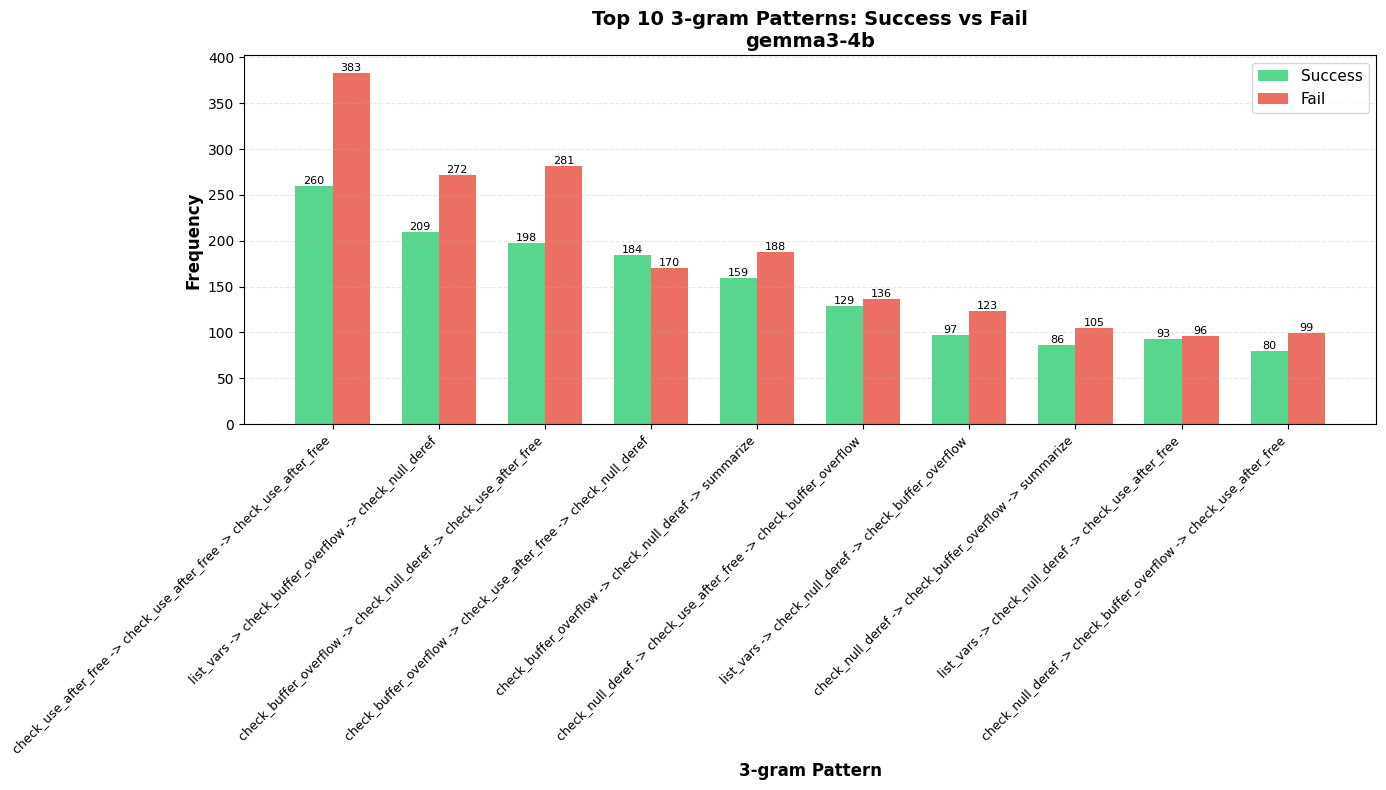


Model: llama3_1-8b


Total 3-grams collected: 68587

Total 3-grams collected: 33510

Total 3-grams collected: 35077
                                                                pattern  all_executions  success_executions  fail_executions success_ratio fail_ratio
                        check_buffer_overflow -> summarize -> list_vars            1629                 787              842         48.3%      51.7%
check_buffer_overflow -> check_buffer_overflow -> check_buffer_overflow            1463                 813              650         55.6%      44.4%
               check_null_deref -> check_null_deref -> check_null_deref            1231                 719              512         58.4%      41.6%
                                   summarize -> list_vars -> list_funcs            1091                 519              572         47.6%      52.4%
               list_funcs -> list_freed_vars -> list_null_assigned_vars             943                 418              525         

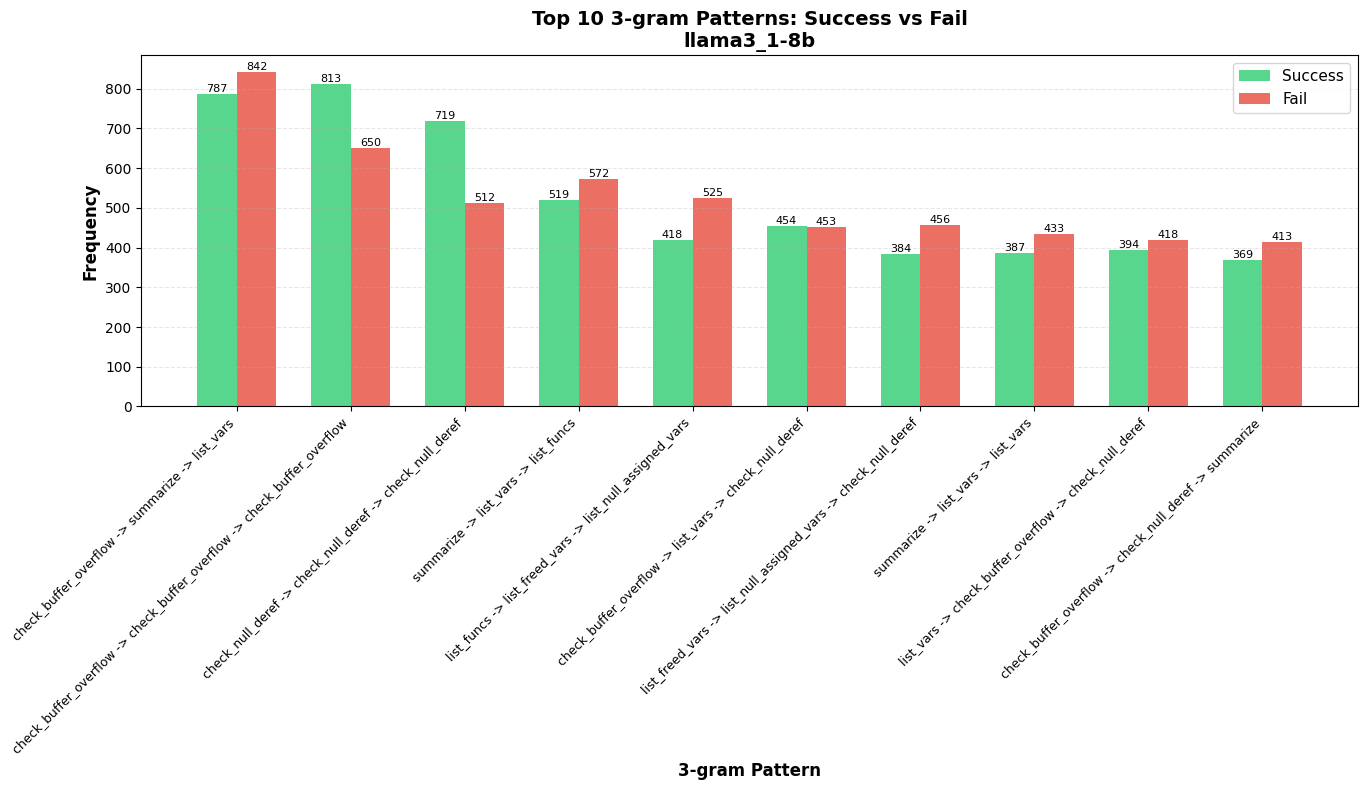


Model: llama3_2-3b


Total 3-grams collected: 33205

Total 3-grams collected: 14998

Total 3-grams collected: 18207
                                                          pattern  all_executions  success_executions  fail_executions success_ratio fail_ratio
           list_vars -> check_buffer_overflow -> check_null_deref             582                 268              314         46.0%      54.0%
       list_vars -> check_buffer_overflow -> check_use_after_free             576                 279              297         48.4%      51.6%
            list_vars -> check_buffer_overflow -> list_freed_vars             547                 247              300         45.2%      54.8%
           check_buffer_overflow -> list_vars -> check_null_deref             535                 240              295         44.9%      55.1%
check_buffer_overflow -> check_null_deref -> check_use_after_free             530                 244              286         46.0%      54.0%
       check_buffer

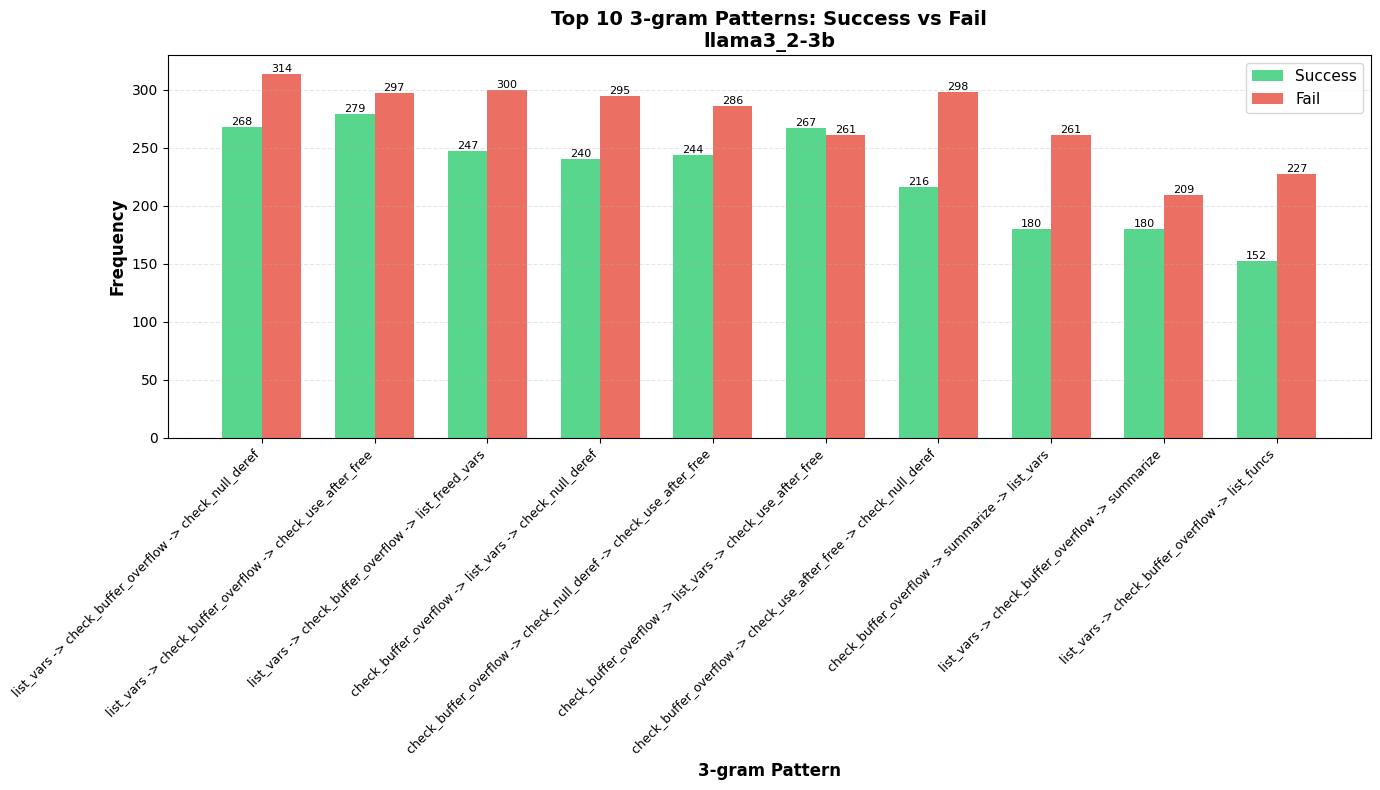


Model: mistral-7b


Total 3-grams collected: 74666

Total 3-grams collected: 38799

Total 3-grams collected: 35867
                                                                pattern  all_executions  success_executions  fail_executions success_ratio fail_ratio
check_buffer_overflow -> check_buffer_overflow -> check_buffer_overflow           15191                8305             6886         54.7%      45.3%
                                    list_vars -> list_vars -> list_vars            4229                2277             1952         53.8%      46.2%
   check_use_after_free -> check_use_after_free -> check_use_after_free            3374                1746             1628         51.7%      48.3%
            list_vars -> check_buffer_overflow -> check_buffer_overflow            2046                1128              918         55.1%      44.9%
                       list_vars -> list_funcs -> check_buffer_overflow            1422                 675              747         4

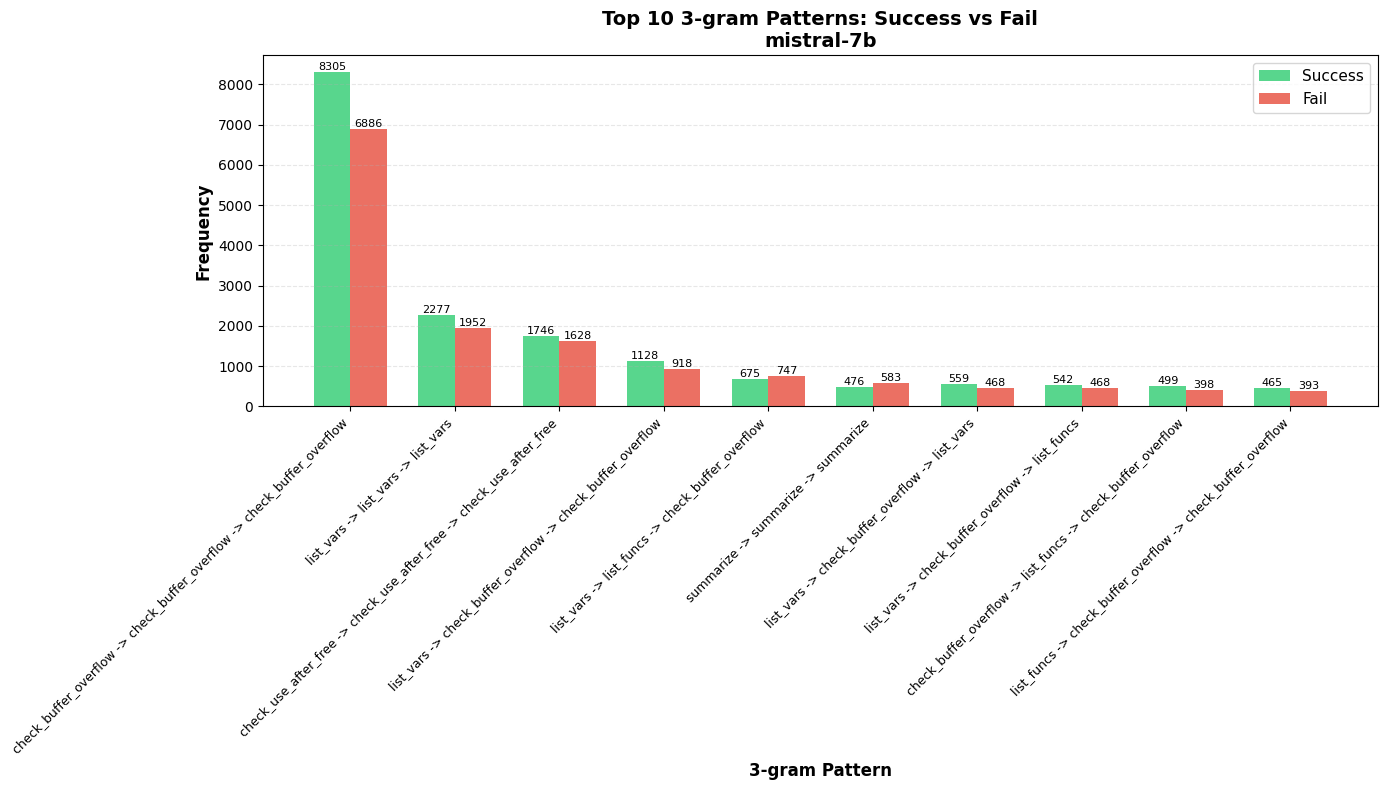

In [35]:
# Compare top 10 most frequent 4-grams in all executions vs success/fail executions
name_mapping = {
    "summarize_code()": "summarize",
    "list_variables()": "list_vars",
    "list_functions()": "list_funcs",
    "list_freed_variables()": "list_freed_vars",
    "list_null_assigned_variables()": "list_null_assigned_vars",
    "check_pattern(buffer_overflow)": "check_buffer_overflow",
    "check_pattern(null_deref)": "check_null_deref",
    "check_pattern(use_after_free)": "check_use_after_free",
}


def shorten_pattern(pattern_tuple):
    """Convert long function names to short versions"""
    return ' -> '.join([name_mapping.get(func, func) for func in pattern_tuple])

# For each benchmark and model combination
models = ['gemma3-4b', 'llama3_1-8b', 'llama3_2-3b', 'mistral-7b']

for model in models:
    print(f"\n{'='*100}")
    print(f"Model: {model}")
    print(f"{'='*100}\n")
    
    # Load the three counters
    all_n_grams = get_n_grams_for_all_executions(model, n)
    success_n_grams = get_n_grams_for_success_executions(model, n)
    fail_n_grams = get_n_grams_for_fail_executions(model, n)
    
    all_counter = Counter(all_n_grams)
    success_counter = Counter(success_n_grams)
    fail_counter = Counter(fail_n_grams)
    
    # Get top 10 from all executions
    top_10_patterns = [pattern for pattern, count in all_counter.most_common(10)]
    
    # Create comparison table
    comparison_data = []
    for pattern in top_10_patterns:
        all_count = all_counter[pattern]
        success_count = success_counter[pattern]
        fail_count = fail_counter[pattern]
        
        comparison_data.append({
            'pattern': shorten_pattern(pattern),
            'all_executions': all_count,
            'success_executions': success_count,
            'fail_executions': fail_count,
            'success_ratio': f"{success_count/all_count*100:.1f}%" if all_count > 0 else "0%",
            'fail_ratio': f"{fail_count/all_count*100:.1f}%" if all_count > 0 else "0%"
        })
    
    # Display as DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    print()
    
    # Create bar chart
    fig, ax = plt.subplots(figsize=(14, 8))
    
    patterns = comparison_df['pattern'].tolist()
    success_counts = comparison_df['success_executions'].tolist()
    fail_counts = comparison_df['fail_executions'].tolist()
    
    x = np.arange(len(patterns))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, success_counts, width, label='Success', color='#2ecc71', alpha=0.8)
    bars2 = ax.bar(x + width/2, fail_counts, width, label='Fail', color='#e74c3c', alpha=0.8)
    
    ax.set_xlabel(f'{n}-gram Pattern', fontsize=12, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax.set_title(f'Top 10 {n}-gram Patterns: Success vs Fail\n{model}', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(patterns, rotation=45, ha='right', fontsize=9)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}',
                        ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()


Model: gemma3-4b


Total 4-grams collected: 3762

Total 4-grams collected: 1692

Total 4-grams collected: 2070


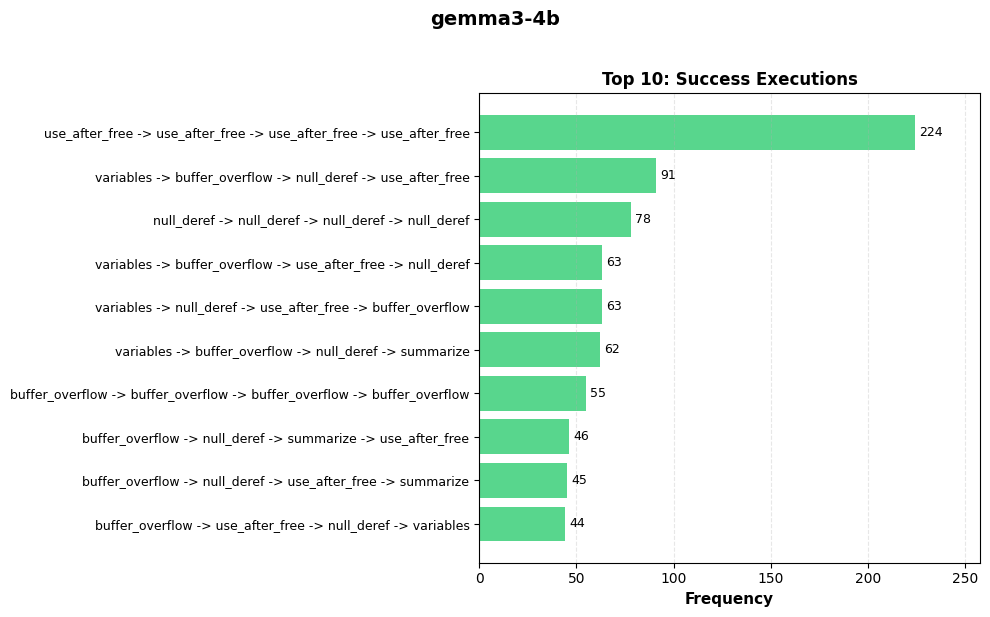


Model: llama3_1-8b


Total 4-grams collected: 60551

Total 4-grams collected: 29663

Total 4-grams collected: 30888


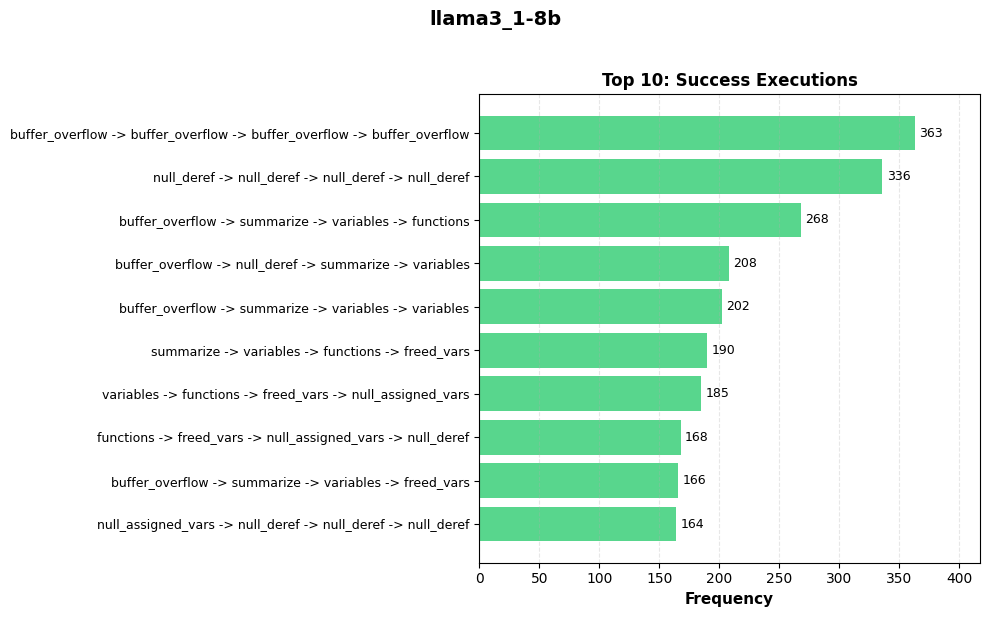


Model: llama3_2-3b


Total 4-grams collected: 25771

Total 4-grams collected: 11643

Total 4-grams collected: 14128


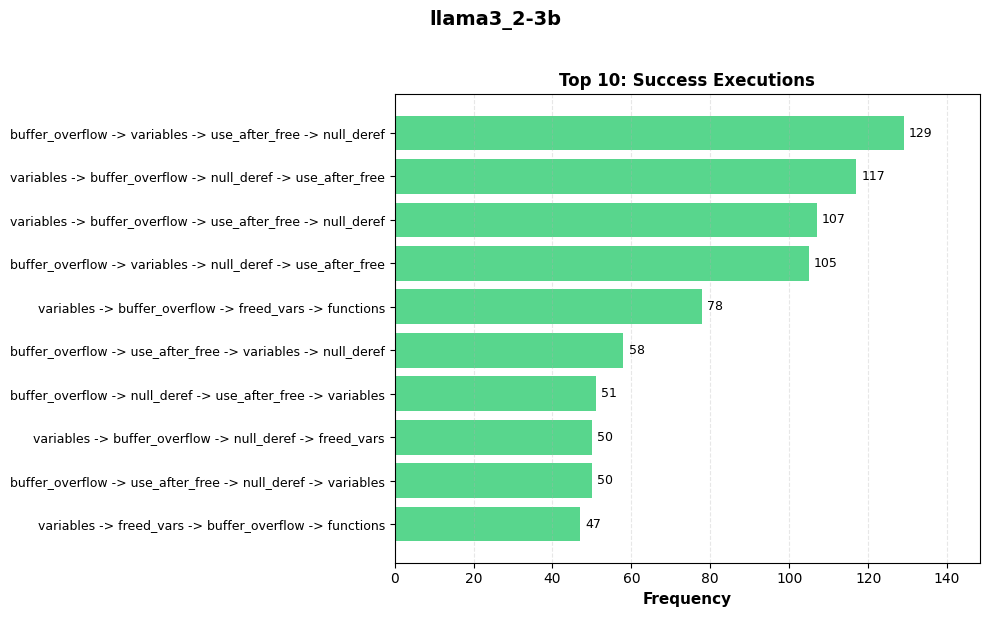


Model: mistral-7b


Total 4-grams collected: 66709

Total 4-grams collected: 34718

Total 4-grams collected: 31991


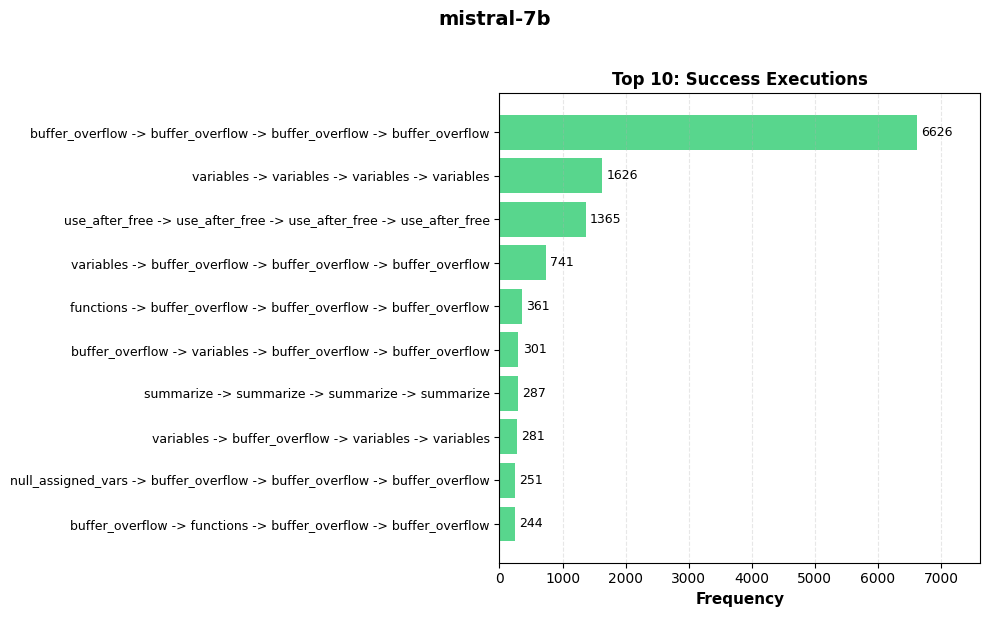

In [145]:
# Visualize Top 10 patterns separately for all/success/fail executions
n=4
for model in models:
    print(f"\n{'='*100}")
    print(f"Model: {model}")
    print(f"{'='*100}\n")
    
    # Load the three counters
    all_n_grams = get_n_grams_for_all_executions(model, n)
    success_n_grams = get_n_grams_for_success_executions(model, n)
    fail_n_grams = get_n_grams_for_fail_executions(model, n)
    
    all_counter = Counter(all_n_grams)
    success_counter = Counter(success_n_grams)
    fail_counter = Counter(fail_n_grams)
    
    # Get top 10 from each counter
    top_10_all = [(shorten_pattern(pattern), count) for pattern, count in all_counter.most_common(10)]
    top_10_success = [(shorten_pattern(pattern), count) for pattern, count in success_counter.most_common(10)]
    top_10_fail = [(shorten_pattern(pattern), count) for pattern, count in fail_counter.most_common(10)]
    
    # Create 3 subplots
    fig, axes = plt.subplots(figsize=(10, 6))
    
    # # Plot 1: All Executions
    # patterns_all = [p[0] for p in top_10_all]
    # counts_all = [p[1] for p in top_10_all]
    
    # axes[0].barh(range(len(patterns_all)), counts_all, color='#3498db', alpha=0.8)
    # axes[0].set_yticks(range(len(patterns_all)))
    # axes[0].set_yticklabels(patterns_all, fontsize=9)
    # axes[0].set_xlabel('Frequency', fontsize=11, fontweight='bold')
    # axes[0].set_title('Top 10: All Executions', fontsize=12, fontweight='bold')
    # axes[0].invert_yaxis()
    # axes[0].grid(axis='x', alpha=0.3, linestyle='--')

    # axes[0].set_xlim(0, max(counts_all)*1.15)
    
    # # Add value labels
    # for i, v in enumerate(counts_all):
    #     axes[0].text(v + max(counts_all)*0.01, i, str(v), va='center', fontsize=9)
    
    # Plot 2: Success Executions
    patterns_success = [p[0] for p in top_10_success]
    counts_success = [p[1] for p in top_10_success]
    
    axes.barh(range(len(patterns_success)), counts_success, color='#2ecc71', alpha=0.8)
    axes.set_yticks(range(len(patterns_success)))
    axes.set_yticklabels(patterns_success, fontsize=9)
    axes.set_xlabel('Frequency', fontsize=11, fontweight='bold')
    axes.set_title('Top 10: Success Executions', fontsize=12, fontweight='bold')
    axes.invert_yaxis()
    axes.grid(axis='x', alpha=0.3, linestyle='--')

    axes.set_xlim(0, max(counts_success)*1.15)
    
    # Add value labels
    for i, v in enumerate(counts_success):
        axes.text(v + max(counts_success)*0.01, i, str(v), va='center', fontsize=9)
    
    # # Plot 3: Fail Executions
    # patterns_fail = [p[0] for p in top_10_fail]
    # counts_fail = [p[1] for p in top_10_fail]
    
    # axes[2].barh(range(len(patterns_fail)), counts_fail, color='#e74c3c', alpha=0.8)
    # axes[2].set_yticks(range(len(patterns_fail)))
    # axes[2].set_yticklabels(patterns_fail, fontsize=9)
    # axes[2].set_xlabel('Frequency', fontsize=11, fontweight='bold')
    # axes[2].set_title('Top 10: Fail Executions', fontsize=12, fontweight='bold')
    # axes[2].invert_yaxis()
    # axes[2].grid(axis='x', alpha=0.3, linestyle='--')

    # axes[2].set_xlim(0, max(counts_fail)*1.15)
    
    # # Add value labels
    # for i, v in enumerate(counts_fail):
    #     axes[2].text(v + max(counts_fail)*0.01, i, str(v), va='center', fontsize=9)
    
    # Overall title
    fig.suptitle(f'{model}', fontsize=14, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.show()

### Top-5 frequent high success/failing rate sequences


Model: gemma3-4b


Total 4-grams collected: 3443

Total 4-grams from successful executions: 1692

Total 4-grams from failed executions: 1751
TOP 5 PATTERNS WITH HIGHEST SUCCESS RATE
----------------------------------------------------------------------------------------------------
                                                                 pattern  total  success  fail success_rate fail_rate
                    null_deref -> null_deref -> null_deref -> null_deref    111       78    33        70.3%     29.7%
             buffer_overflow -> use_after_free -> summarize -> variables     15       10     5        66.7%     33.3%
            buffer_overflow -> variables -> null_deref -> use_after_free     21       14     7        66.7%     33.3%
buffer_overflow -> buffer_overflow -> buffer_overflow -> buffer_overflow     83       55    28        66.3%     33.7%
            use_after_free -> null_deref -> buffer_overflow -> summarize     31       20    11        64.5%     35.5%

TOP 5 P

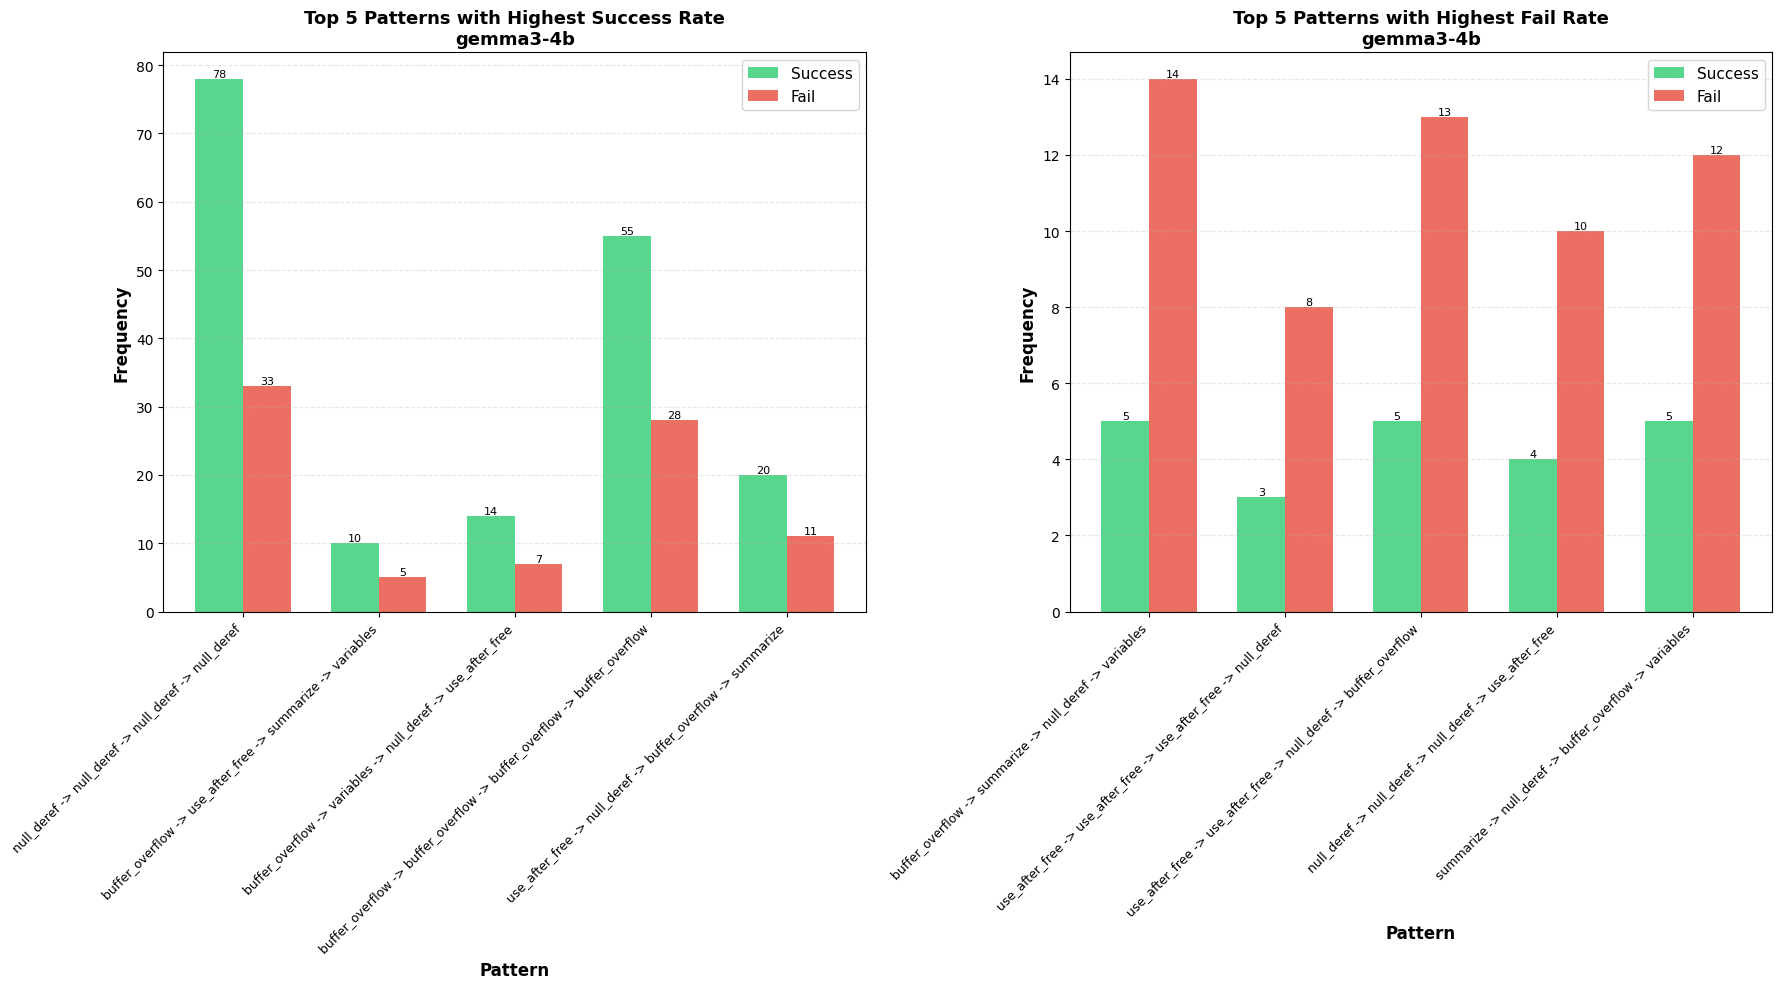


Model: llama3_1-8b


Total 4-grams collected: 58109

Total 4-grams from successful executions: 29663

Total 4-grams from failed executions: 28446
TOP 5 PATTERNS WITH HIGHEST SUCCESS RATE
----------------------------------------------------------------------------------------------------
                                                      pattern  total  success  fail success_rate fail_rate
   variables -> null_assigned_vars -> freed_vars -> functions     14       13     1        92.9%      7.1%
functions -> freed_vars -> buffer_overflow -> buffer_overflow     13       11     2        84.6%     15.4%
   summarize -> null_deref -> functions -> null_assigned_vars     17       14     3        82.4%     17.6%
     freed_vars -> null_deref -> buffer_overflow -> variables     11        9     2        81.8%     18.2%
  summarize -> freed_vars -> null_deref -> null_assigned_vars     16       13     3        81.2%     18.8%

TOP 5 PATTERNS WITH HIGHEST FAIL RATE
------------------------------

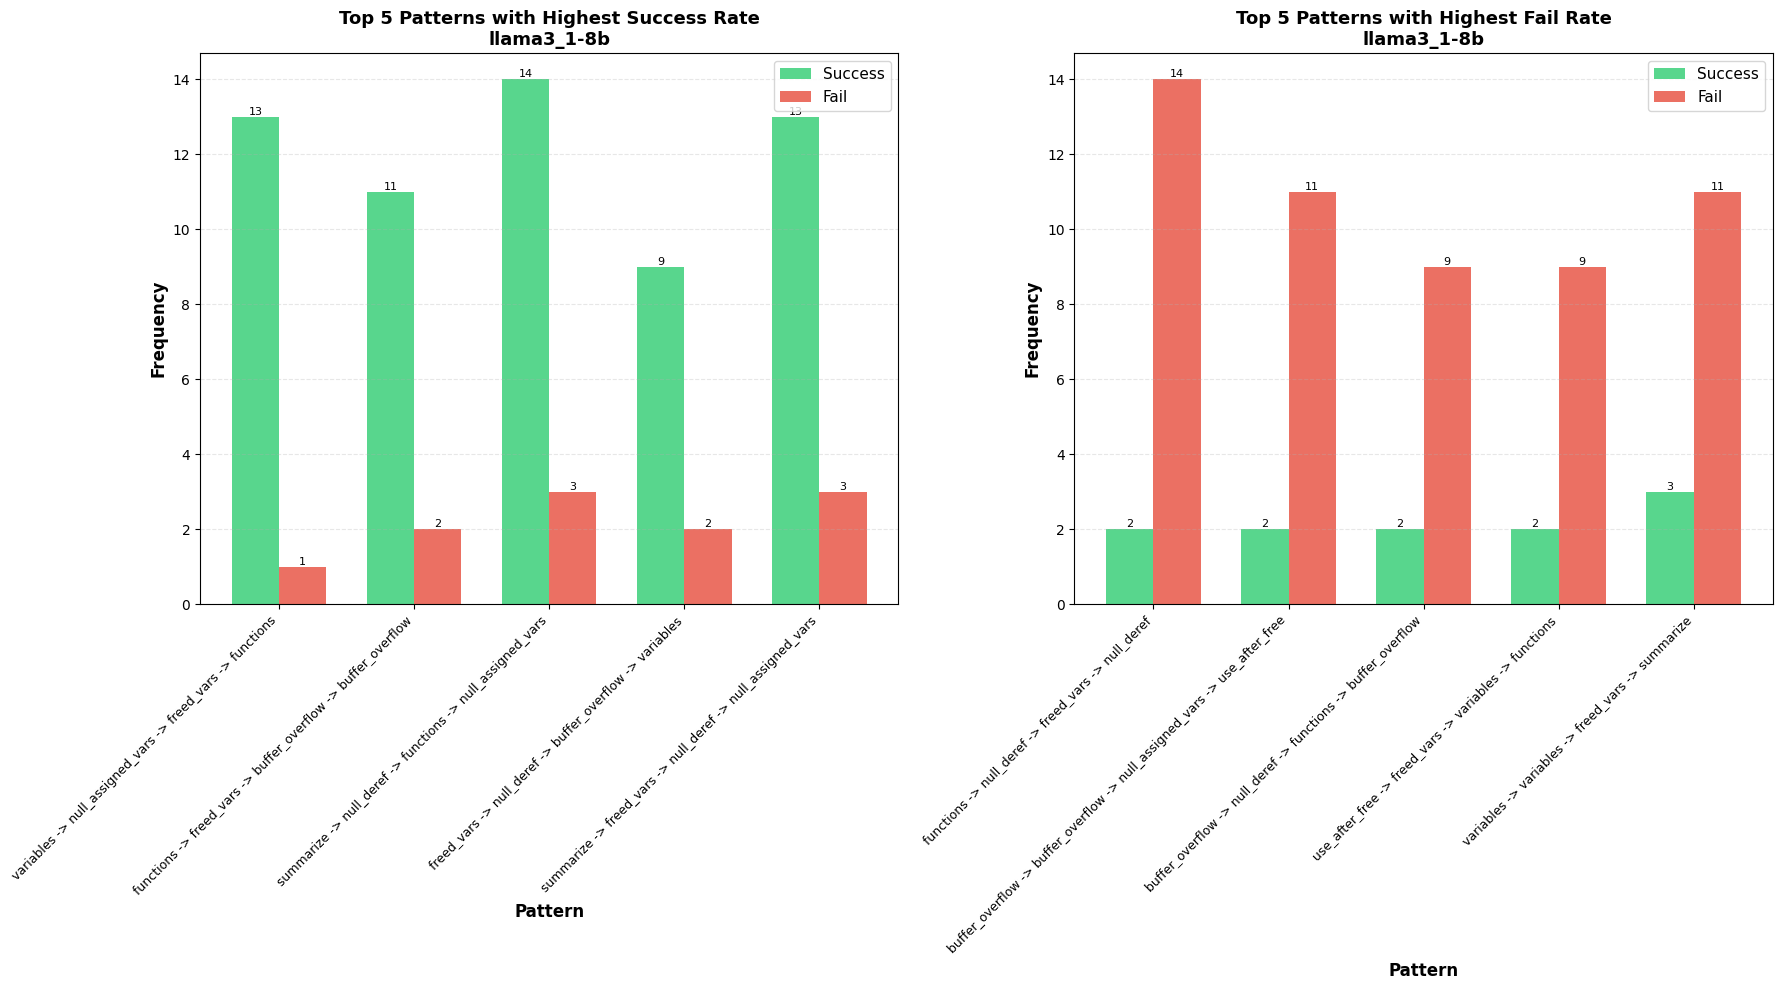


Model: llama3_2-3b


Total 4-grams collected: 23413

Total 4-grams from successful executions: 11643

Total 4-grams from failed executions: 11770
TOP 5 PATTERNS WITH HIGHEST SUCCESS RATE
----------------------------------------------------------------------------------------------------
                                                      pattern  total  success  fail success_rate fail_rate
use_after_free -> freed_vars -> buffer_overflow -> null_deref     12       10     2        83.3%     16.7%
  freed_vars -> summarize -> null_deref -> null_assigned_vars     12       10     2        83.3%     16.7%
      variables -> functions -> freed_vars -> buffer_overflow     11        9     2        81.8%     18.2%
      functions -> null_deref -> use_after_free -> freed_vars     11        9     2        81.8%     18.2%
       null_deref -> variables -> variables -> use_after_free     15       12     3        80.0%     20.0%

TOP 5 PATTERNS WITH HIGHEST FAIL RATE
------------------------------

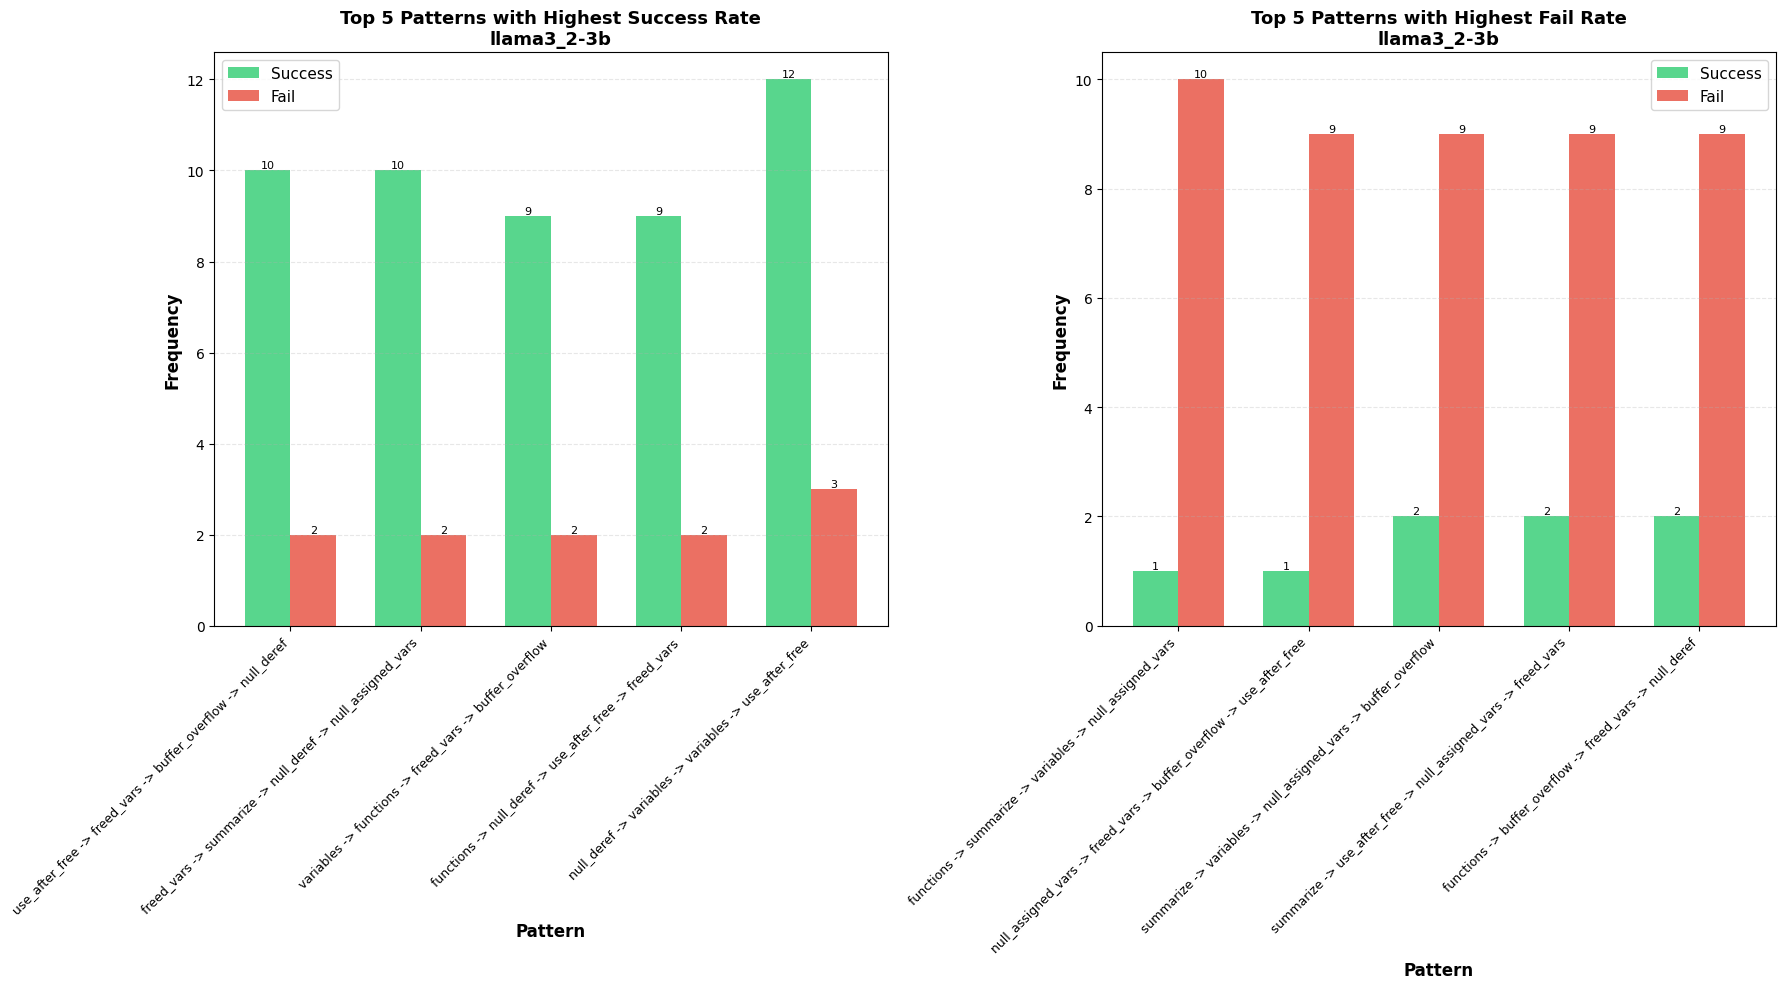


Model: mistral-7b


Total 4-grams collected: 64703

Total 4-grams from successful executions: 32938

Total 4-grams from failed executions: 31765
TOP 5 PATTERNS WITH HIGHEST SUCCESS RATE
----------------------------------------------------------------------------------------------------
                                                               pattern  total  success  fail success_rate fail_rate
       freed_vars -> use_after_free -> null_assigned_vars -> summarize     10        9     1        90.0%     10.0%
buffer_overflow -> buffer_overflow -> null_deref -> null_assigned_vars     13       11     2        84.6%     15.4%
      freed_vars -> use_after_free -> null_assigned_vars -> null_deref     11        9     2        81.8%     18.2%
                      summarize -> summarize -> functions -> functions     11        9     2        81.8%     18.2%
  use_after_free -> null_assigned_vars -> use_after_free -> null_deref     16       13     3        81.2%     18.8%

TOP 5 PATTERNS 

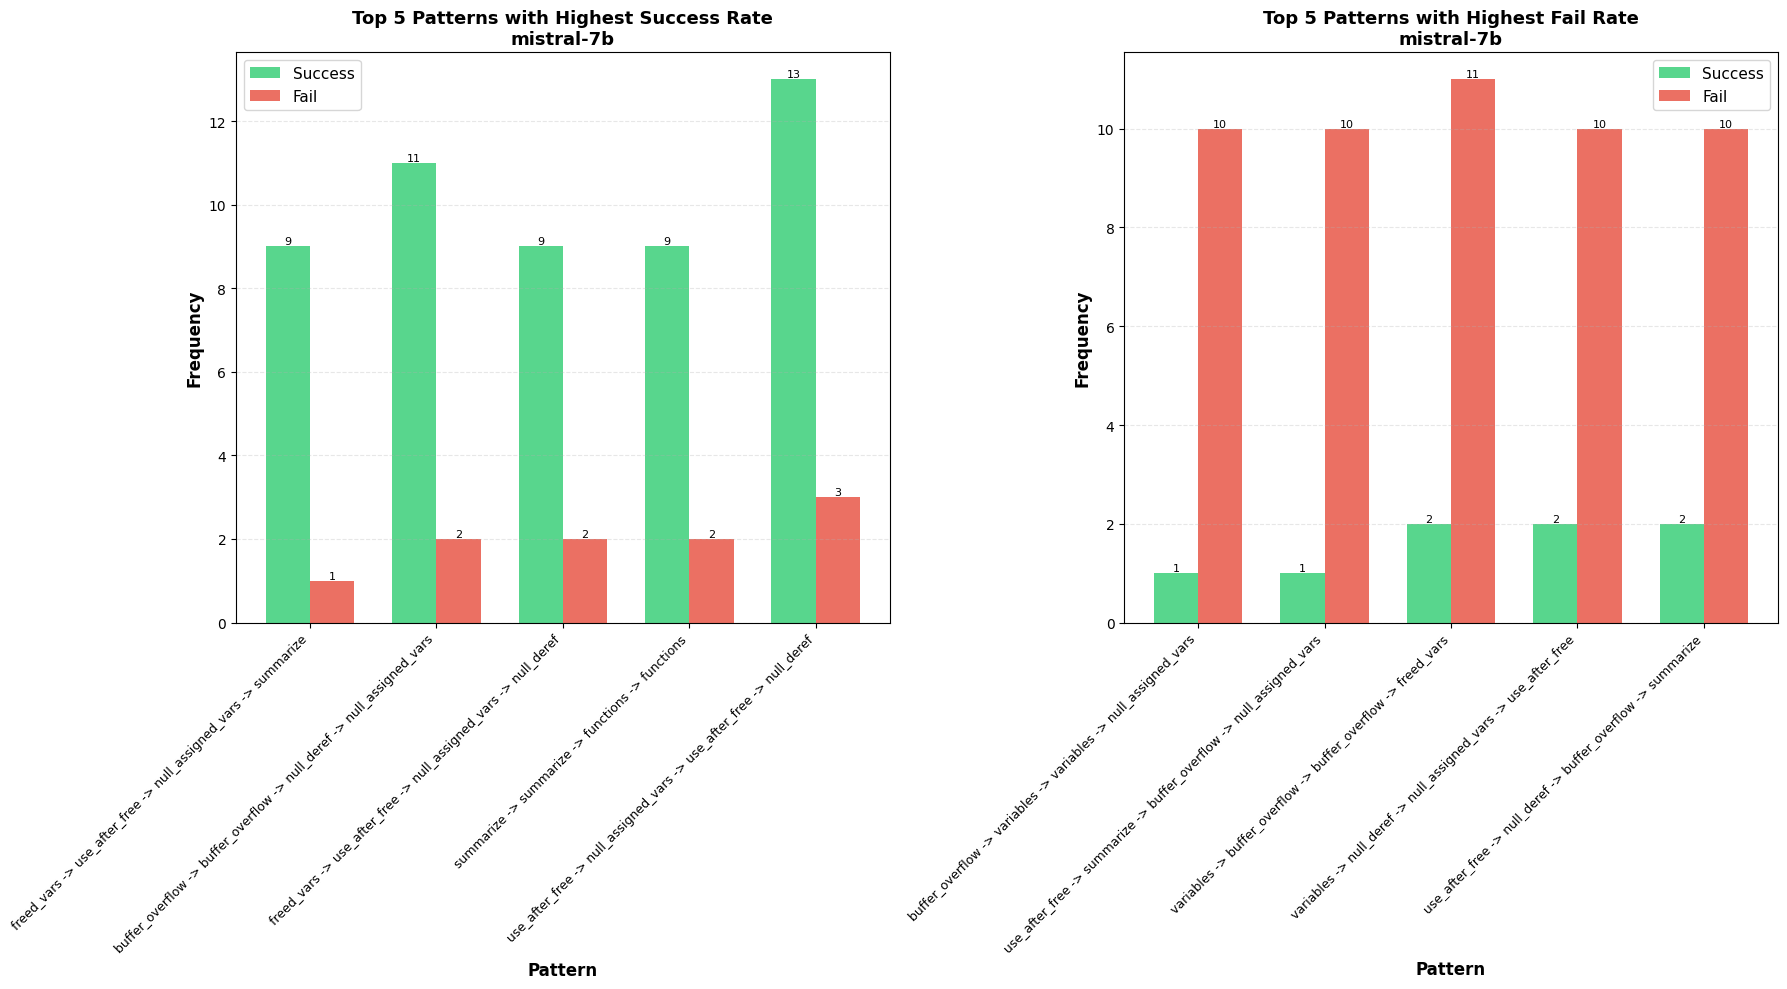

In [116]:
# Compare top patterns with highest success vs fail rates
name_mapping = {
    "summarize_code()": "summarize",
    "list_variables()": "list_vars",
    "list_functions()": "list_funcs",
    "list_freed_variables()": "list_freed_vars",
    "list_null_assigned_variables()": "list_null_assigned_vars",
    "check_pattern(buffer_overflow)": "check_buffer_overflow",
    "check_pattern(null_deref)": "check_null_deref",
    "check_pattern(use_after_free)": "check_use_after_free",
}

name_mapping = {
    "summarize_code()": "summarize",
    "list_variables()": "variables",
    "list_functions()": "functions",
    "list_freed_variables()": "freed_vars",
    "list_null_assigned_variables()": "null_assigned_vars",
    "check_pattern(buffer_overflow)": "buffer_overflow",
    "check_pattern(null_deref)": "null_deref",
    "check_pattern(use_after_free)": "use_after_free",

    "summarize_code()_valid": "summarize_valid",
    "list_variables()_valid": "variables_valid",
    "list_functions()_valid": "functions_valid",
    "list_freed_variables()_valid": "freed_vars_valid",
    "list_null_assigned_variables()_valid": "null_assigned_vars_valid",
    "check_pattern(buffer_overflow)_valid": "buffer_overflow_valid",
    "check_pattern(null_deref)_valid": "null_deref_valid",
    "check_pattern(use_after_free)_valid": "use_after_free_valid",

    "summarize_code()_invalid": "summarize_invalid",
    "list_variables()_invalid": "variables_invalid",
    "list_functions()_invalid": "functions_invalid",
    "list_freed_variables()_invalid": "freed_vars_invalid",
    "list_null_assigned_variables()_invalid": "null_assigned_vars_invalid",
    "check_pattern(buffer_overflow)_invalid": "buffer_overflow_invalid",
    "check_pattern(null_deref)_invalid": "null_deref_invalid",
    "check_pattern(use_after_free)_invalid": "use_after_free_invalid",
}

def shorten_pattern(pattern_tuple):
    """Convert long function names to short versions"""
    return ' -> '.join([name_mapping.get(func, func) for func in pattern_tuple])

# For each benchmark and model combination
models = ['gemma3-4b', 'llama3_1-8b', 'llama3_2-3b', 'mistral-7b']
n = 4
for model in models:
    print(f"\n{'='*100}")
    print(f"Model: {model}")
    print(f"{'='*100}\n")
    
    # Load the three counters
    # all_n_grams = get_n_grams_for_all_executions(model, n)
    # success_n_grams = get_n_grams_for_success_executions(model, n)
    # fail_n_grams = get_n_grams_for_fail_executions(model, n)
    all_n_grams, success_n_grams, fail_n_grams = get_ngrams_for_executions(model, n)
    
    all_counter = Counter(all_n_grams)
    success_counter = Counter(success_n_grams)
    fail_counter = Counter(fail_n_grams)
    
    # Calculate success rate for all patterns that appear at least 5 times
    # (to filter out noise from very rare patterns)
    min_count = 10
    pattern_stats = []
    
    for pattern in all_counter:
        all_count = all_counter[pattern]
        if all_count >= min_count:
            success_count = success_counter[pattern]
            fail_count = fail_counter[pattern]
            success_rate = success_count / all_count if all_count > 0 else 0
            
            pattern_stats.append({
                'pattern': pattern,
                'all_count': all_count,
                'success_count': success_count,
                'fail_count': fail_count,
                'success_rate': success_rate,
                'fail_rate': 1 - success_rate
            })
    
    # Sort by success rate
    pattern_stats.sort(key=lambda x: x['success_rate'], reverse=True)
    
    # Get top 5 success patterns and top 5 fail patterns
    top_success = pattern_stats[:5]
    top_fail = pattern_stats[-5:][::-1]  # Reverse to show highest fail rate first
    
    # Display top success patterns
    print("TOP 5 PATTERNS WITH HIGHEST SUCCESS RATE")
    print("-" * 100)
    success_data = []
    for item in top_success:
        success_data.append({
            'pattern': shorten_pattern(item['pattern']),
            'total': item['all_count'],
            'success': item['success_count'],
            'fail': item['fail_count'],
            'success_rate': f"{item['success_rate']*100:.1f}%",
            'fail_rate': f"{item['fail_rate']*100:.1f}%"
        })
    
    success_df = pd.DataFrame(success_data)
    print(success_df.to_string(index=False))
    print()
    
    # Display top fail patterns
    print("TOP 5 PATTERNS WITH HIGHEST FAIL RATE")
    print("-" * 100)
    fail_data = []
    for item in top_fail:
        fail_data.append({
            'pattern': shorten_pattern(item['pattern']),
            'total': item['all_count'],
            'success': item['success_count'],
            'fail': item['fail_count'],
            'success_rate': f"{item['success_rate']*100:.1f}%",
            'fail_rate': f"{item['fail_rate']*100:.1f}%"
        })
    
    fail_df = pd.DataFrame(fail_data)
    print(fail_df.to_string(index=False))
    print()
    
    # Create comparison visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
    
    # Plot top success patterns
    patterns_success = [shorten_pattern(item['pattern']) for item in top_success]
    success_counts = [item['success_count'] for item in top_success]
    fail_counts_success = [item['fail_count'] for item in top_success]
    
    x1 = np.arange(len(patterns_success))
    width = 0.35
    
    bars1_s = ax1.bar(x1 - width/2, success_counts, width, label='Success', color='#2ecc71', alpha=0.8)
    bars1_f = ax1.bar(x1 + width/2, fail_counts_success, width, label='Fail', color='#e74c3c', alpha=0.8)
    
    ax1.set_xlabel('Pattern', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax1.set_title(f'Top 5 Patterns with Highest Success Rate\n{model}', fontsize=13, fontweight='bold')
    ax1.set_xticks(x1)
    ax1.set_xticklabels(patterns_success, rotation=45, ha='right', fontsize=9)
    ax1.legend(fontsize=11)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels
    for bars in [bars1_s, bars1_f]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax1.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}',
                        ha='center', va='bottom', fontsize=8)
    
    # Plot top fail patterns
    patterns_fail = [shorten_pattern(item['pattern']) for item in top_fail]
    success_counts_fail = [item['success_count'] for item in top_fail]
    fail_counts = [item['fail_count'] for item in top_fail]
    
    x2 = np.arange(len(patterns_fail))
    
    bars2_s = ax2.bar(x2 - width/2, success_counts_fail, width, label='Success', color='#2ecc71', alpha=0.8)
    bars2_f = ax2.bar(x2 + width/2, fail_counts, width, label='Fail', color='#e74c3c', alpha=0.8)
    
    ax2.set_xlabel('Pattern', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax2.set_title(f'Top 5 Patterns with Highest Fail Rate\n{model}', fontsize=13, fontweight='bold')
    ax2.set_xticks(x2)
    ax2.set_xticklabels(patterns_fail, rotation=45, ha='right', fontsize=9)
    ax2.legend(fontsize=11)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels
    for bars in [bars2_s, bars2_f]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax2.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}',
                        ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()

### Correlation

In [135]:
models = ['gemma3-4b', 'llama3_1-8b', 'llama3_2-3b', 'mistral-7b']

    # min_count = 10
    # pattern_stats = []
    
    # for pattern in all_counter:
    #     all_count = all_counter[pattern]
    #     if all_count >= min_count:
    #         success_count = success_counter[pattern]
    #         fail_count = fail_counter[pattern]
    #         success_rate = success_count / all_count if all_count > 0 else 0
            
    #         pattern_stats.append({
    #             'pattern': pattern,
    #             'all_count': all_count,
    #             'success_count': success_count,
    #             'fail_count': fail_count,
    #             'success_rate': success_rate,
    #             'fail_rate': 1 - success_rate
    #         })


for n in [3, 4, 5]:
    for with_validity in [True, False]:
        for model in models:
            print(f"\n{'='*100}")
            print(f"Model: {model}")
            print(f"{'='*100}\n")
            
            # Load the three counters
            # all_n_grams = get_n_grams_for_all_executions(model, n, with_validity=with_validity)
            # success_n_grams = get_n_grams_for_success_executions(model, n, with_validity=with_validity)
            # fail_n_grams = get_n_grams_for_fail_executions(model, n, with_validity=with_validity)

            all_n_grams, success_n_grams, fail_n_grams = get_ngrams_for_executions(model, n, with_validity=with_validity)

            all_counter = Counter(all_n_grams)
            success_counter = Counter(success_n_grams)
            fail_counter = Counter(fail_n_grams)

            # top_30_all = [pattern for pattern in all_counter.most_common(1000)]
            # patterns = [pattern for pattern in all_counter]
            patterns = []
            for pattern in all_counter:
                if all_counter[pattern] >= min_count:
                    patterns.append(pattern)

            # print(top_30_all)
            # print(patterns)
            correlation_data = []
            for pattern in patterns:
                success_label = []
                ngram_presence = []
                # print(pattern)
                for split_dir in os.listdir(DEVIGN_DIR / model):
                    # print(split_dir)
                    if not (split_dir == "test" or split_dir == "valid" or split_dir == "train"):
                        continue
                    for data_file in os.listdir(DEVIGN_DIR / model / split_dir):
                        with open(DEVIGN_DIR / model / split_dir / data_file, 'r', encoding='utf-8') as f:
                            data = json.load(f)
                            if 'trajectory' not in data or type(data['trajectory']) != dict:
                                continue # zero occurrence
                            trajectory = data['trajectory']
                            if 'done' not in trajectory or not trajectory['done']:
                                continue # zero occurrence
                            if not "reward" in trajectory:
                                continue

                            if with_validity:
                                sequence = extract_function_call_sequence_with_validity(trajectory["state"]["processed_actions"])
                            if not with_validity:
                                sequence = extract_function_call_sequence(trajectory["state"]["processed_actions"])
                            n_grams = get_n_grams(sequence, n)
                            execution_success = trajectory["reward"] == 1

                            if execution_success:
                                success_label.append(1)
                            else:
                                success_label.append(0)
                            
                            if pattern in n_grams:
                                ngram_presence.append(1)
                            else:
                                ngram_presence.append(0)
                # print(len(success_label))
                # prin
                correlation, p_value = pointbiserialr(success_label, ngram_presence)
                correlation_data.append({
                    'pattern': pattern,
                    'correlation': correlation,
                    'p-value': p_value
                })


            correlation_df = pd.DataFrame(correlation_data)
            if with_validity:
                output_dir = f'./correlation/devign/{n}-gram/with_validity/{model}'
            else:
                output_dir = f'./correlation/devign/{n}-gram/without_validity/{model}'
            os.makedirs(output_dir, exist_ok=True)
            correlation_df.to_csv(os.path.join(output_dir, 'correlation.csv'), index=False)
            print(f"Saved {os.path.join(output_dir, 'correlation.csv')}")



Model: gemma3-4b


Total 3-grams collected: 6475

Total 3-grams from successful executions: 3223

Total 3-grams from failed executions: 3252
Saved ./correlation/devign/3-gram/with_validity/gemma3-4b/correlation.csv

Model: llama3_1-8b


Total 3-grams collected: 65803

Total 3-grams from successful executions: 33510

Total 3-grams from failed executions: 32293
Saved ./correlation/devign/3-gram/with_validity/llama3_1-8b/correlation.csv

Model: llama3_2-3b


Total 3-grams collected: 30143

Total 3-grams from successful executions: 14998

Total 3-grams from failed executions: 15145
Saved ./correlation/devign/3-gram/with_validity/llama3_2-3b/correlation.csv

Model: mistral-7b


Total 3-grams collected: 72421

Total 3-grams from successful executions: 36810

Total 3-grams from failed executions: 35611
Saved ./correlation/devign/3-gram/with_validity/mistral-7b/correlation.csv

Model: gemma3-4b


Total 3-grams collected: 6475

Total 3-grams from successful executions: 3223

Total 3-grams from

KeyboardInterrupt: 

In [110]:
name_mapping = {
    "summarize_code()": "summarize",
    "list_variables()": "variables",
    "list_functions()": "functions",
    "list_freed_variables()": "freed_vars",
    "list_null_assigned_variables()": "null_assigned_vars",
    "check_pattern(buffer_overflow)": "buffer_overflow",
    "check_pattern(null_deref)": "null_deref",
    "check_pattern(use_after_free)": "use_after_free",

    "summarize_code()_valid": "summarize_valid",
    "list_variables()_valid": "variables_valid",
    "list_functions()_valid": "functions_valid",
    "list_freed_variables()_valid": "freed_vars_valid",
    "list_null_assigned_variables()_valid": "null_assigned_vars_valid",
    "check_pattern(buffer_overflow)_valid": "buffer_overflow_valid",
    "check_pattern(null_deref)_valid": "null_deref_valid",
    "check_pattern(use_after_free)_valid": "use_after_free_valid",

    "summarize_code()_invalid": "summarize_invalid",
    "list_variables()_invalid": "variables_invalid",
    "list_functions()_invalid": "functions_invalid",
    "list_freed_variables()_invalid": "freed_vars_invalid",
    "list_null_assigned_variables()_invalid": "null_assigned_vars_invalid",
    "check_pattern(buffer_overflow)_invalid": "buffer_overflow_invalid",
    "check_pattern(null_deref)_invalid": "null_deref_invalid",
    "check_pattern(use_after_free)_invalid": "use_after_free_invalid",
}
def shorten_pattern(pattern_tuple):
    """Convert long function names to short versions"""
    return ' -> '.join([name_mapping.get(func, func) for func in pattern_tuple])

models = ['gemma3-4b', 'llama3_1-8b', 'llama3_2-3b', 'mistral-7b']

for n in [3, 4, 5]:
    print(f"\n{'='*100}")
    print(f"{n}-gram")
    # print(f"{'='*100}\n")
    for with_validity in [False, True]:
        if with_validity:
            print(f"\n{'='*100}")
            print("With Validity:")
            print(f"\n{'='*100}")
        else:
            print(f"\n{'='*100}")
            print("Without Validity:")
            print(f"\n{'='*100}")
        for model in models:
            if with_validity:
                correlation_file = f'./correlation/devign/{n}-gram/with_validity/{model}/correlation.csv'
            if not with_validity:
                correlation_file = f'./correlation/devign/{n}-gram/without_validity/{model}/correlation.csv'
            df = pd.read_csv(correlation_file)
            df['pattern'] = df['pattern'].apply(ast.literal_eval)
            df['short_pattern'] = df['pattern'].apply(shorten_pattern)

            top_5_high = df.sort_values(by='correlation', ascending=False).head(5)
            top_5_low = df.sort_values(by='correlation', ascending=True).head(5)
            print(f"=================={model}==================")
            print("=== Top 5 high ===")
            pd.options.display.max_colwidth = 2000
            print(top_5_high[['short_pattern', 'correlation', 'p-value']])
            print("=== Top 5 low ===")
            print(top_5_low[['short_pattern', 'correlation', 'p-value']])



3-gram

Without Validity:

==================gemma3-4b==================
=== Top 5 high ===
                                      short_pattern  correlation   p-value
3   buffer_overflow -> use_after_free -> null_deref     0.028015  0.011202
11   variables -> buffer_overflow -> use_after_free     0.021916  0.047251
27        variables -> use_after_free -> null_deref     0.017890  0.105333
14  use_after_free -> null_deref -> buffer_overflow     0.014038  0.203821
19        use_after_free -> null_deref -> variables     0.012060  0.274956
=== Top 5 low ===
                                      short_pattern  correlation   p-value
17       null_deref -> buffer_overflow -> variables    -0.022813  0.038895
1   buffer_overflow -> null_deref -> use_after_free    -0.020397  0.064817
24        summarize -> null_deref -> use_after_free    -0.020239  0.066922
23       buffer_overflow -> summarize -> null_deref    -0.017246  0.118489
25        null_deref -> variables -> use_after_free    -0.013185

## 4-gram Analysis with Validity

In [31]:
models = ['gemma3-4b', 'llama3_1-8b', 'llama3_2-3b', 'mistral-7b']

for model in models:
    all_n_grams = get_n_grams_for_all_executions(model, n, with_validity=True)

    all_counter = Counter(all_n_grams)

    results = []
    for n_gram, count in all_counter.most_common():
        results.append({
            f'{n}gram': n_gram,
            'frequency': count
        })
    
    df = pd.DataFrame(results)
    os.makedirs(f"./{n}gram_frequency/devign/with_validity/all_executions", exist_ok=True)
    output_file = f"./{n}gram_frequency/devign/with_validity/all_executions/{model}_{n}gram_frequencies.csv"
    df.to_csv(output_file, index=False)
    print(f"Saved {output_file} with {len(df)} unique {n}-gram")


Total 3-grams collected: 7122
Saved ./3gram_frequency/devign/with_validity/all_executions/gemma3-4b_3gram_frequencies.csv with 232 unique 3-gram

Total 3-grams collected: 68587
Saved ./3gram_frequency/devign/with_validity/all_executions/llama3_1-8b_3gram_frequencies.csv with 863 unique 3-gram

Total 3-grams collected: 33205
Saved ./3gram_frequency/devign/with_validity/all_executions/llama3_2-3b_3gram_frequencies.csv with 414 unique 3-gram

Total 3-grams collected: 74666
Saved ./3gram_frequency/devign/with_validity/all_executions/mistral-7b_3gram_frequencies.csv with 1937 unique 3-gram


In [33]:
models = ['gemma3-4b', 'llama3_1-8b', 'llama3_2-3b', 'mistral-7b']

for model in models:
    all_n_grams = get_n_grams_for_success_executions(model, n, with_validity=True)

    all_counter = Counter(all_n_grams)

    results = []
    for n_gram, count in all_counter.most_common():
        results.append({
            f'{n}gram': n_gram,
            'frequency': count
        })
    
    df = pd.DataFrame(results)
    os.makedirs(f"./{n}gram_frequency/devign/with_validity/success_executions", exist_ok=True)
    output_file = f"./{n}gram_frequency/devign/with_validity/success_executions/{model}_{n}gram_frequencies.csv"
    df.to_csv(output_file, index=False)
    print(f"Saved {output_file} with {len(df)} unique {n}-gram")


Total 3-grams collected: 3223
Saved ./3gram_frequency/devign/with_validity/success_executions/gemma3-4b_3gram_frequencies.csv with 181 unique 3-gram

Total 3-grams collected: 33510
Saved ./3gram_frequency/devign/with_validity/success_executions/llama3_1-8b_3gram_frequencies.csv with 668 unique 3-gram

Total 3-grams collected: 14998
Saved ./3gram_frequency/devign/with_validity/success_executions/llama3_2-3b_3gram_frequencies.csv with 396 unique 3-gram

Total 3-grams collected: 38799
Saved ./3gram_frequency/devign/with_validity/success_executions/mistral-7b_3gram_frequencies.csv with 1608 unique 3-gram


In [34]:
models = ['gemma3-4b', 'llama3_1-8b', 'llama3_2-3b', 'mistral-7b']

for model in models:
    all_n_grams = get_n_grams_for_fail_executions(model, with_validity=True)

    all_counter = Counter(all_n_grams)

    results = []
    for n_gram, count in all_counter.most_common():
        results.append({
            f'{n}gram': n_gram,
            'frequency': count
        })
    
    df = pd.DataFrame(results)
    os.makedirs(f"./{n}gram_frequency/devign/with_validity/fail_executions", exist_ok=True)
    output_file = f"./{n}gram_frequency/devign/with_validity/fail_executions/{model}_{n}gram_frequencies.csv"
    df.to_csv(output_file, index=False)
    print(f"Saved {output_file} with {len(df)} unique {n}-gram")


Total 4-grams collected: 2070
Saved ./3gram_frequency/devign/with_validity/fail_executions/gemma3-4b_3gram_frequencies.csv with 305 unique 3-gram

Total 4-grams collected: 30888
Saved ./3gram_frequency/devign/with_validity/fail_executions/llama3_1-8b_3gram_frequencies.csv with 2318 unique 3-gram

Total 4-grams collected: 14128
Saved ./3gram_frequency/devign/with_validity/fail_executions/llama3_2-3b_3gram_frequencies.csv with 1751 unique 3-gram

Total 4-grams collected: 31991
Saved ./3gram_frequency/devign/with_validity/fail_executions/mistral-7b_3gram_frequencies.csv with 4165 unique 3-gram


### Top-10 frequent action sequences


Model: gemma3-4b


Total 3-grams collected: 7122

Total 3-grams collected: 3223

Total 3-grams collected: 3899
                                                                               pattern  all_executions  success_executions  fail_executions success_ratio fail_ratio
check_use_after_free_valid -> check_use_after_free_valid -> check_use_after_free_valid             643                 260              383         40.4%      59.6%
              list_vars_valid -> check_buffer_overflow_valid -> check_null_deref_valid             481                 209              272         43.5%      56.5%
   check_buffer_overflow_valid -> check_null_deref_valid -> check_use_after_free_valid             479                 198              281         41.3%      58.7%
   check_buffer_overflow_valid -> check_use_after_free_valid -> check_null_deref_valid             354                 184              170         52.0%      48.0%
              check_buffer_overflow_valid -> check_null_deref_v

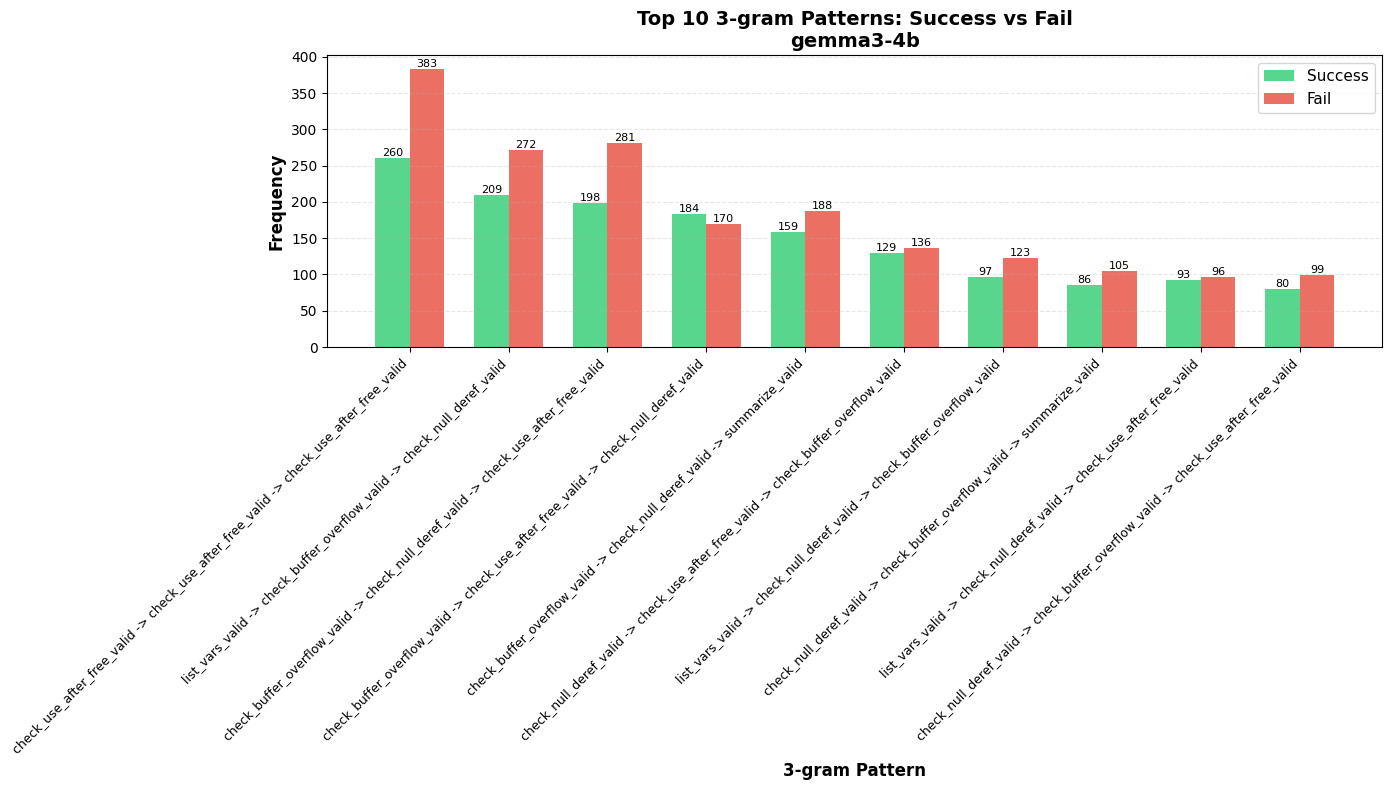


Model: llama3_1-8b


Total 3-grams collected: 68587

Total 3-grams collected: 33510

Total 3-grams collected: 35077
                                                                                  pattern  all_executions  success_executions  fail_executions success_ratio fail_ratio
                        check_buffer_overflow_valid -> summarize_valid -> list_vars_valid            1624                 785              839         48.3%      51.7%
check_buffer_overflow_valid -> check_buffer_overflow_valid -> check_buffer_overflow_valid            1452                 807              645         55.6%      44.4%
               check_null_deref_valid -> check_null_deref_valid -> check_null_deref_valid            1225                 716              509         58.4%      41.6%
                                   summarize_valid -> list_vars_valid -> list_funcs_valid            1091                 519              572         47.6%      52.4%
               list_funcs_valid -> list_fre

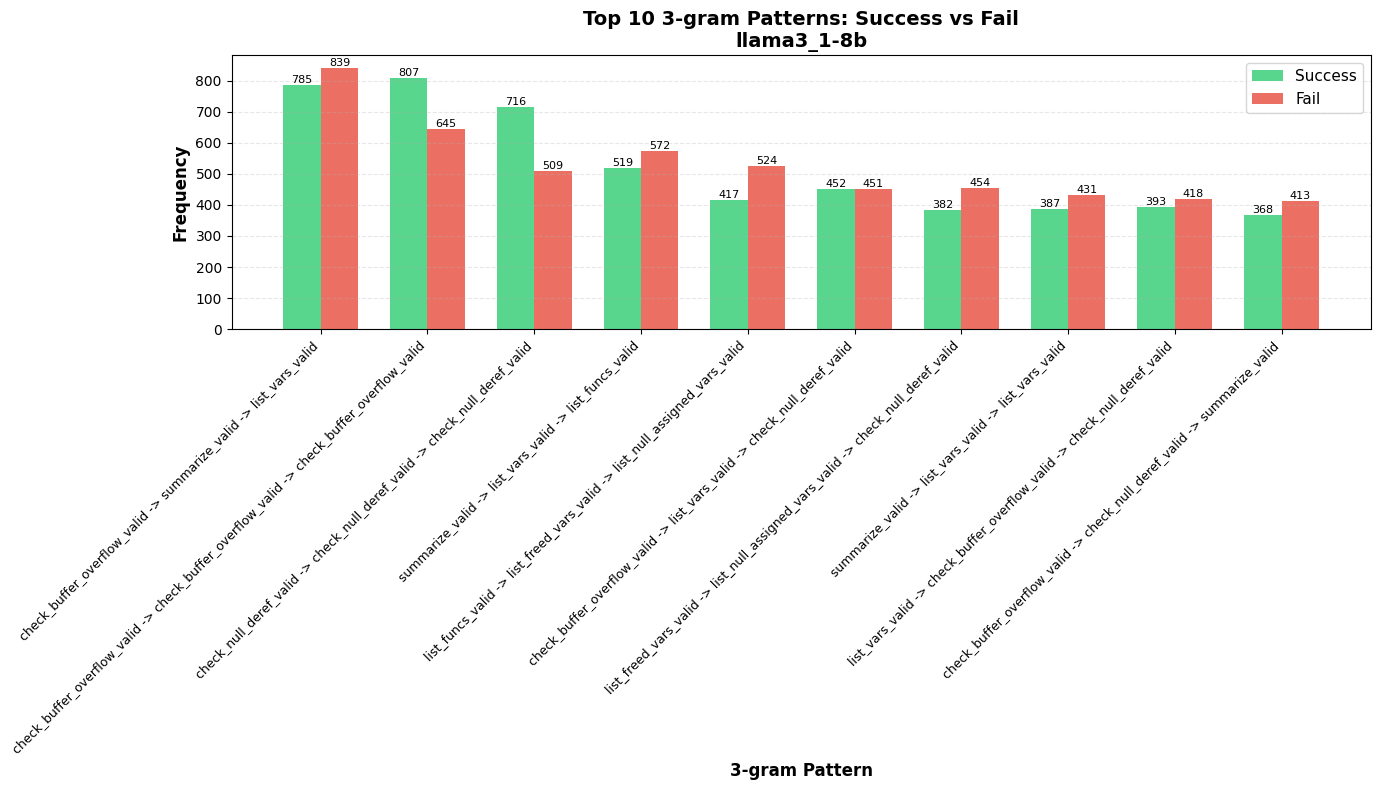


Model: llama3_2-3b


Total 3-grams collected: 33205

Total 3-grams collected: 14998

Total 3-grams collected: 18207
                                                                            pattern  all_executions  success_executions  fail_executions success_ratio fail_ratio
           list_vars_valid -> check_buffer_overflow_valid -> check_null_deref_valid             582                 268              314         46.0%      54.0%
       list_vars_valid -> check_buffer_overflow_valid -> check_use_after_free_valid             576                 279              297         48.4%      51.6%
            list_vars_valid -> check_buffer_overflow_valid -> list_freed_vars_valid             547                 247              300         45.2%      54.8%
           check_buffer_overflow_valid -> list_vars_valid -> check_null_deref_valid             535                 240              295         44.9%      55.1%
check_buffer_overflow_valid -> check_null_deref_valid -> check_use_after_

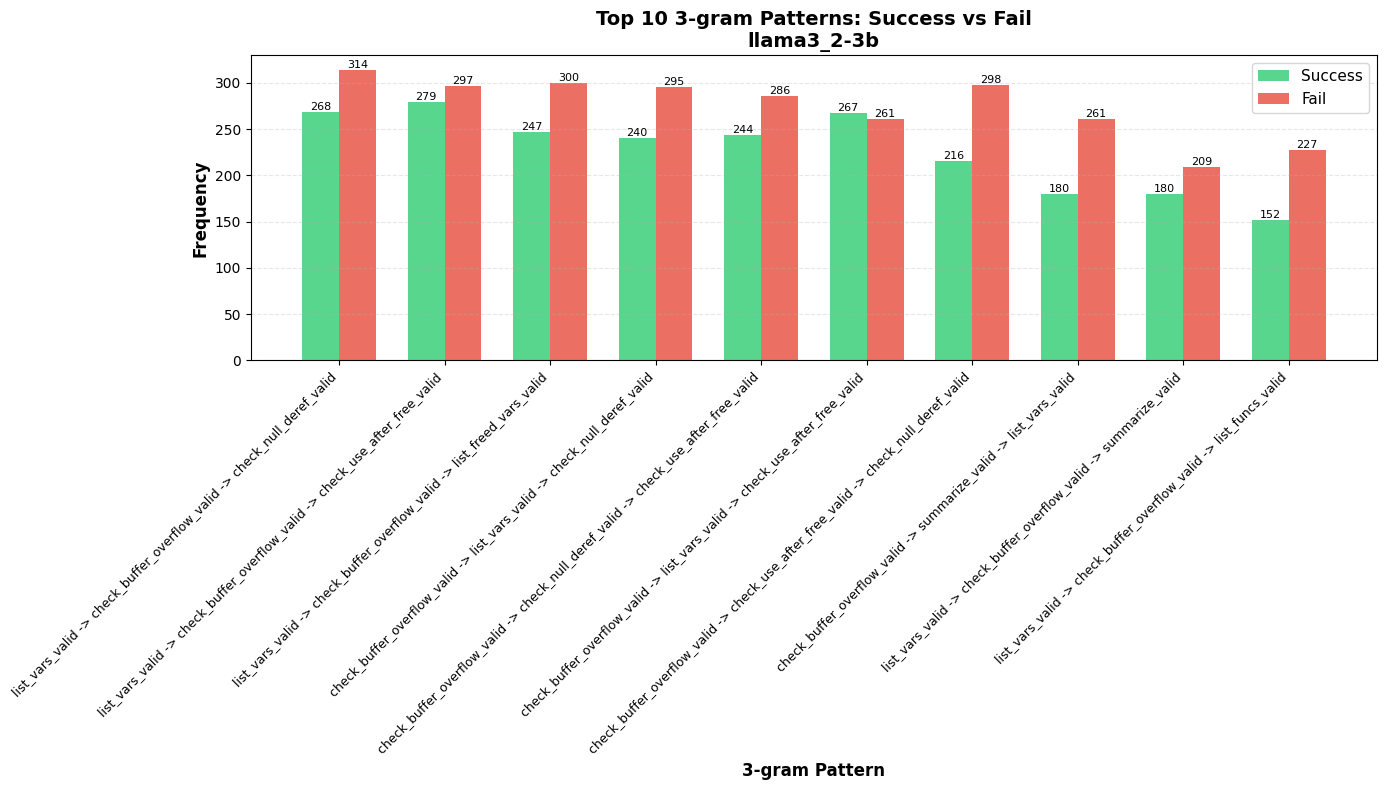


Model: mistral-7b


Total 3-grams collected: 74666

Total 3-grams collected: 38799

Total 3-grams collected: 35867
                                                                                  pattern  all_executions  success_executions  fail_executions success_ratio fail_ratio
check_buffer_overflow_valid -> check_buffer_overflow_valid -> check_buffer_overflow_valid           13993                7584             6409         54.2%      45.8%
                                    list_vars_valid -> list_vars_valid -> list_vars_valid            3885                2083             1802         53.6%      46.4%
   check_use_after_free_valid -> check_use_after_free_valid -> check_use_after_free_valid            3253                1688             1565         51.9%      48.1%
            list_vars_valid -> check_buffer_overflow_valid -> check_buffer_overflow_valid            1844                1015              829         55.0%      45.0%
                       list_vars_valid -> li

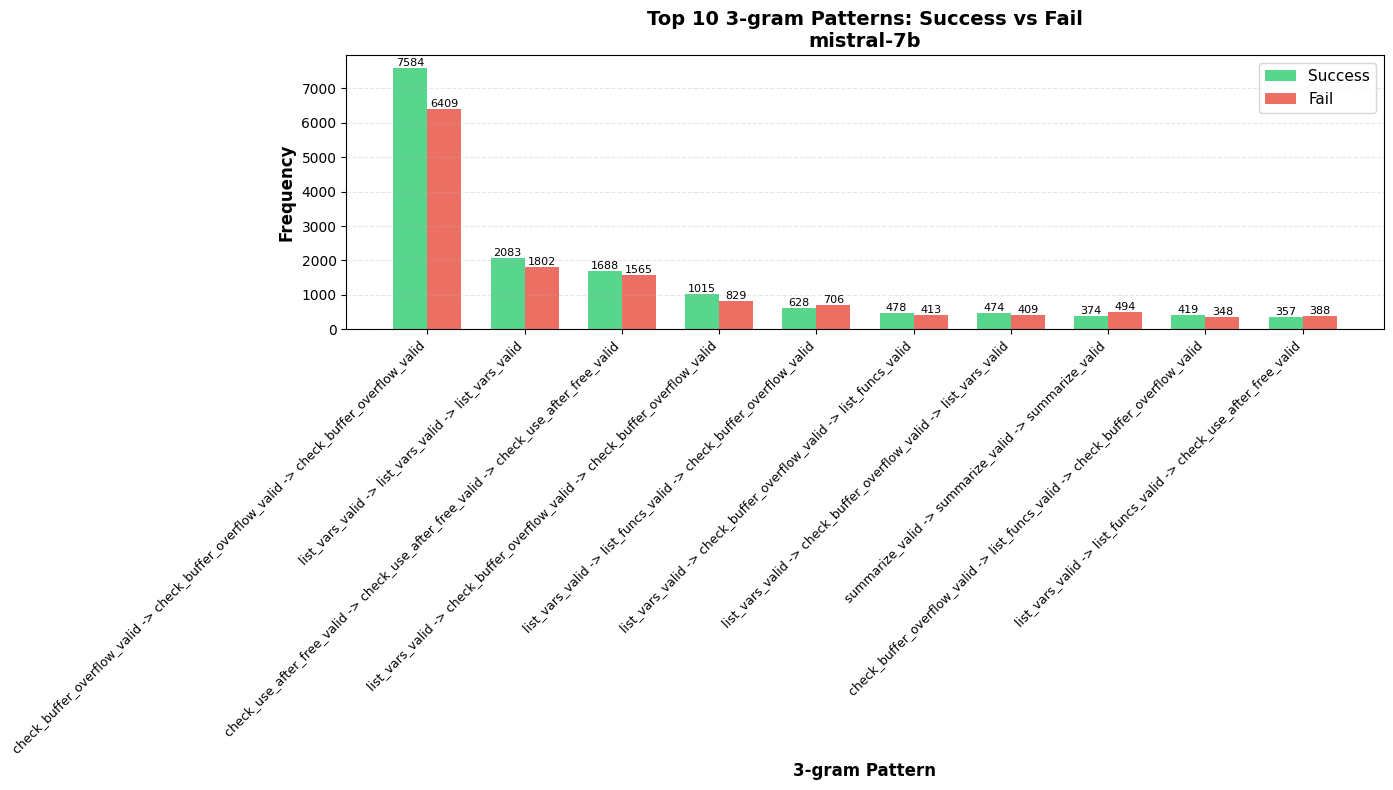

In [36]:
# Compare top 10 most frequent 4-grams in all executions vs success/fail executions
name_mapping = {
    "summarize_code()_valid": "summarize_valid",
    "list_variables()_valid": "list_vars_valid",
    "list_functions()_valid": "list_funcs_valid",
    "list_freed_variables()_valid": "list_freed_vars_valid",
    "list_null_assigned_variables()_valid": "list_null_assigned_vars_valid",
    "check_pattern(buffer_overflow)_valid": "check_buffer_overflow_valid",
    "check_pattern(null_deref)_valid": "check_null_deref_valid",
    "check_pattern(use_after_free)_valid": "check_use_after_free_valid",
    "summarize_code()_invalid": "summarize_invalid",
    "list_variables()_invalid": "list_vars_invalid",
    "list_functions()_invalid": "list_funcs_invalid",
    "list_freed_variables()_invalid": "list_freed_vars_invalid",
    "list_null_assigned_variables()_invalid": "list_null_assigned_vars_invalid",
    "check_pattern(buffer_overflow)_invalid": "check_buffer_overflow_invalid",
    "check_pattern(null_deref)_invalid": "check_null_deref_invalid",
    "check_pattern(use_after_free)_invalid": "check_use_after_free_invalid",
}


def shorten_pattern(pattern_tuple):
    """Convert long function names to short versions"""
    return ' -> '.join([name_mapping.get(func, func) for func in pattern_tuple])

# For each benchmark and model combination
models = ['gemma3-4b', 'llama3_1-8b', 'llama3_2-3b', 'mistral-7b']

for model in models:
    print(f"\n{'='*100}")
    print(f"Model: {model}")
    print(f"{'='*100}\n")
    
    # Load the three counters
    all_n_grams = get_n_grams_for_all_executions(model, n, with_validity=True)
    success_n_grams = get_n_grams_for_success_executions(model, n, with_validity=True)
    fail_n_grams = get_n_grams_for_fail_executions(model, n, with_validity=True)
    
    all_counter = Counter(all_n_grams)
    success_counter = Counter(success_n_grams)
    fail_counter = Counter(fail_n_grams)
    
    # Get top 10 from all executions
    top_10_patterns = [pattern for pattern, count in all_counter.most_common(10)]
    
    # Create comparison table
    comparison_data = []
    for pattern in top_10_patterns:
        all_count = all_counter[pattern]
        success_count = success_counter[pattern]
        fail_count = fail_counter[pattern]
        
        comparison_data.append({
            'pattern': shorten_pattern(pattern),
            'all_executions': all_count,
            'success_executions': success_count,
            'fail_executions': fail_count,
            'success_ratio': f"{success_count/all_count*100:.1f}%" if all_count > 0 else "0%",
            'fail_ratio': f"{fail_count/all_count*100:.1f}%" if all_count > 0 else "0%"
        })
    
    # Display as DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    print()
    
    # Create bar chart
    fig, ax = plt.subplots(figsize=(14, 8))
    
    patterns = comparison_df['pattern'].tolist()
    success_counts = comparison_df['success_executions'].tolist()
    fail_counts = comparison_df['fail_executions'].tolist()
    
    x = np.arange(len(patterns))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, success_counts, width, label='Success', color='#2ecc71', alpha=0.8)
    bars2 = ax.bar(x + width/2, fail_counts, width, label='Fail', color='#e74c3c', alpha=0.8)
    
    ax.set_xlabel(f'{n}-gram Pattern', fontsize=12, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax.set_title(f'Top 10 {n}-gram Patterns: Success vs Fail\n{model}', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(patterns, rotation=45, ha='right', fontsize=9)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}',
                        ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()


Model: gemma3-4b


Total 4-grams collected: 3762

Total 4-grams collected: 1692

Total 4-grams collected: 2070


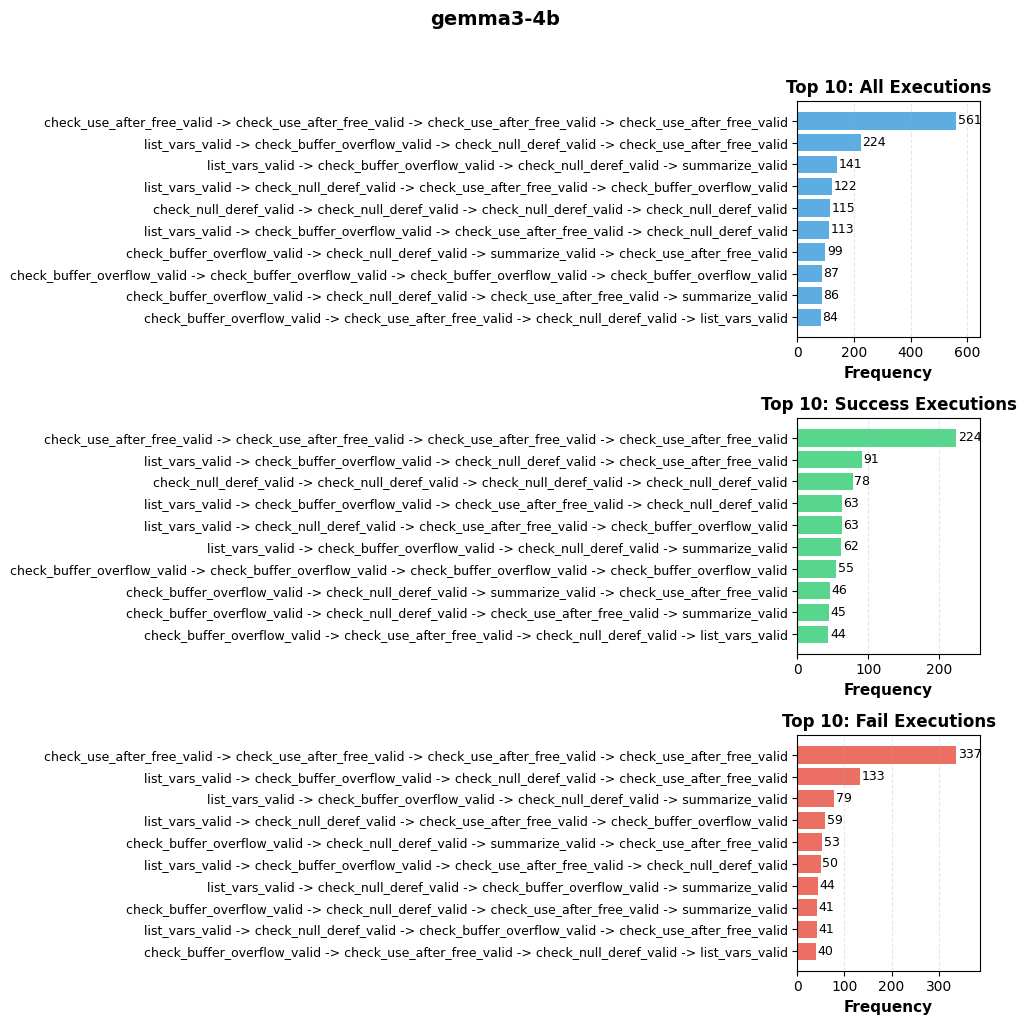


Model: llama3_1-8b


Total 4-grams collected: 60551

Total 4-grams collected: 29663

Total 4-grams collected: 30888


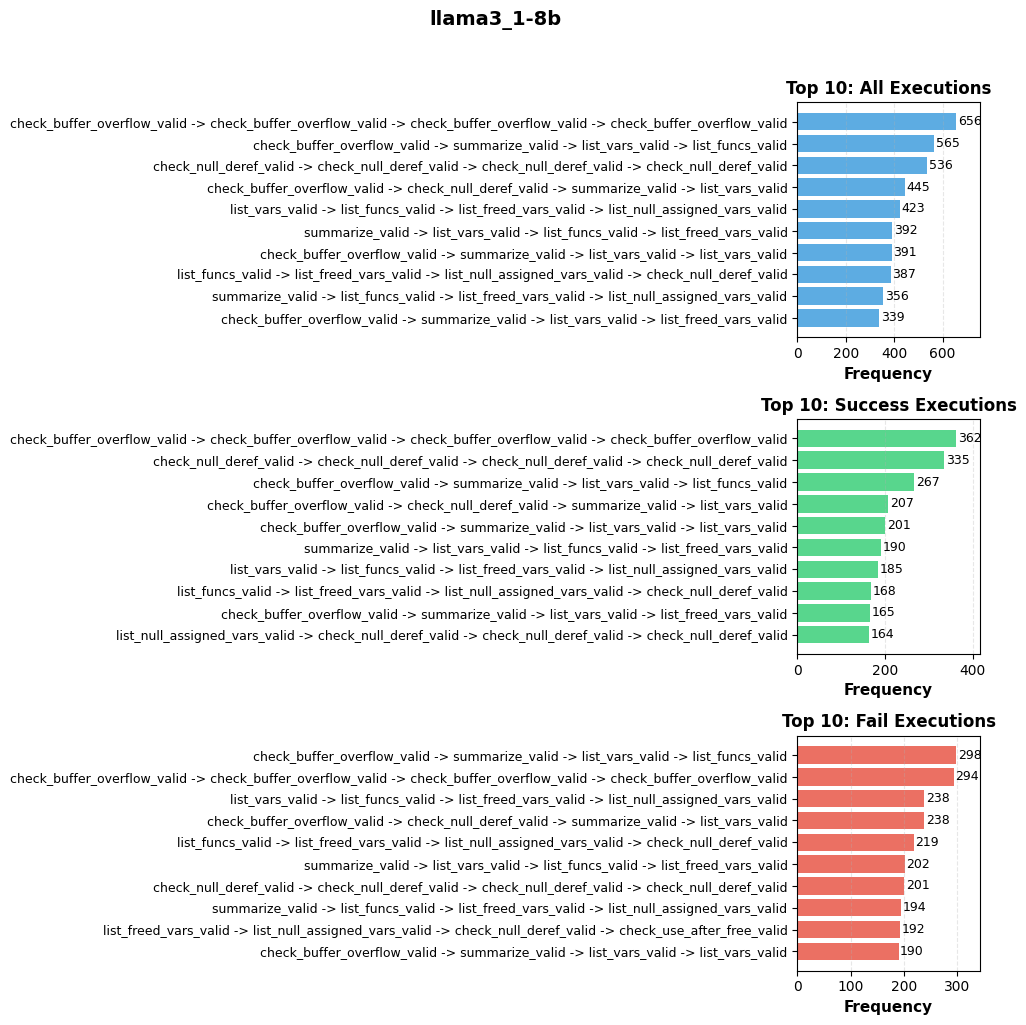


Model: llama3_2-3b


Total 4-grams collected: 25771

Total 4-grams collected: 11643

Total 4-grams collected: 14128


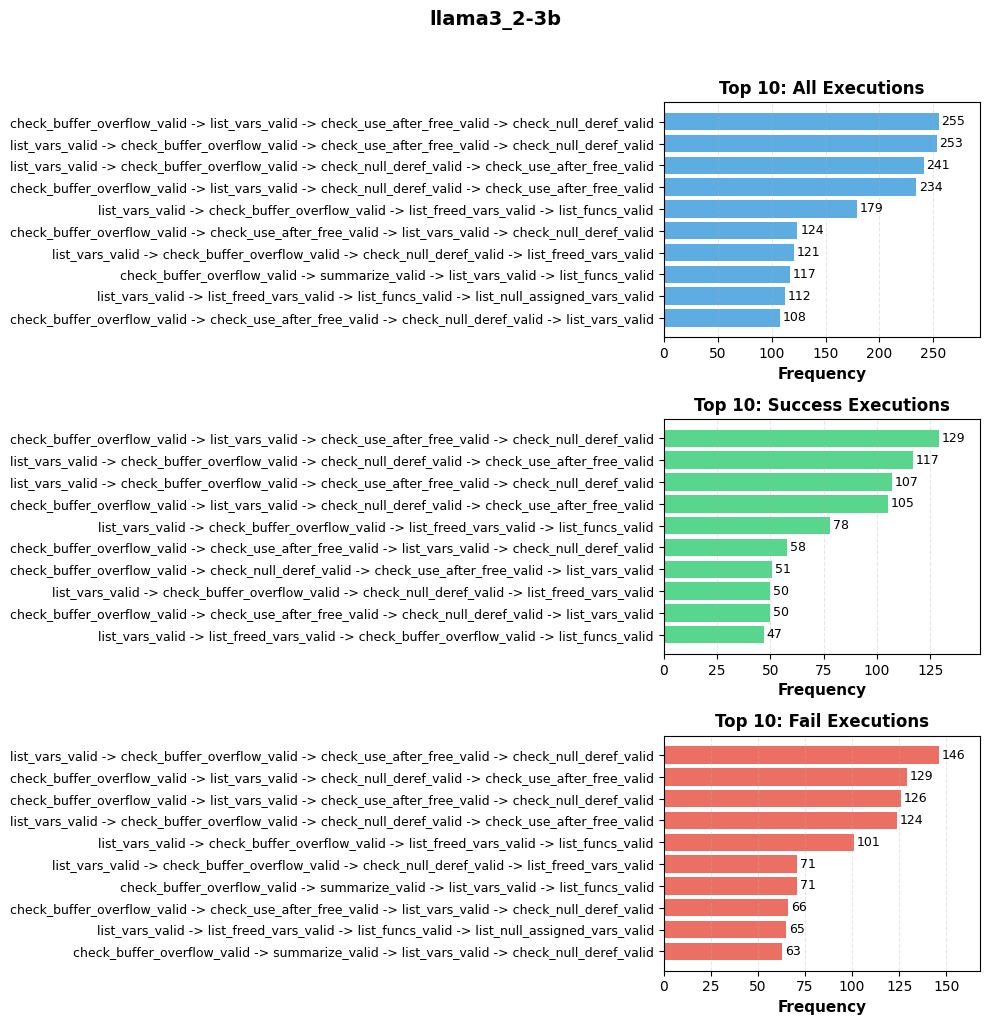


Model: mistral-7b


Total 4-grams collected: 66709

Total 4-grams collected: 34718

Total 4-grams collected: 31991


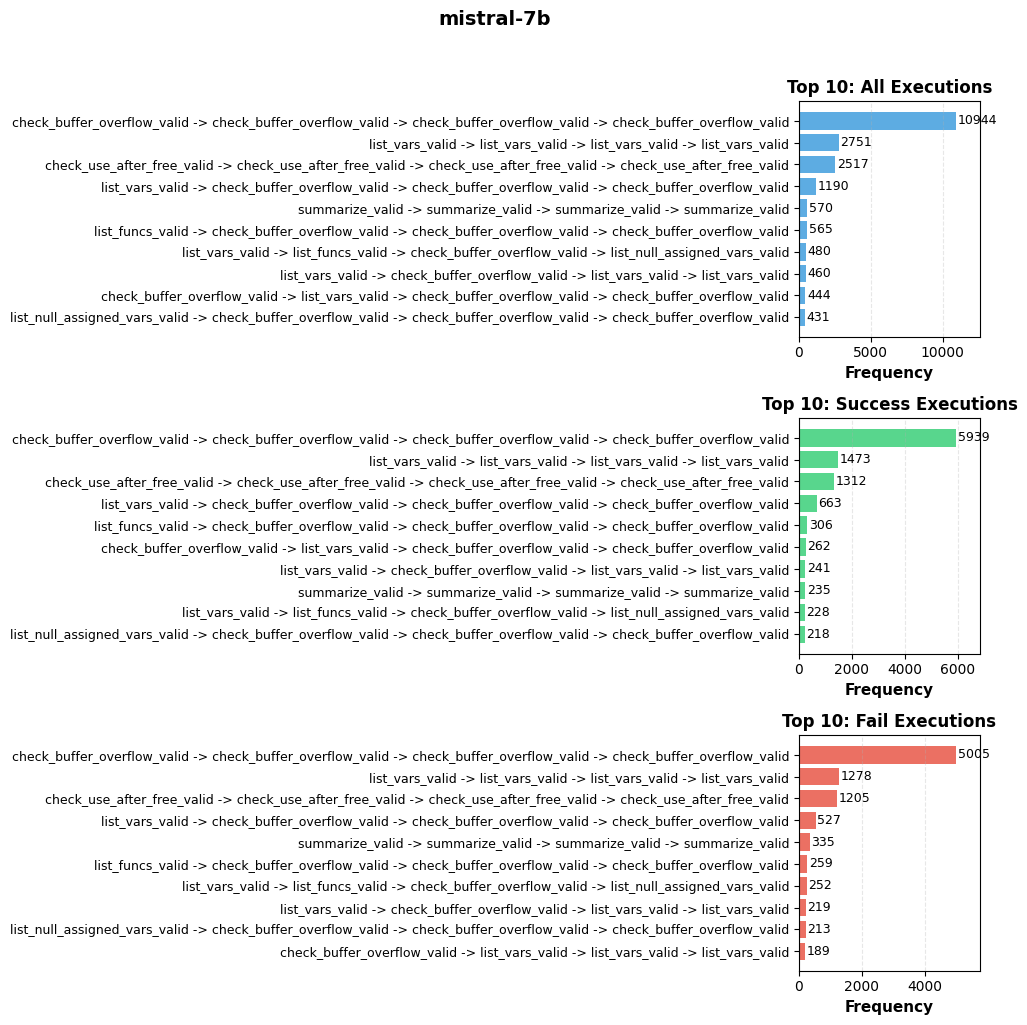

In [128]:
# Visualize Top 10 patterns separately for all/success/fail executions


for model in models:
    print(f"\n{'='*100}")
    print(f"Model: {model}")
    print(f"{'='*100}\n")
    
    # Load the three counters
    all_n_grams = get_n_grams_for_all_executions(model, with_validity=True)
    success_n_grams = get_n_grams_for_success_executions(model, with_validity=True)
    fail_n_grams = get_n_grams_for_fail_executions(model, with_validity=True)
    
    all_counter = Counter(all_n_grams)
    success_counter = Counter(success_n_grams)
    fail_counter = Counter(fail_n_grams)
    
    # Get top 10 from each counter
    top_10_all = [(shorten_pattern(pattern), count) for pattern, count in all_counter.most_common(10)]
    top_10_success = [(shorten_pattern(pattern), count) for pattern, count in success_counter.most_common(10)]
    top_10_fail = [(shorten_pattern(pattern), count) for pattern, count in fail_counter.most_common(10)]
    
    # Create 3 subplots
    fig, axes = plt.subplots(3, 1, figsize=(10, 10))
    
    # Plot 1: All Executions
    patterns_all = [p[0] for p in top_10_all]
    counts_all = [p[1] for p in top_10_all]
    
    axes[0].barh(range(len(patterns_all)), counts_all, color='#3498db', alpha=0.8)
    axes[0].set_yticks(range(len(patterns_all)))
    axes[0].set_yticklabels(patterns_all, fontsize=9)
    axes[0].set_xlabel('Frequency', fontsize=11, fontweight='bold')
    axes[0].set_title('Top 10: All Executions', fontsize=12, fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3, linestyle='--')

    axes[0].set_xlim(0, max(counts_all)*1.15)
    
    # Add value labels
    for i, v in enumerate(counts_all):
        axes[0].text(v + max(counts_all)*0.01, i, str(v), va='center', fontsize=9)
    
    # Plot 2: Success Executions
    patterns_success = [p[0] for p in top_10_success]
    counts_success = [p[1] for p in top_10_success]
    
    axes[1].barh(range(len(patterns_success)), counts_success, color='#2ecc71', alpha=0.8)
    axes[1].set_yticks(range(len(patterns_success)))
    axes[1].set_yticklabels(patterns_success, fontsize=9)
    axes[1].set_xlabel('Frequency', fontsize=11, fontweight='bold')
    axes[1].set_title('Top 10: Success Executions', fontsize=12, fontweight='bold')
    axes[1].invert_yaxis()
    axes[1].grid(axis='x', alpha=0.3, linestyle='--')

    axes[1].set_xlim(0, max(counts_success)*1.15)
    
    # Add value labels
    for i, v in enumerate(counts_success):
        axes[1].text(v + max(counts_success)*0.01, i, str(v), va='center', fontsize=9)
    
    # Plot 3: Fail Executions
    patterns_fail = [p[0] for p in top_10_fail]
    counts_fail = [p[1] for p in top_10_fail]
    
    axes[2].barh(range(len(patterns_fail)), counts_fail, color='#e74c3c', alpha=0.8)
    axes[2].set_yticks(range(len(patterns_fail)))
    axes[2].set_yticklabels(patterns_fail, fontsize=9)
    axes[2].set_xlabel('Frequency', fontsize=11, fontweight='bold')
    axes[2].set_title('Top 10: Fail Executions', fontsize=12, fontweight='bold')
    axes[2].invert_yaxis()
    axes[2].grid(axis='x', alpha=0.3, linestyle='--')

    axes[2].set_xlim(0, max(counts_fail)*1.15)
    
    # Add value labels
    for i, v in enumerate(counts_fail):
        axes[2].text(v + max(counts_fail)*0.01, i, str(v), va='center', fontsize=9)
    
    # Overall title
    fig.suptitle(f'{model}', fontsize=14, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.show()

### Top-5 frequent high success/failing rate sequences


Model: gemma3-4b


Total 4-grams collected: 3443

Total 4-grams from successful executions: 1692

Total 4-grams from failed executions: 1751
TOP 5 PATTERNS WITH HIGHEST SUCCESS RATE
----------------------------------------------------------------------------------------------------
                                                                                         pattern  total  success  fail success_rate fail_rate
                    null_deref_valid -> null_deref_valid -> null_deref_valid -> null_deref_valid    111       78    33        70.3%     29.7%
             buffer_overflow_valid -> use_after_free_valid -> summarize_valid -> variables_valid     15       10     5        66.7%     33.3%
            buffer_overflow_valid -> variables_valid -> null_deref_valid -> use_after_free_valid     21       14     7        66.7%     33.3%
buffer_overflow_valid -> buffer_overflow_valid -> buffer_overflow_valid -> buffer_overflow_valid     83       55    28        66.3%     33.7%
      

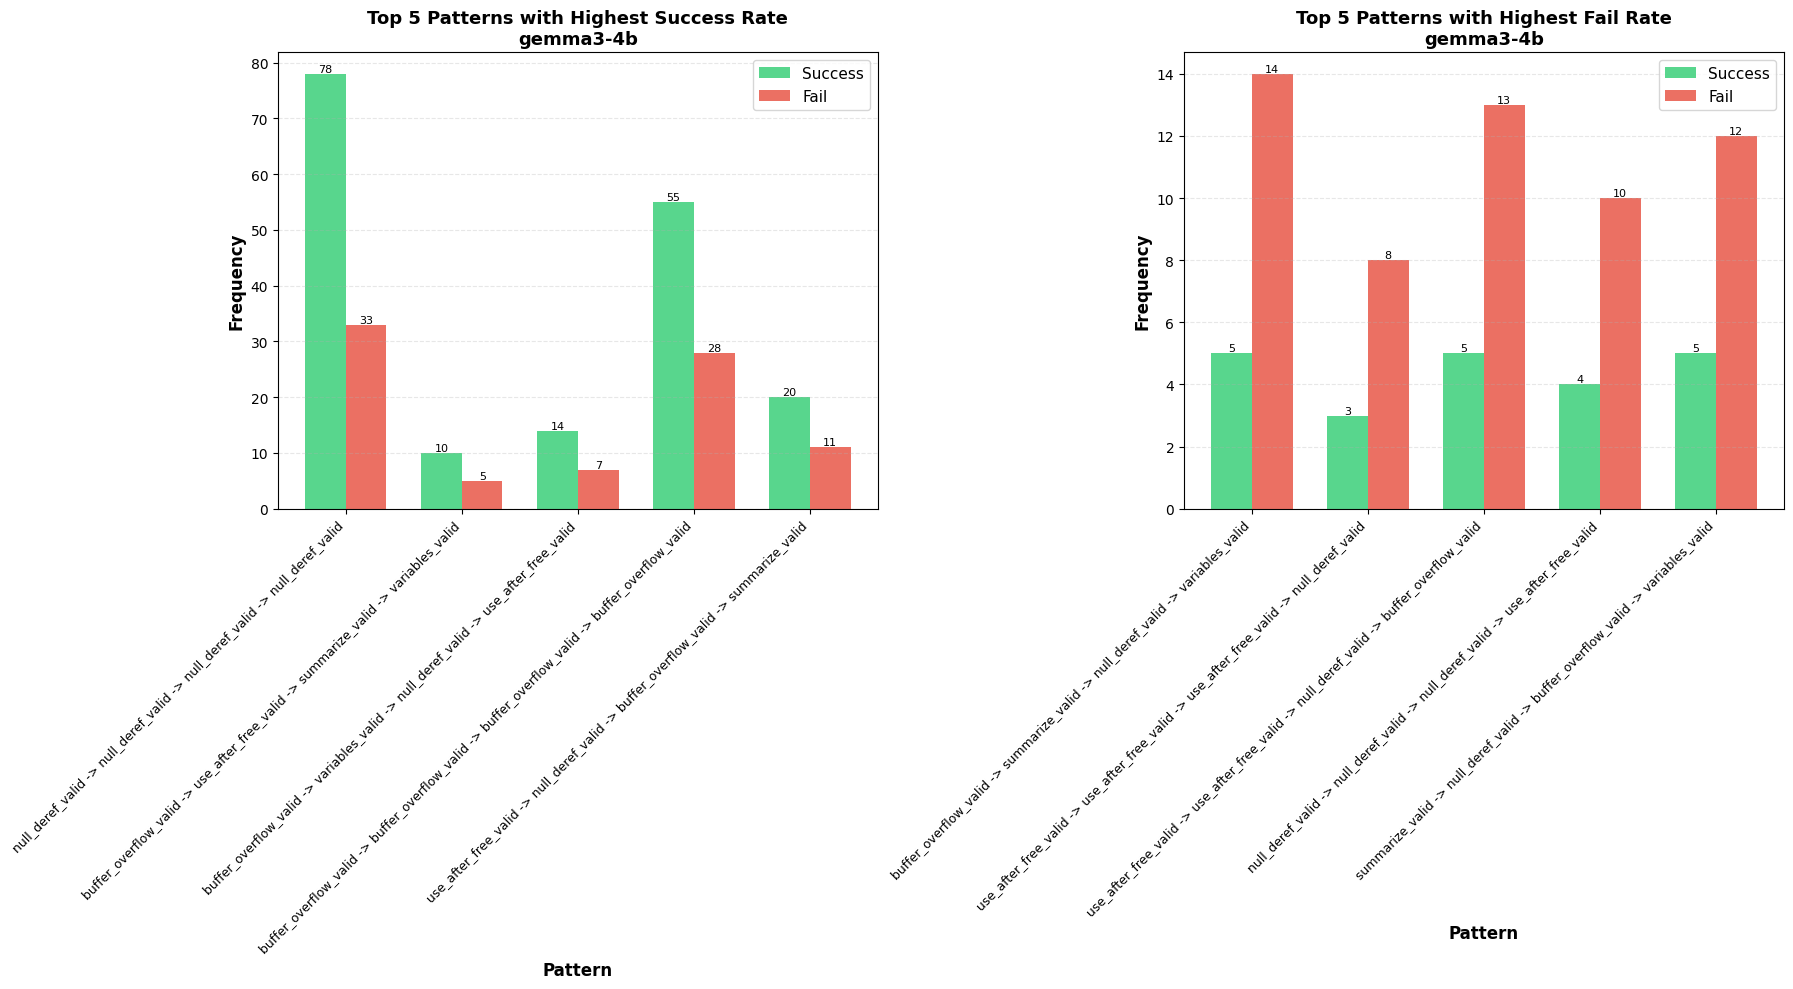


Model: llama3_1-8b


Total 4-grams collected: 58109

Total 4-grams from successful executions: 29663

Total 4-grams from failed executions: 28446
TOP 5 PATTERNS WITH HIGHEST SUCCESS RATE
----------------------------------------------------------------------------------------------------
                                                                              pattern  total  success  fail success_rate fail_rate
   variables_valid -> null_assigned_vars_valid -> freed_vars_valid -> functions_valid     14       13     1        92.9%      7.1%
functions_valid -> freed_vars_valid -> buffer_overflow_valid -> buffer_overflow_valid     13       11     2        84.6%     15.4%
   summarize_valid -> null_deref_valid -> functions_valid -> null_assigned_vars_valid     17       14     3        82.4%     17.6%
     freed_vars_valid -> null_deref_valid -> buffer_overflow_valid -> variables_valid     11        9     2        81.8%     18.2%
  summarize_valid -> freed_vars_valid -> null_deref_vali

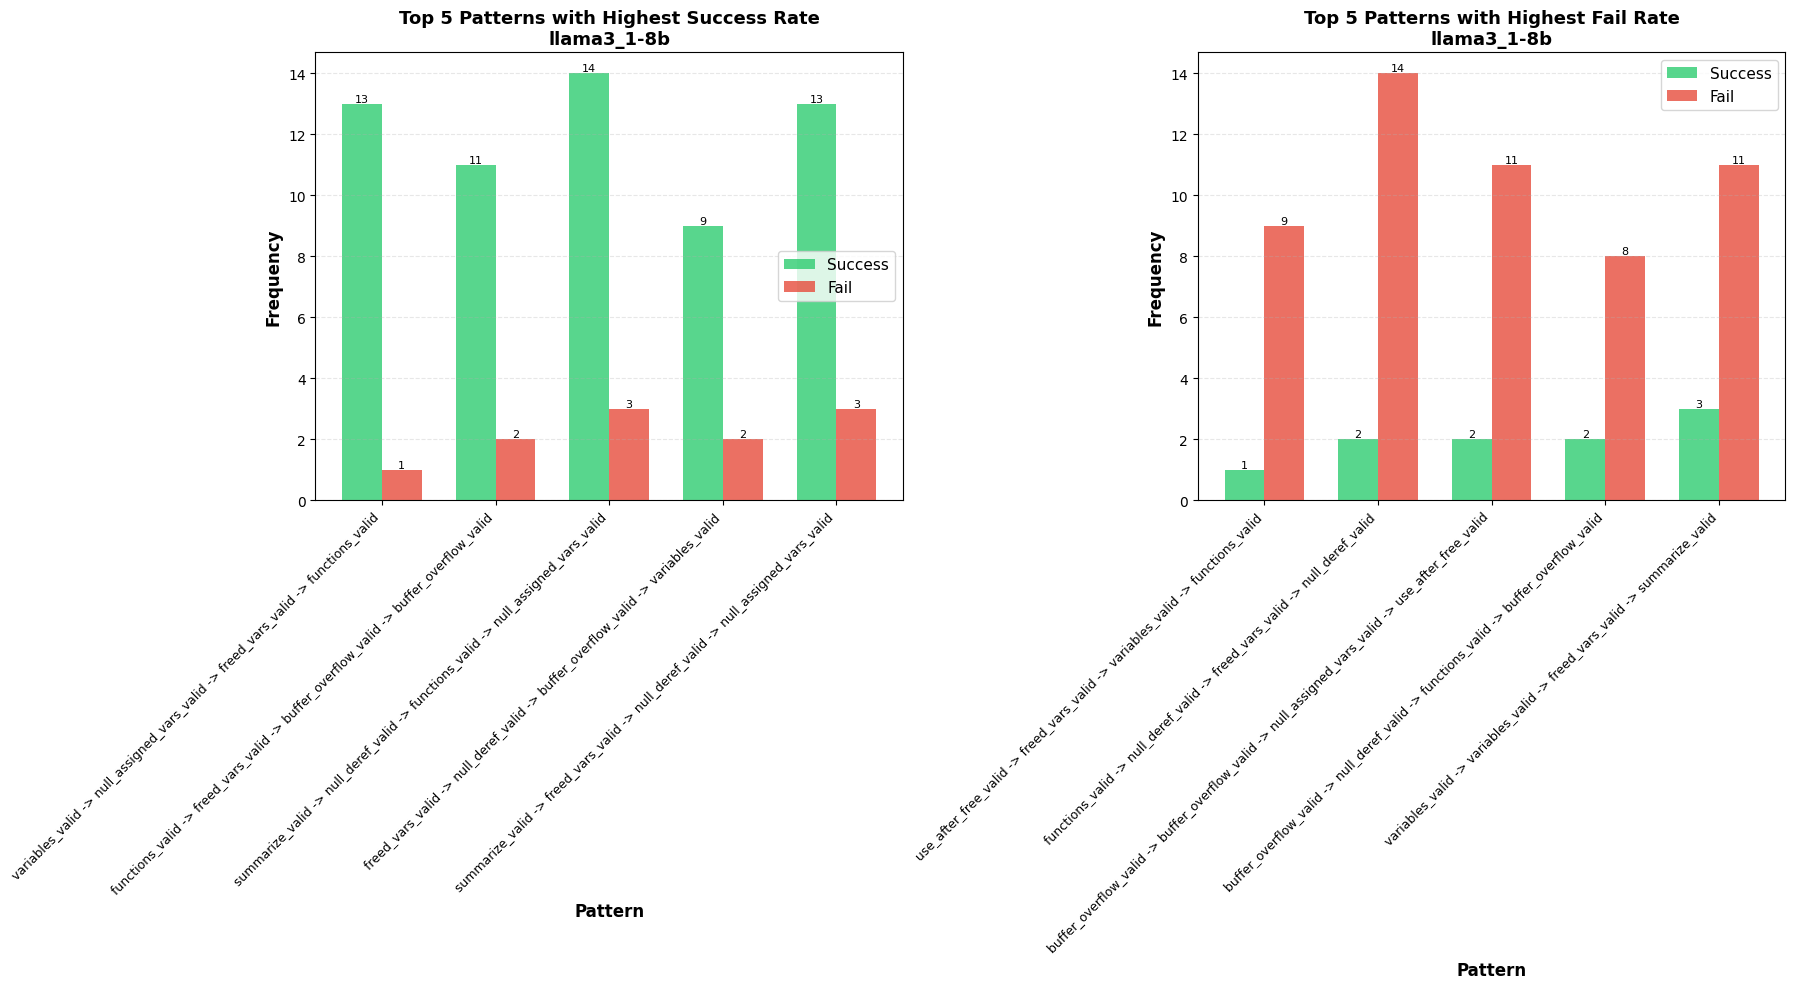


Model: llama3_2-3b


Total 4-grams collected: 23413

Total 4-grams from successful executions: 11643

Total 4-grams from failed executions: 11770
TOP 5 PATTERNS WITH HIGHEST SUCCESS RATE
----------------------------------------------------------------------------------------------------
                                                                              pattern  total  success  fail success_rate fail_rate
use_after_free_valid -> freed_vars_valid -> buffer_overflow_valid -> null_deref_valid     12       10     2        83.3%     16.7%
  freed_vars_valid -> summarize_valid -> null_deref_valid -> null_assigned_vars_valid     12       10     2        83.3%     16.7%
      variables_valid -> functions_valid -> freed_vars_valid -> buffer_overflow_valid     11        9     2        81.8%     18.2%
      functions_valid -> null_deref_valid -> use_after_free_valid -> freed_vars_valid     11        9     2        81.8%     18.2%
       null_deref_valid -> variables_valid -> variables_

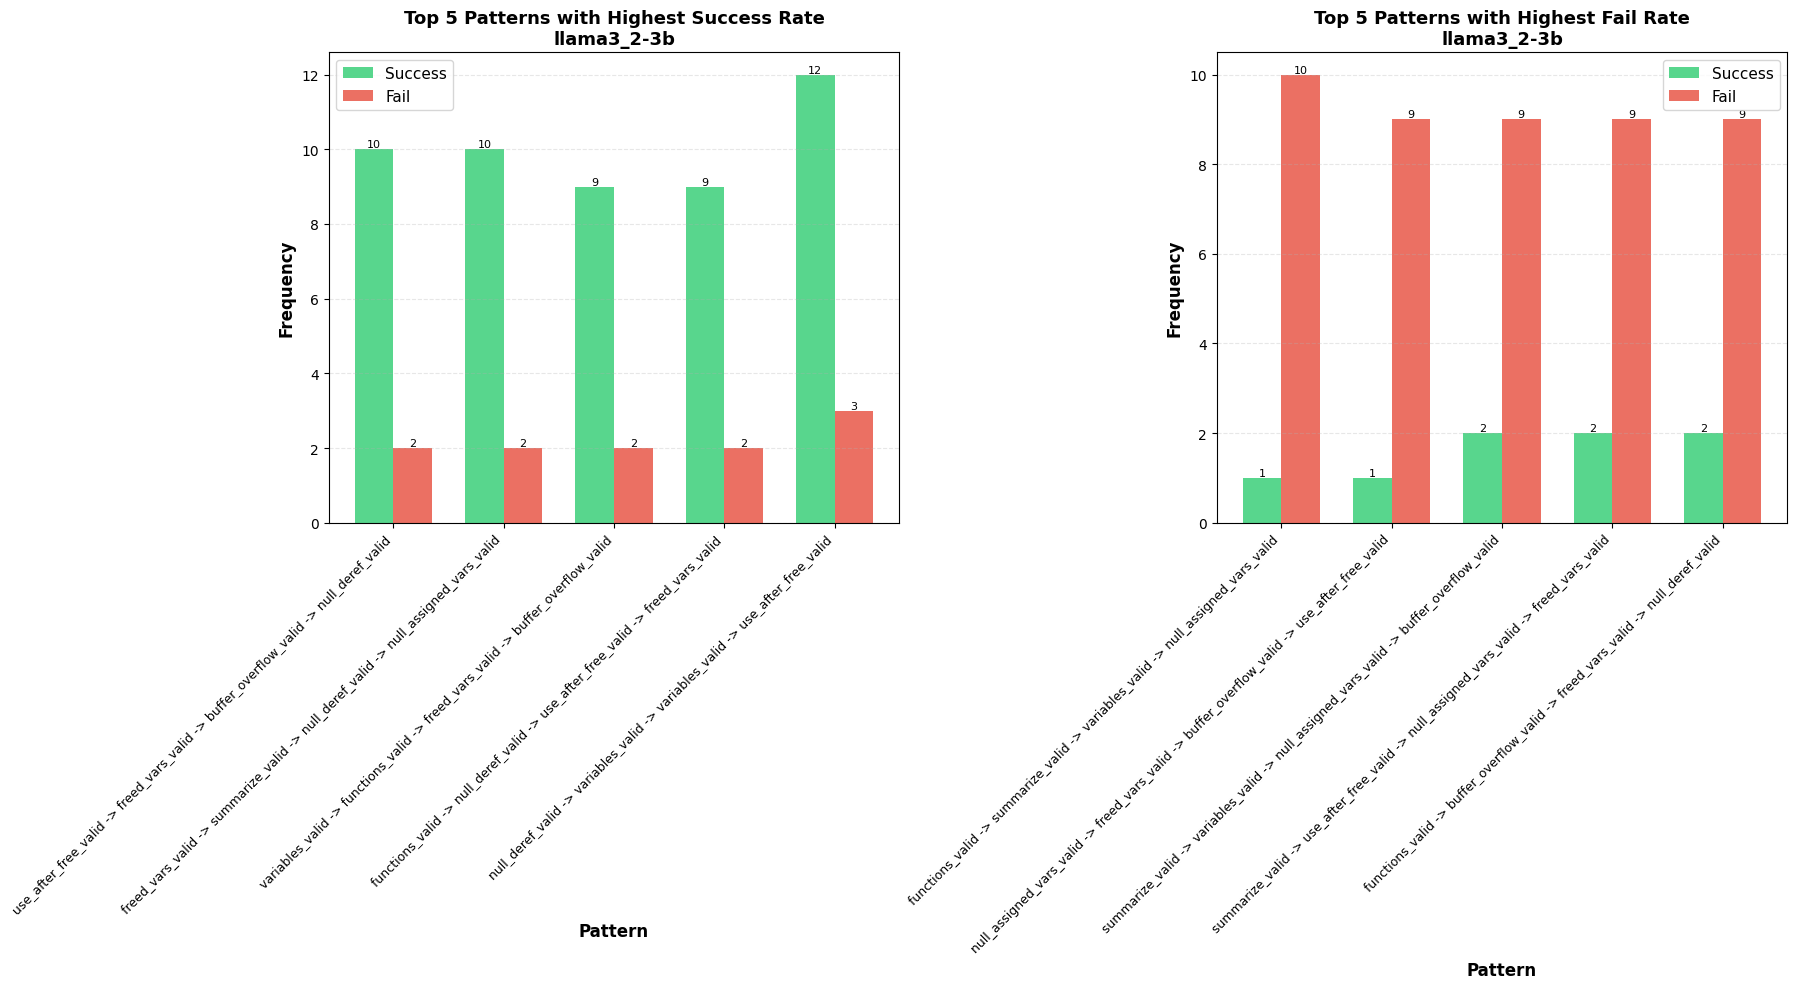


Model: mistral-7b


Total 4-grams collected: 64703

Total 4-grams from successful executions: 32938

Total 4-grams from failed executions: 31765
TOP 5 PATTERNS WITH HIGHEST SUCCESS RATE
----------------------------------------------------------------------------------------------------
                                                                                             pattern  total  success  fail success_rate fail_rate
buffer_overflow_valid -> buffer_overflow_invalid -> buffer_overflow_invalid -> buffer_overflow_valid     16       15     1        93.8%      6.2%
             freed_vars_valid -> use_after_free_valid -> null_assigned_vars_valid -> summarize_valid     10        9     1        90.0%     10.0%
                            functions_valid -> functions_valid -> functions_valid -> functions_valid     14       12     2        85.7%     14.3%
            freed_vars_valid -> use_after_free_valid -> null_assigned_vars_valid -> null_deref_valid     11        9     2      

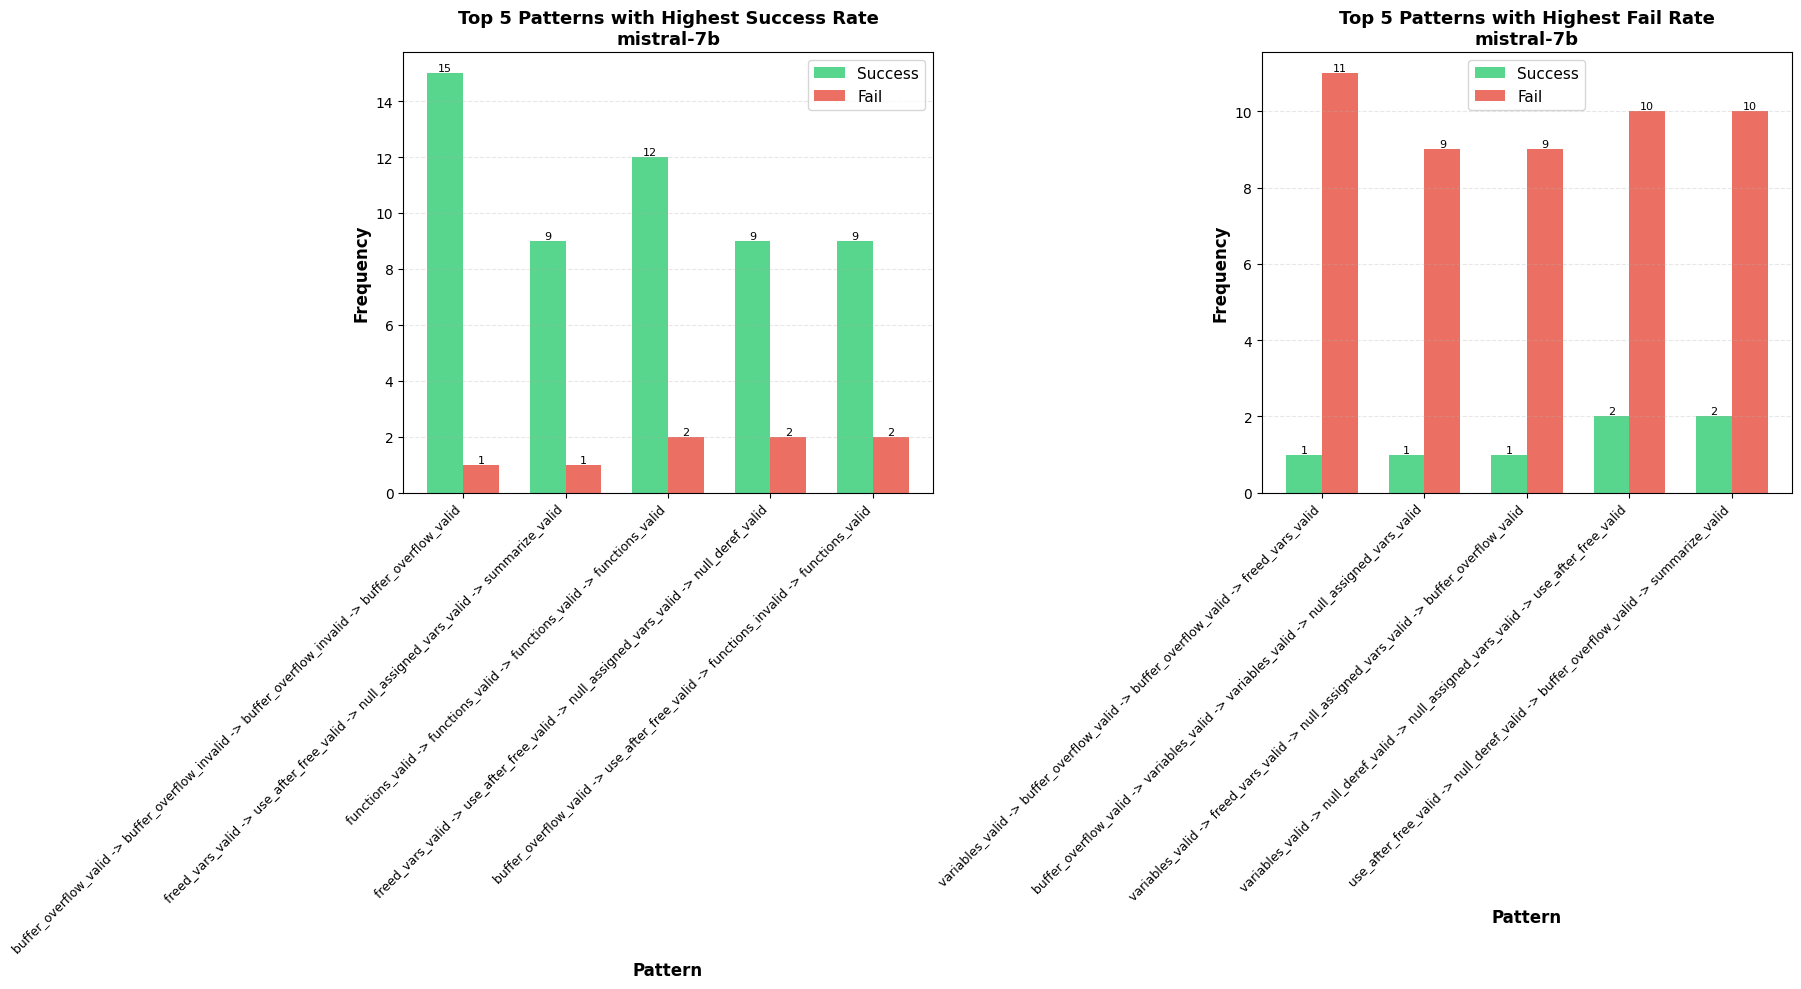

In [115]:
# Compare top patterns with highest success vs fail rates
# name_mapping = {
#     "summarize_code()_valid": "summarize_valid",
#     "list_variables()_valid": "list_vars_valid",
#     "list_functions()_valid": "list_funcs_valid",
#     "list_freed_variables()_valid": "list_freed_vars_valid",
#     "list_null_assigned_variables()_valid": "list_null_assigned_vars_valid",
#     "check_pattern(buffer_overflow)_valid": "check_buffer_overflow_valid",
#     "check_pattern(null_deref)_valid": "check_null_deref_valid",
#     "check_pattern(use_after_free)_valid": "check_use_after_free_valid",
#     "summarize_code()_invalid": "summarize_invalid",
#     "list_variables()_invalid": "list_vars_invalid",
#     "list_functions()_invalid": "list_funcs_invalid",
#     "list_freed_variables()_invalid": "list_freed_vars_invalid",
#     "list_null_assigned_variables()_invalid": "list_null_assigned_vars_invalid",
#     "check_pattern(buffer_overflow)_invalid": "check_buffer_overflow_invalid",
#     "check_pattern(null_deref)_invalid": "check_null_deref_invalid",
#     "check_pattern(use_after_free)_invalid": "check_use_after_free_invalid",
# }

name_mapping = {
    "summarize_code()": "summarize",
    "list_variables()": "variables",
    "list_functions()": "functions",
    "list_freed_variables()": "freed_vars",
    "list_null_assigned_variables()": "null_assigned_vars",
    "check_pattern(buffer_overflow)": "buffer_overflow",
    "check_pattern(null_deref)": "null_deref",
    "check_pattern(use_after_free)": "use_after_free",

    "summarize_code()_valid": "summarize_valid",
    "list_variables()_valid": "variables_valid",
    "list_functions()_valid": "functions_valid",
    "list_freed_variables()_valid": "freed_vars_valid",
    "list_null_assigned_variables()_valid": "null_assigned_vars_valid",
    "check_pattern(buffer_overflow)_valid": "buffer_overflow_valid",
    "check_pattern(null_deref)_valid": "null_deref_valid",
    "check_pattern(use_after_free)_valid": "use_after_free_valid",

    "summarize_code()_invalid": "summarize_invalid",
    "list_variables()_invalid": "variables_invalid",
    "list_functions()_invalid": "functions_invalid",
    "list_freed_variables()_invalid": "freed_vars_invalid",
    "list_null_assigned_variables()_invalid": "null_assigned_vars_invalid",
    "check_pattern(buffer_overflow)_invalid": "buffer_overflow_invalid",
    "check_pattern(null_deref)_invalid": "null_deref_invalid",
    "check_pattern(use_after_free)_invalid": "use_after_free_invalid",
}


def shorten_pattern(pattern_tuple):
    """Convert long function names to short versions"""
    return ' -> '.join([name_mapping.get(func, func) for func in pattern_tuple])

# For each benchmark and model combination
models = ['gemma3-4b', 'llama3_1-8b', 'llama3_2-3b', 'mistral-7b']

for model in models:
    print(f"\n{'='*100}")
    print(f"Model: {model}")
    print(f"{'='*100}\n")
    
    # Load the three counters
    # all_n_grams = get_n_grams_for_all_executions(model, with_validity=True)
    # success_n_grams = get_n_grams_for_success_executions(model, with_validity=True)
    # fail_n_grams = get_n_grams_for_fail_executions(model, with_validity=True)
    
    all_n_grams, success_n_grams, fail_n_grams = get_ngrams_for_executions(model, n, with_validity=with_validity)
    
    all_counter = Counter(all_n_grams)
    success_counter = Counter(success_n_grams)
    fail_counter = Counter(fail_n_grams)
    
    # Calculate success rate for all patterns that appear at least 5 times
    # (to filter out noise from very rare patterns)
    min_count = 10
    pattern_stats = []
    
    for pattern in all_counter:
        all_count = all_counter[pattern]
        if all_count >= min_count:
            success_count = success_counter[pattern]
            fail_count = fail_counter[pattern]
            success_rate = success_count / all_count if all_count > 0 else 0
            
            pattern_stats.append({
                'pattern': pattern,
                'all_count': all_count,
                'success_count': success_count,
                'fail_count': fail_count,
                'success_rate': success_rate,
                'fail_rate': 1 - success_rate
            })
    
    # Sort by success rate
    pattern_stats.sort(key=lambda x: x['success_rate'], reverse=True)
    
    # Get top 5 success patterns and top 5 fail patterns
    top_success = pattern_stats[:5]
    top_fail = pattern_stats[-5:][::-1]  # Reverse to show highest fail rate first
    
    # Display top success patterns
    print("TOP 5 PATTERNS WITH HIGHEST SUCCESS RATE")
    print("-" * 100)
    success_data = []
    for item in top_success:
        success_data.append({
            'pattern': shorten_pattern(item['pattern']),
            'total': item['all_count'],
            'success': item['success_count'],
            'fail': item['fail_count'],
            'success_rate': f"{item['success_rate']*100:.1f}%",
            'fail_rate': f"{item['fail_rate']*100:.1f}%"
        })
    
    success_df = pd.DataFrame(success_data)
    print(success_df.to_string(index=False))
    print()
    
    # Display top fail patterns
    print("TOP 5 PATTERNS WITH HIGHEST FAIL RATE")
    print("-" * 100)
    fail_data = []
    for item in top_fail:
        fail_data.append({
            'pattern': shorten_pattern(item['pattern']),
            'total': item['all_count'],
            'success': item['success_count'],
            'fail': item['fail_count'],
            'success_rate': f"{item['success_rate']*100:.1f}%",
            'fail_rate': f"{item['fail_rate']*100:.1f}%"
        })
    
    fail_df = pd.DataFrame(fail_data)
    print(fail_df.to_string(index=False))
    print()
    
    # Create comparison visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
    
    # Plot top success patterns
    patterns_success = [shorten_pattern(item['pattern']) for item in top_success]
    success_counts = [item['success_count'] for item in top_success]
    fail_counts_success = [item['fail_count'] for item in top_success]
    
    x1 = np.arange(len(patterns_success))
    width = 0.35
    
    bars1_s = ax1.bar(x1 - width/2, success_counts, width, label='Success', color='#2ecc71', alpha=0.8)
    bars1_f = ax1.bar(x1 + width/2, fail_counts_success, width, label='Fail', color='#e74c3c', alpha=0.8)
    
    ax1.set_xlabel('Pattern', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax1.set_title(f'Top 5 Patterns with Highest Success Rate\n{model}', fontsize=13, fontweight='bold')
    ax1.set_xticks(x1)
    ax1.set_xticklabels(patterns_success, rotation=45, ha='right', fontsize=9)
    ax1.legend(fontsize=11)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels
    for bars in [bars1_s, bars1_f]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax1.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}',
                        ha='center', va='bottom', fontsize=8)
    
    # Plot top fail patterns
    patterns_fail = [shorten_pattern(item['pattern']) for item in top_fail]
    success_counts_fail = [item['success_count'] for item in top_fail]
    fail_counts = [item['fail_count'] for item in top_fail]
    
    x2 = np.arange(len(patterns_fail))
    
    bars2_s = ax2.bar(x2 - width/2, success_counts_fail, width, label='Success', color='#2ecc71', alpha=0.8)
    bars2_f = ax2.bar(x2 + width/2, fail_counts, width, label='Fail', color='#e74c3c', alpha=0.8)
    
    ax2.set_xlabel('Pattern', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax2.set_title(f'Top 5 Patterns with Highest Fail Rate\n{model}', fontsize=13, fontweight='bold')
    ax2.set_xticks(x2)
    ax2.set_xticklabels(patterns_fail, rotation=45, ha='right', fontsize=9)
    ax2.legend(fontsize=11)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels
    for bars in [bars2_s, bars2_f]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax2.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}',
                        ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()


Model: gemma3-4b


Total 4-grams collected: 3762

Total 4-grams collected: 1692

Total 4-grams collected: 2070
1. CORRELATION ANALYSIS
----------------------------------------------------------------------------------------------------
Pearson Correlation: -1.0000 (p-value: 0.0000e+00)
Spearman Correlation: -1.0000 (p-value: 0.0000e+00)

Note: Since success_rate + fail_rate = 1, they are perfectly negatively correlated by definition.

2. STATISTICAL DIFFERENCE TESTS
----------------------------------------------------------------------------------------------------
Chi-Square Test (Top 20 patterns):
  Chi-square statistic: 56.8557
  p-value: 1.2031e-05
  Degrees of freedom: 19
  Interpretation: Patterns have significantly different success/fail distributions

3. PAIRWISE COMPARISONS
----------------------------------------------------------------------------------------------------

Top 5 Success Patterns:

  Pattern: check_null_deref -> check_null_deref -> check_null_deref -> check_n

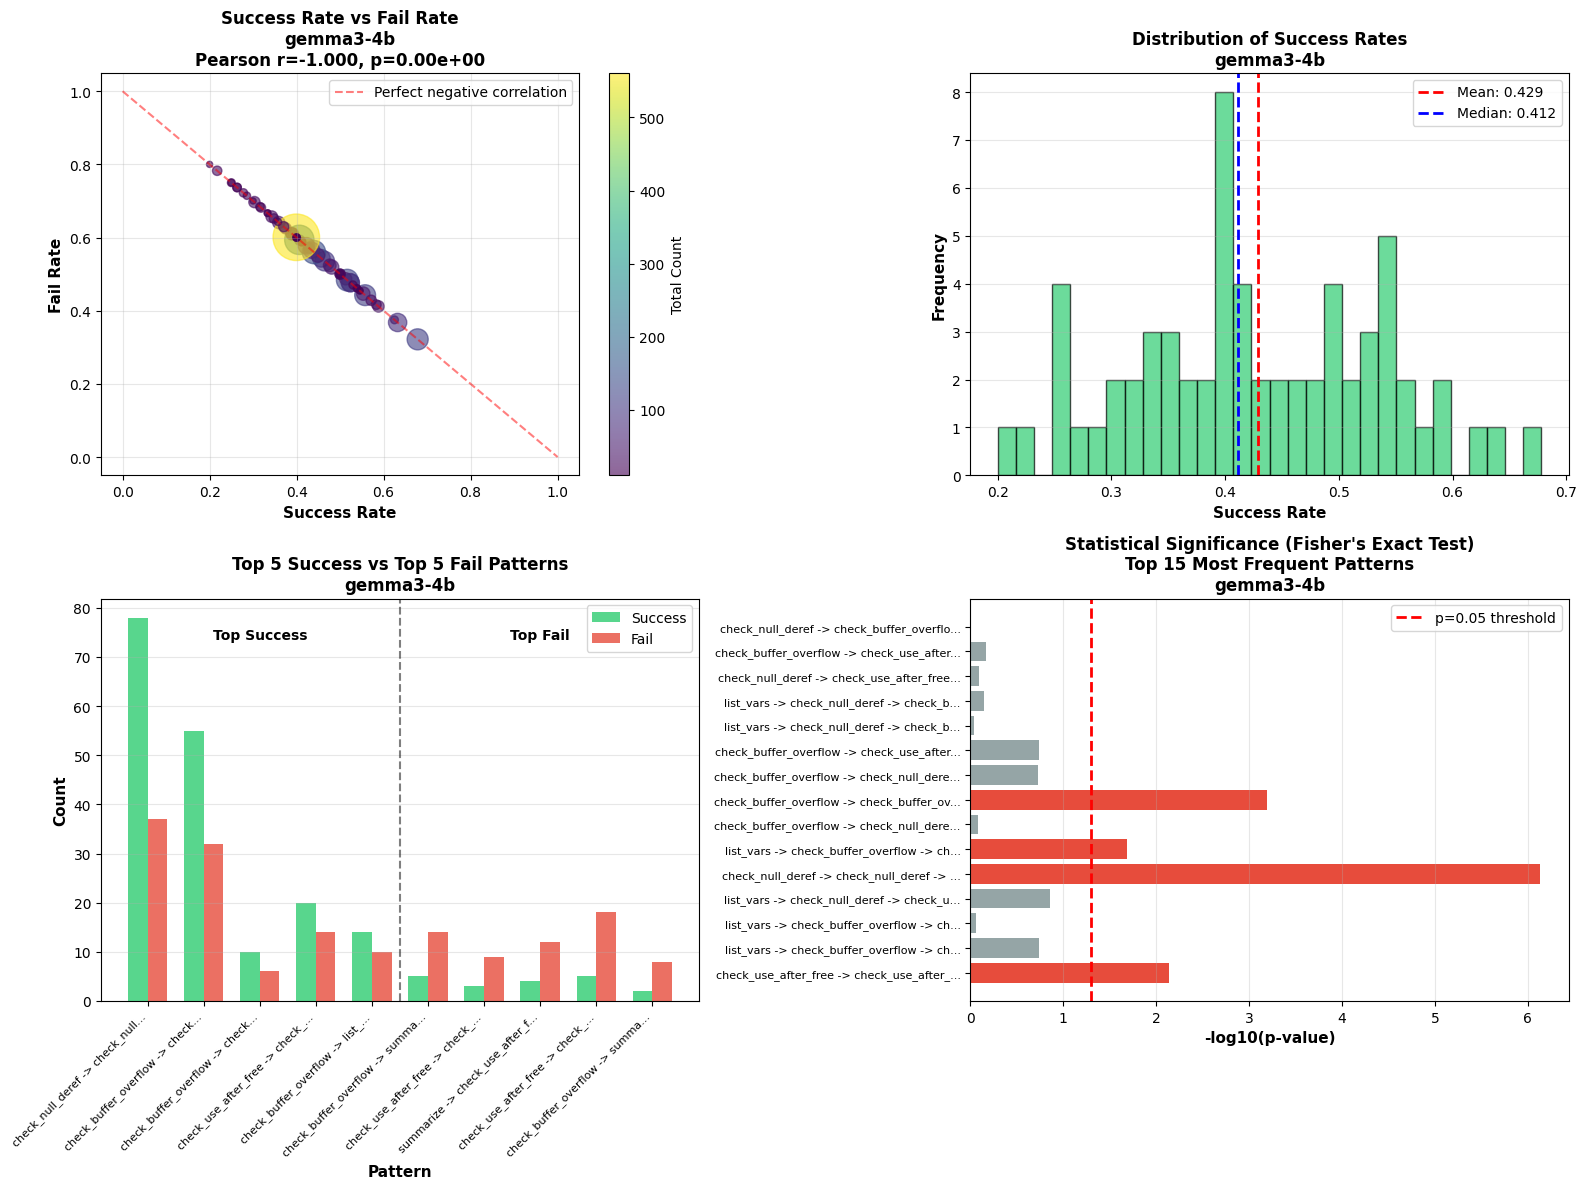




Model: llama3_1-8b


Total 4-grams collected: 60551

Total 4-grams collected: 29663

Total 4-grams collected: 30888
1. CORRELATION ANALYSIS
----------------------------------------------------------------------------------------------------
Pearson Correlation: -1.0000 (p-value: 0.0000e+00)
Spearman Correlation: -1.0000 (p-value: 0.0000e+00)

Note: Since success_rate + fail_rate = 1, they are perfectly negatively correlated by definition.

2. STATISTICAL DIFFERENCE TESTS
----------------------------------------------------------------------------------------------------
Chi-Square Test (Top 20 patterns):
  Chi-square statistic: 88.7777
  p-value: 5.4578e-11
  Degrees of freedom: 19
  Interpretation: Patterns have significantly different success/fail distributions

3. PAIRWISE COMPARISONS
----------------------------------------------------------------------------------------------------

Top 5 Success Patterns:

  Pattern: list_funcs -> list_freed_vars -> check_buffer_overflow -> ch

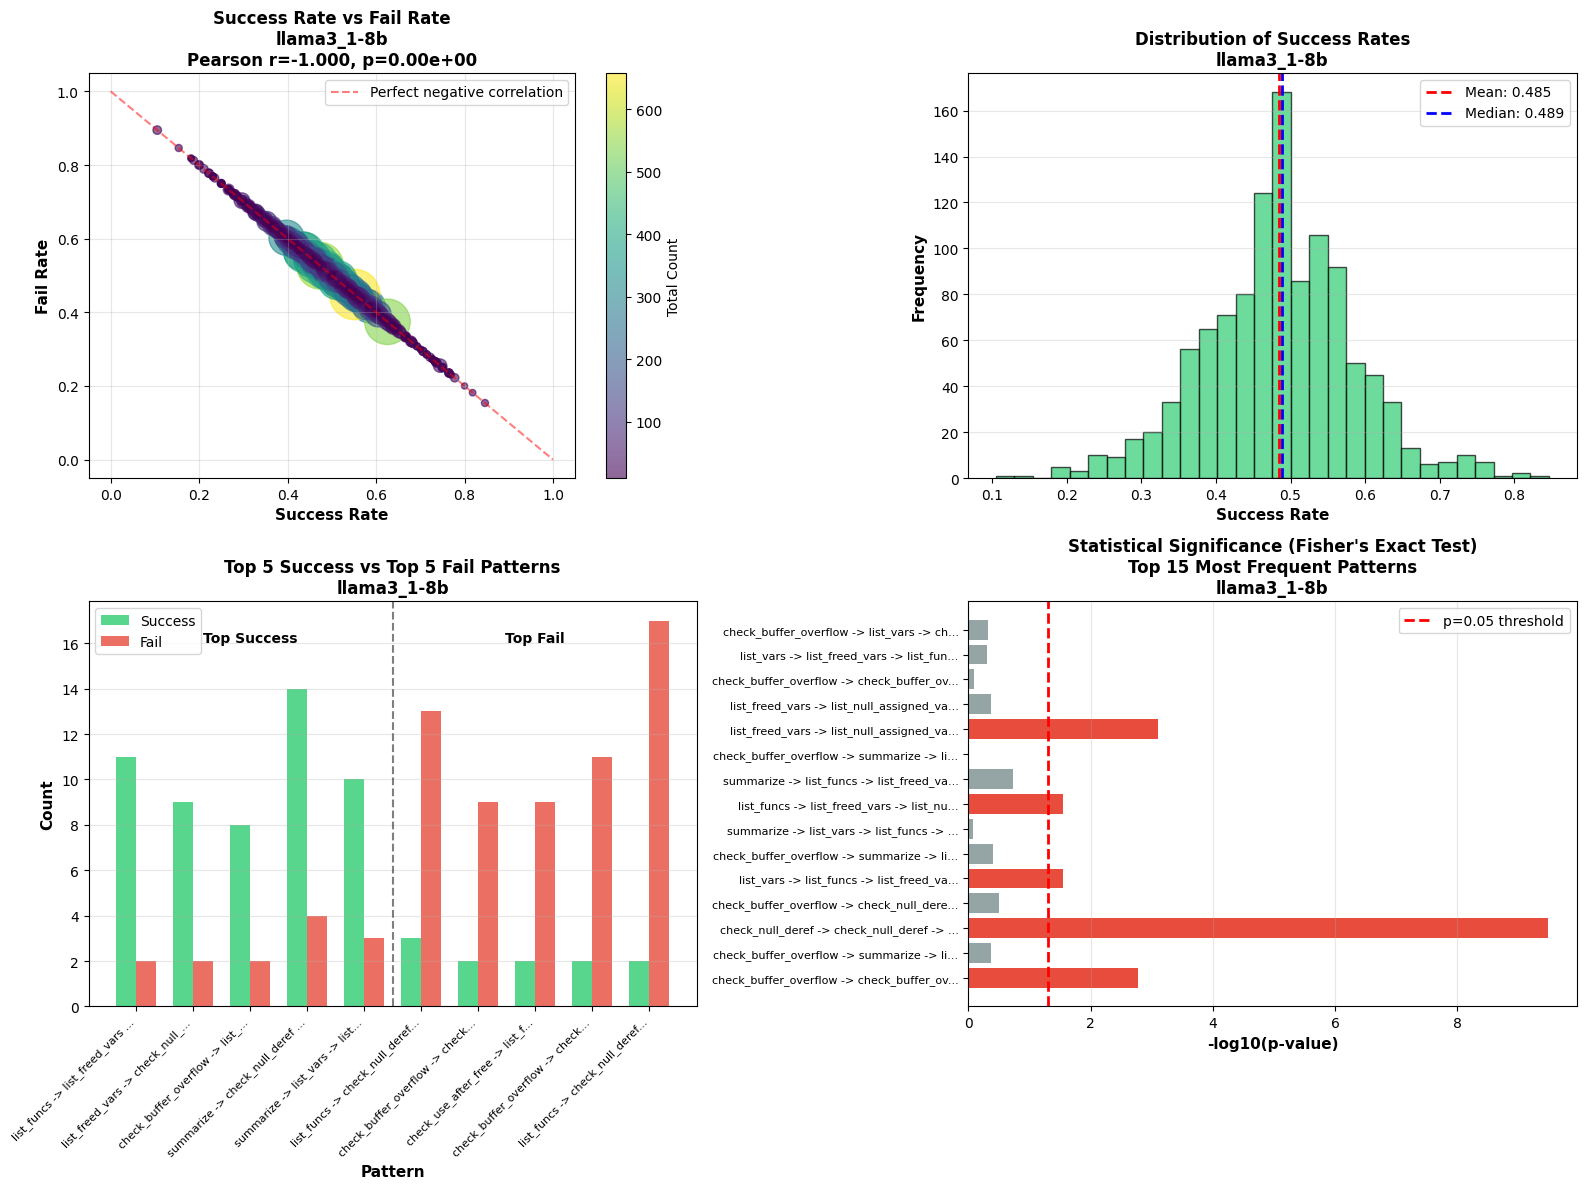




Model: llama3_2-3b


Total 4-grams collected: 25771

Total 4-grams collected: 11643

Total 4-grams collected: 14128
1. CORRELATION ANALYSIS
----------------------------------------------------------------------------------------------------
Pearson Correlation: -1.0000 (p-value: 0.0000e+00)
Spearman Correlation: -1.0000 (p-value: 0.0000e+00)

Note: Since success_rate + fail_rate = 1, they are perfectly negatively correlated by definition.

2. STATISTICAL DIFFERENCE TESTS
----------------------------------------------------------------------------------------------------
Chi-Square Test (Top 20 patterns):
  Chi-square statistic: 25.0069
  p-value: 1.6032e-01
  Degrees of freedom: 19
  Interpretation: No significant difference in distributions

3. PAIRWISE COMPARISONS
----------------------------------------------------------------------------------------------------

Top 5 Success Patterns:

  Pattern: summarize -> check_buffer_overflow -> check_null_deref -> list_funcs
    Success R

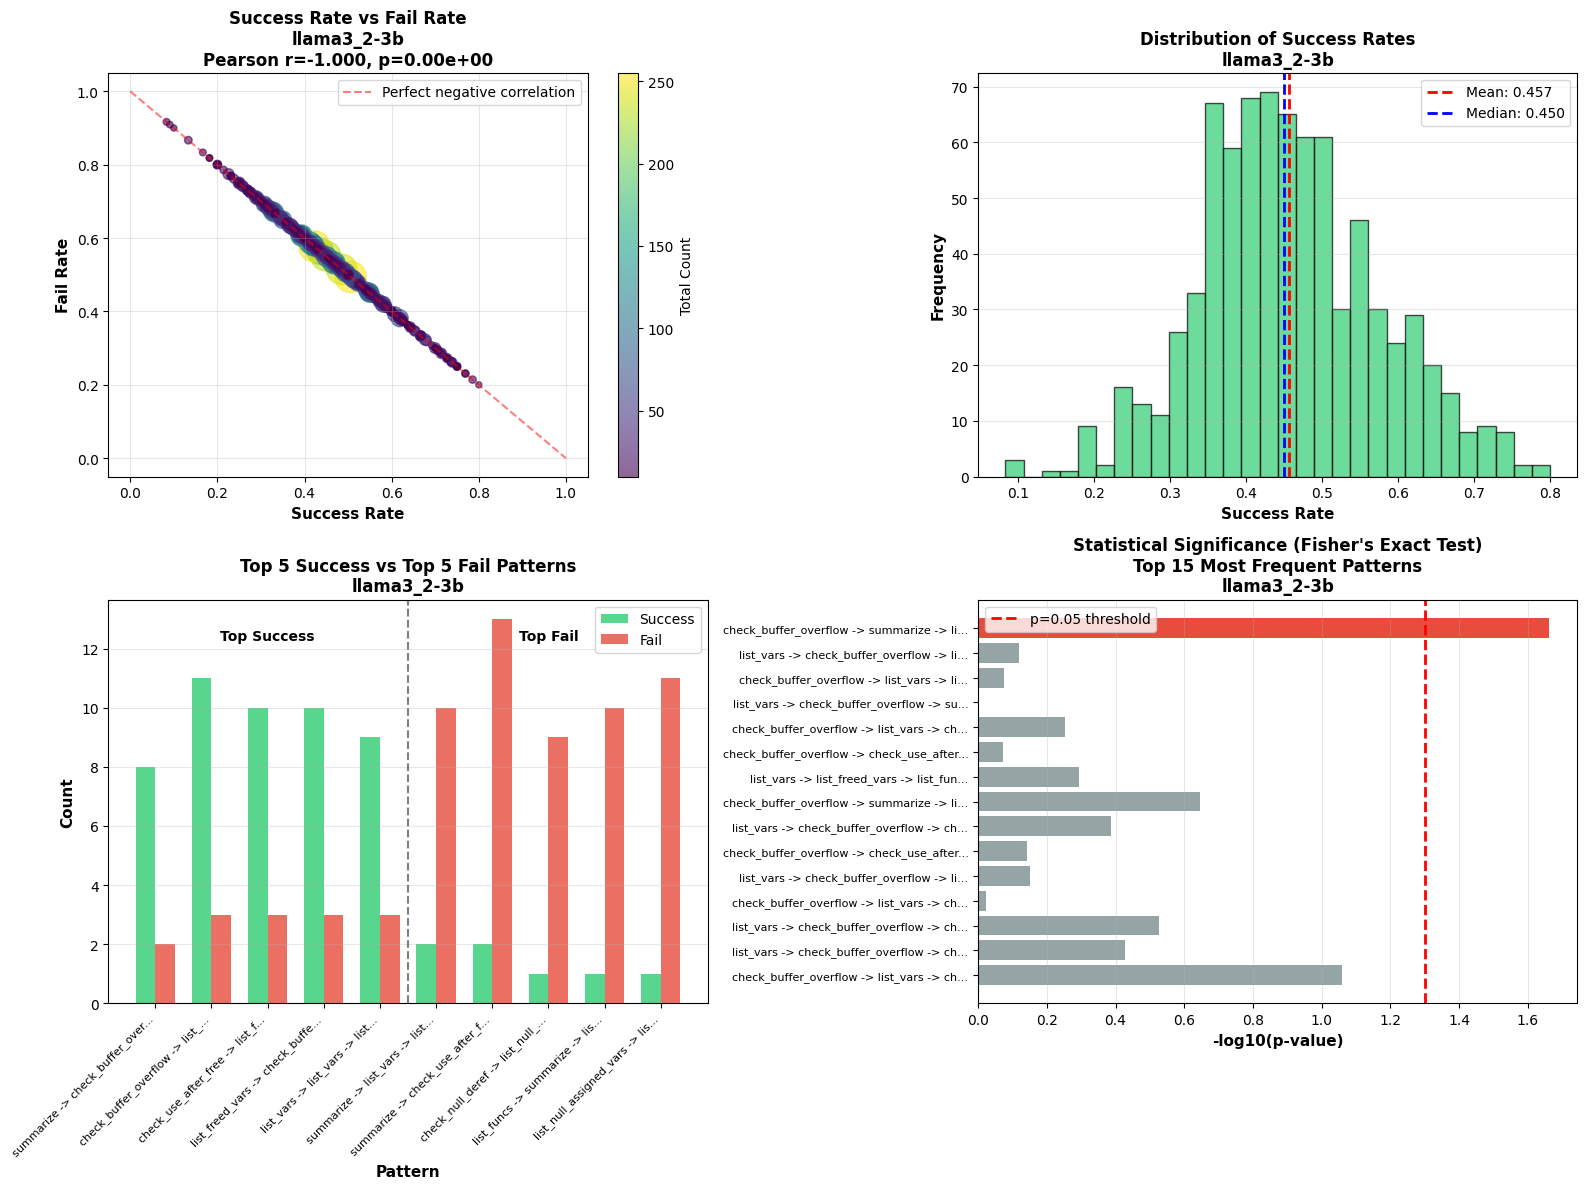




Model: mistral-7b


Total 4-grams collected: 66709

Total 4-grams collected: 34718

Total 4-grams collected: 31991
1. CORRELATION ANALYSIS
----------------------------------------------------------------------------------------------------
Pearson Correlation: -1.0000 (p-value: 0.0000e+00)
Spearman Correlation: -1.0000 (p-value: 0.0000e+00)

Note: Since success_rate + fail_rate = 1, they are perfectly negatively correlated by definition.

2. STATISTICAL DIFFERENCE TESTS
----------------------------------------------------------------------------------------------------
Chi-Square Test (Top 20 patterns):
  Chi-square statistic: 68.8964
  p-value: 1.4019e-07
  Degrees of freedom: 19
  Interpretation: Patterns have significantly different success/fail distributions

3. PAIRWISE COMPARISONS
----------------------------------------------------------------------------------------------------

Top 5 Success Patterns:

  Pattern: summarize -> summarize -> list_funcs -> list_vars
    Success

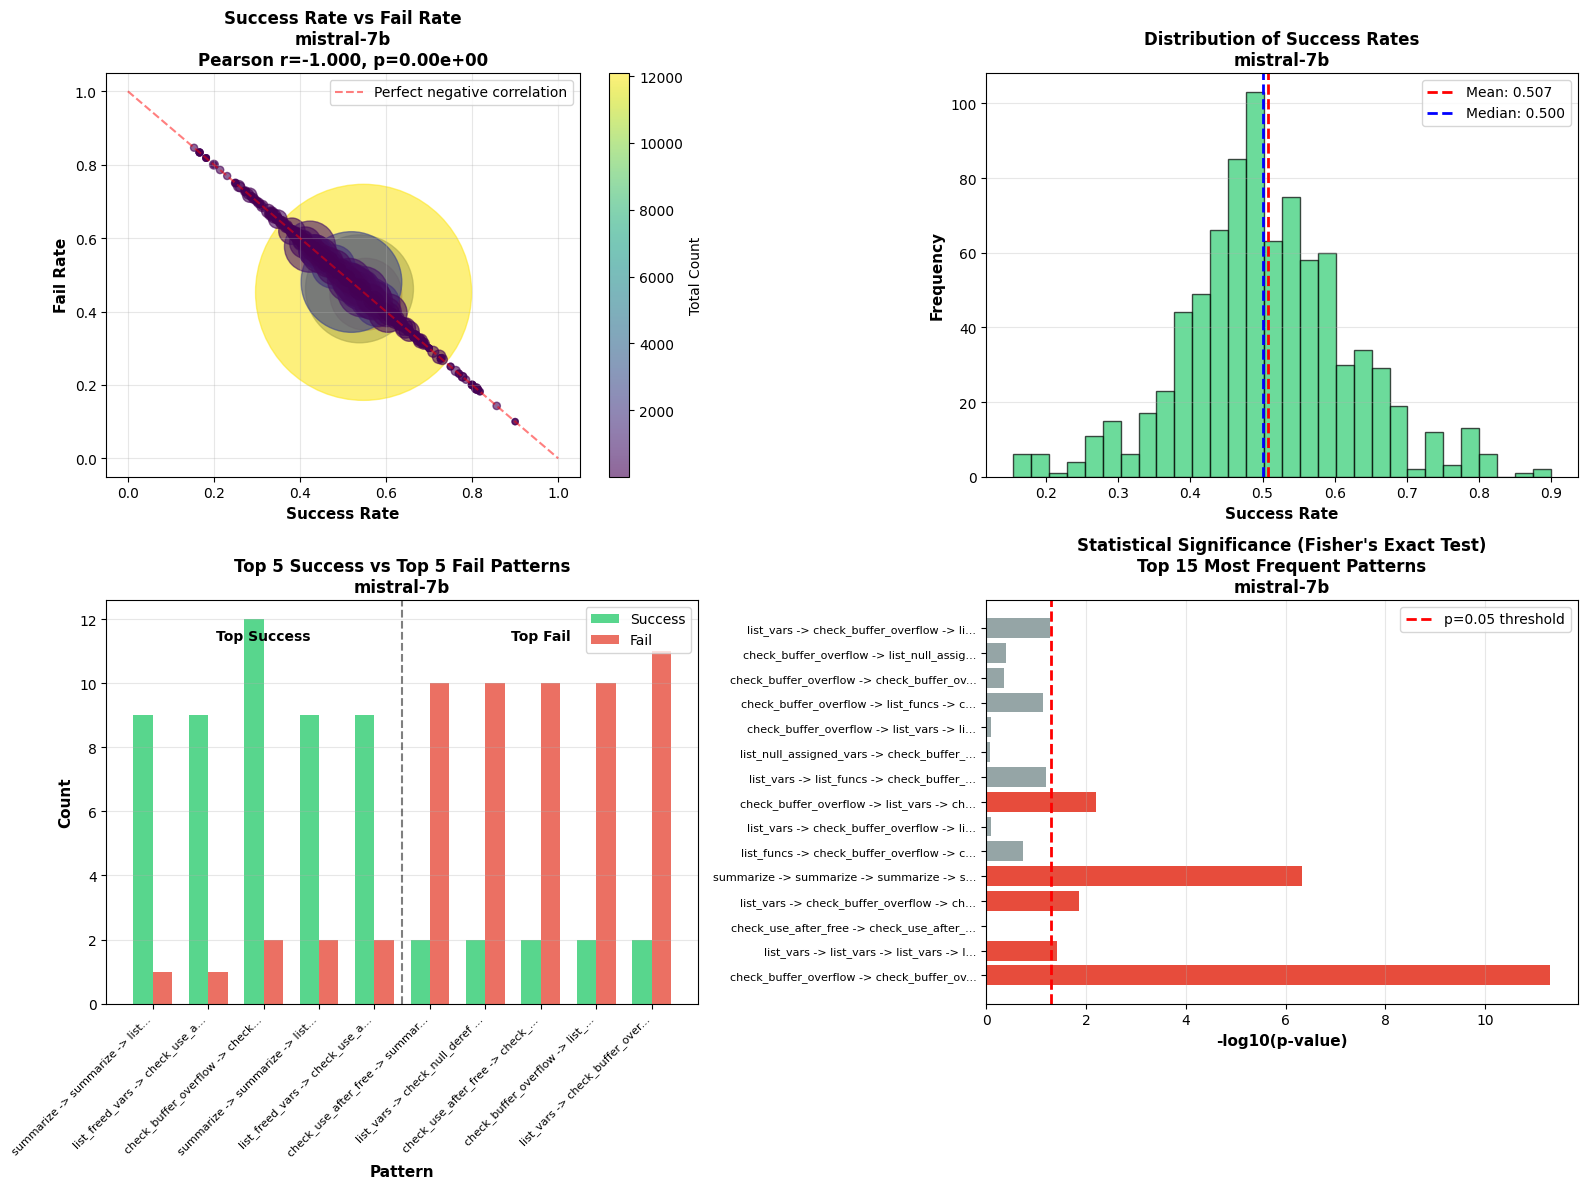

In [10]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import pearsonr, spearmanr, chi2_contingency
import matplotlib.pyplot as plt
# import seaborn as sns
from collections import Counter

name_mapping = {
    "summarize_code()": "summarize",
    "list_variables()": "list_vars",
    "list_functions()": "list_funcs",
    "list_freed_variables()": "list_freed_vars",
    "list_null_assigned_variables()": "list_null_assigned_vars",
    "check_pattern(buffer_overflow)": "check_buffer_overflow",
    "check_pattern(null_deref)": "check_null_deref",
    "check_pattern(use_after_free)": "check_use_after_free",
}


def shorten_pattern(pattern_tuple):
    """Convert long function names to short versions"""
    return ' -> '.join([name_mapping.get(func, func) for func in pattern_tuple])


# For each model
models = ['gemma3-4b', 'llama3_1-8b', 'llama3_2-3b', 'mistral-7b']

for model in models:
    print(f"\n{'='*100}")
    print(f"Model: {model}")
    print(f"{'='*100}\n")
    
    # Load the three counters
    all_4grams = get_4grams_for_all_executions(model)
    success_4grams = get_4grams_for_success_executions(model)
    fail_4grams = get_4grams_for_fail_executions(model)
    
    all_counter = Counter(all_4grams)
    success_counter = Counter(success_4grams)
    fail_counter = Counter(fail_4grams)
    
    # Filter patterns with minimum count
    min_count = 10
    patterns_data = []
    
    for pattern in all_counter:
        all_count = all_counter[pattern]
        if all_count >= min_count:
            success_count = success_counter[pattern]
            fail_count = fail_counter[pattern]
            success_rate = success_count / all_count
            fail_rate = fail_count / all_count
            
            patterns_data.append({
                'pattern': pattern,
                'pattern_short': shorten_pattern(pattern),
                'all_count': all_count,
                'success_count': success_count,
                'fail_count': fail_count,
                'success_rate': success_rate,
                'fail_rate': fail_rate
            })
    
    df = pd.DataFrame(patterns_data)
    
    # ============================================================
    # 1. CORRELATION ANALYSIS
    # ============================================================
    print("1. CORRELATION ANALYSIS")
    print("-" * 100)
    
    # Pearson correlation (linear relationship)
    pearson_corr, pearson_p = pearsonr(df['success_rate'], df['fail_rate'])
    print(f"Pearson Correlation: {pearson_corr:.4f} (p-value: {pearson_p:.4e})")
    
    # Spearman correlation (monotonic relationship)
    spearman_corr, spearman_p = spearmanr(df['success_rate'], df['fail_rate'])
    print(f"Spearman Correlation: {spearman_corr:.4f} (p-value: {spearman_p:.4e})")
    
    # Note: Success rate + Fail rate = 1, so they should be perfectly negatively correlated
    print(f"\nNote: Since success_rate + fail_rate = 1, they are perfectly negatively correlated by definition.")
    print()
    
    # ============================================================
    # 2. STATISTICAL DIFFERENCE TESTS
    # ============================================================
    print("2. STATISTICAL DIFFERENCE TESTS")
    print("-" * 100)
    
    # Prepare data for chi-square test of independence
    # We'll test if success/fail distribution is significantly different across patterns
    
    # Create contingency table for top patterns
    top_n = 20  # Test top 20 patterns
    df_top = df.nlargest(top_n, 'all_count')
    
    contingency_table = df_top[['success_count', 'fail_count']].values
    
    # Chi-square test
    chi2, chi2_p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-Square Test (Top {top_n} patterns):")
    print(f"  Chi-square statistic: {chi2:.4f}")
    print(f"  p-value: {chi2_p:.4e}")
    print(f"  Degrees of freedom: {dof}")
    print(f"  Interpretation: {'Patterns have significantly different success/fail distributions' if chi2_p < 0.05 else 'No significant difference in distributions'}")
    print()
    
    # ============================================================
    # 3. PAIRWISE COMPARISON OF TOP SUCCESS vs TOP FAIL PATTERNS
    # ============================================================
    print("3. PAIRWISE COMPARISONS")
    print("-" * 100)
    
    # Get top success and fail patterns
    df_sorted = df.sort_values('success_rate', ascending=False)
    top_success = df_sorted.head(5)
    top_fail = df_sorted.tail(5)
    
    print("\nTop 5 Success Patterns:")
    for idx, row in top_success.iterrows():
        # Fisher's exact test for each pattern
        # Compare this pattern against all others
        pattern_success = row['success_count']
        pattern_fail = row['fail_count']
        other_success = df['success_count'].sum() - pattern_success
        other_fail = df['fail_count'].sum() - pattern_fail
        
        contingency = [[pattern_success, pattern_fail],
                       [other_success, other_fail]]
        
        oddsratio, fisher_p = stats.fisher_exact(contingency)
        
        print(f"\n  Pattern: {row['pattern_short']}")
        print(f"    Success Rate: {row['success_rate']*100:.1f}%")
        print(f"    Fisher's Exact Test p-value: {fisher_p:.4e}")
        print(f"    Odds Ratio: {oddsratio:.4f}")
        print(f"    Significance: {'***' if fisher_p < 0.001 else '**' if fisher_p < 0.01 else '*' if fisher_p < 0.05 else 'ns'}")
    
    print("\n\nTop 5 Fail Patterns:")
    for idx, row in top_fail.iterrows():
        pattern_success = row['success_count']
        pattern_fail = row['fail_count']
        other_success = df['success_count'].sum() - pattern_success
        other_fail = df['fail_count'].sum() - pattern_fail
        
        contingency = [[pattern_success, pattern_fail],
                       [other_success, other_fail]]
        
        oddsratio, fisher_p = stats.fisher_exact(contingency)
        
        print(f"\n  Pattern: {row['pattern_short']}")
        print(f"    Fail Rate: {row['fail_rate']*100:.1f}%")
        print(f"    Fisher's Exact Test p-value: {fisher_p:.4e}")
        print(f"    Odds Ratio: {oddsratio:.4f}")
        print(f"    Significance: {'***' if fisher_p < 0.001 else '**' if fisher_p < 0.01 else '*' if fisher_p < 0.05 else 'ns'}")
    
    print("\n" + "="*100)
    
    # ============================================================
    # 4. VISUALIZATION
    # ============================================================
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Scatter plot of success rate vs fail rate
    ax1 = axes[0, 0]
    scatter = ax1.scatter(df['success_rate'], df['fail_rate'], 
                         s=df['all_count']*2, alpha=0.6, c=df['all_count'],
                         cmap='viridis')
    ax1.plot([0, 1], [1, 0], 'r--', alpha=0.5, label='Perfect negative correlation')
    ax1.set_xlabel('Success Rate', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Fail Rate', fontsize=11, fontweight='bold')
    ax1.set_title(f'Success Rate vs Fail Rate\n{model}\nPearson r={pearson_corr:.3f}, p={pearson_p:.2e}', 
                  fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)
    plt.colorbar(scatter, ax=ax1, label='Total Count')
    
    # Plot 2: Distribution of success rates
    ax2 = axes[0, 1]
    ax2.hist(df['success_rate'], bins=30, alpha=0.7, color='#2ecc71', edgecolor='black')
    ax2.axvline(df['success_rate'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {df["success_rate"].mean():.3f}')
    ax2.axvline(df['success_rate'].median(), color='blue', linestyle='--', 
                linewidth=2, label=f'Median: {df["success_rate"].median():.3f}')
    ax2.set_xlabel('Success Rate', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax2.set_title(f'Distribution of Success Rates\n{model}', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3, axis='y')
    
    # Plot 3: Top success vs fail patterns comparison
    ax3 = axes[1, 0]
    combined = pd.concat([
        top_success.assign(group='Top Success'),
        top_fail.assign(group='Top Fail')
    ])
    
    x = np.arange(len(combined))
    width = 0.35
    
    bars1 = ax3.bar(x - width/2, combined['success_count'], width, 
                    label='Success', color='#2ecc71', alpha=0.8)
    bars2 = ax3.bar(x + width/2, combined['fail_count'], width, 
                    label='Fail', color='#e74c3c', alpha=0.8)
    
    ax3.set_xlabel('Pattern', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Count', fontsize=11, fontweight='bold')
    ax3.set_title(f'Top 5 Success vs Top 5 Fail Patterns\n{model}', 
                  fontsize=12, fontweight='bold')
    ax3.set_xticks(x)
    labels = [p[:30] + '...' if len(p) > 30 else p for p in combined['pattern_short']]
    ax3.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
    ax3.legend()
    ax3.grid(alpha=0.3, axis='y')
    
    # Add group separators
    ax3.axvline(4.5, color='black', linestyle='--', alpha=0.5)
    ax3.text(2, ax3.get_ylim()[1]*0.9, 'Top Success', ha='center', fontweight='bold')
    ax3.text(7, ax3.get_ylim()[1]*0.9, 'Top Fail', ha='center', fontweight='bold')
    
    # Plot 4: P-value heatmap for top patterns
    ax4 = axes[1, 1]
    
    # Calculate p-values for all patterns
    p_values = []
    pattern_labels = []
    
    for idx, row in df.nlargest(15, 'all_count').iterrows():
        pattern_success = row['success_count']
        pattern_fail = row['fail_count']
        other_success = df['success_count'].sum() - pattern_success
        other_fail = df['fail_count'].sum() - pattern_fail
        
        contingency = [[pattern_success, pattern_fail],
                       [other_success, other_fail]]
        
        _, fisher_p = stats.fisher_exact(contingency)
        p_values.append(-np.log10(fisher_p))  # -log10(p-value) for better visualization
        label = row['pattern_short'][:40] + '...' if len(row['pattern_short']) > 40 else row['pattern_short']
        pattern_labels.append(label)
    
    y_pos = np.arange(len(p_values))
    bars = ax4.barh(y_pos, p_values, color=['#e74c3c' if p > -np.log10(0.05) else '#95a5a6' for p in p_values])
    ax4.set_yticks(y_pos)
    ax4.set_yticklabels(pattern_labels, fontsize=8)
    ax4.set_xlabel('-log10(p-value)', fontsize=11, fontweight='bold')
    ax4.set_title(f'Statistical Significance (Fisher\'s Exact Test)\nTop 15 Most Frequent Patterns\n{model}', 
                  fontsize=12, fontweight='bold')
    ax4.axvline(-np.log10(0.05), color='red', linestyle='--', linewidth=2, label='p=0.05 threshold')
    ax4.legend()
    ax4.grid(alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*100 + "\n")


Model: gemma3-4b


Total 4-grams collected: 3443

Total 4-grams from successful executions: 1692

Total 4-grams from failed executions: 1751
1. CORRELATION ANALYSIS
----------------------------------------------------------------------------------------------------
Pearson Correlation: -1.0000 (p-value: 0.0000e+00)
Spearman Correlation: -1.0000 (p-value: 0.0000e+00)

Note: Since success_rate + fail_rate = 1, they are perfectly negatively correlated by definition.

2. STATISTICAL DIFFERENCE TESTS
----------------------------------------------------------------------------------------------------
Chi-Square Test (Top 20 patterns):
  Chi-square statistic: 60.3302
  p-value: 3.4309e-06
  Degrees of freedom: 19
  Interpretation: Patterns have significantly different success/fail distributions

3. PAIRWISE COMPARISONS
----------------------------------------------------------------------------------------------------

Top 5 Success Patterns:

  Pattern: null_deref_valid -> null_deref_valid 

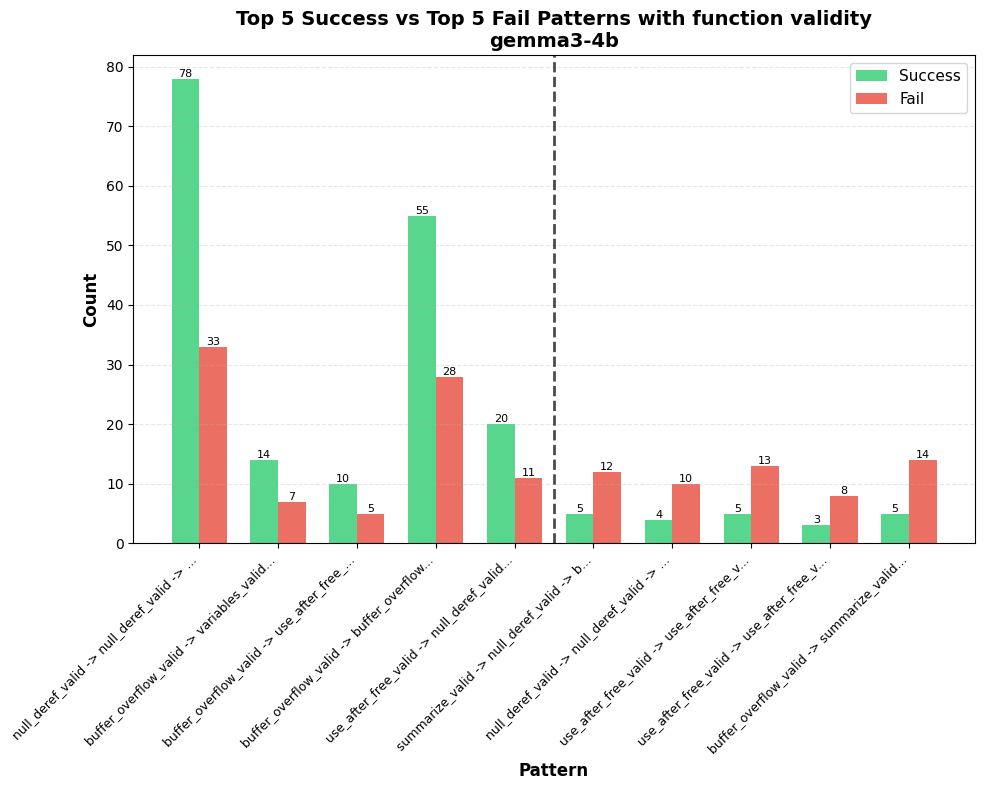




Model: llama3_1-8b


Total 4-grams collected: 58109

Total 4-grams from successful executions: 29663

Total 4-grams from failed executions: 28446
1. CORRELATION ANALYSIS
----------------------------------------------------------------------------------------------------
Pearson Correlation: -1.0000 (p-value: 0.0000e+00)
Spearman Correlation: -1.0000 (p-value: 0.0000e+00)

Note: Since success_rate + fail_rate = 1, they are perfectly negatively correlated by definition.

2. STATISTICAL DIFFERENCE TESTS
----------------------------------------------------------------------------------------------------
Chi-Square Test (Top 20 patterns):
  Chi-square statistic: 76.4825
  p-value: 7.4522e-09
  Degrees of freedom: 19
  Interpretation: Patterns have significantly different success/fail distributions

3. PAIRWISE COMPARISONS
----------------------------------------------------------------------------------------------------

Top 5 Success Patterns:

  Pattern: variables_valid -> null_assign

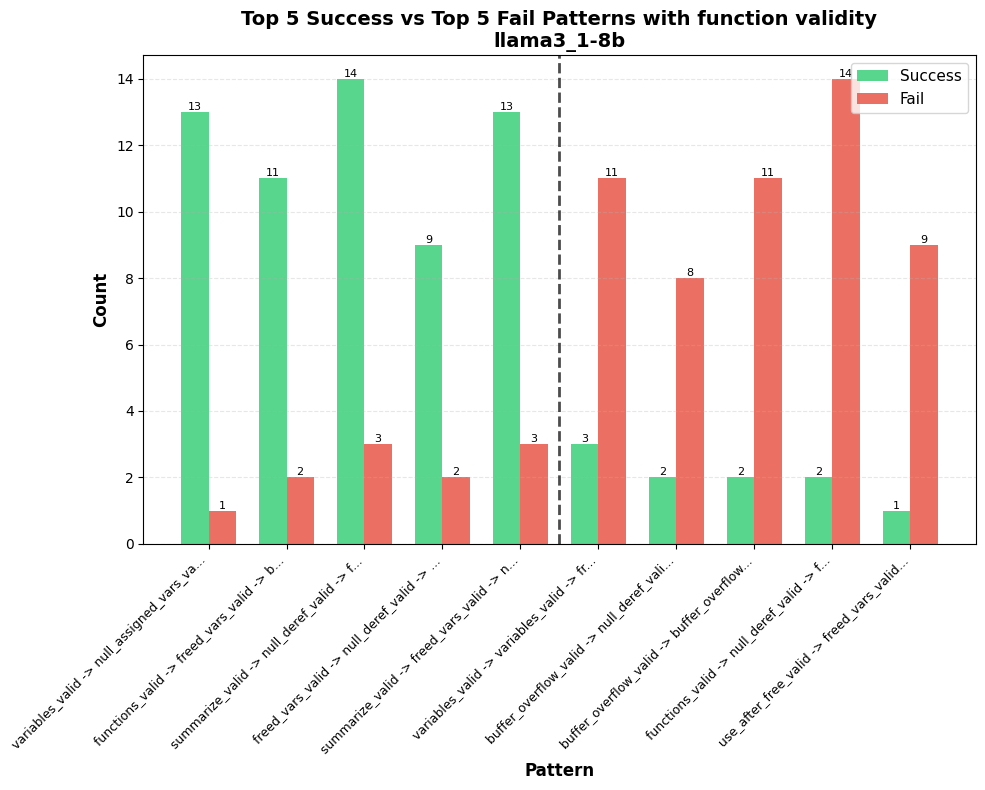




Model: llama3_2-3b


Total 4-grams collected: 23413

Total 4-grams from successful executions: 11643

Total 4-grams from failed executions: 11770
1. CORRELATION ANALYSIS
----------------------------------------------------------------------------------------------------
Pearson Correlation: -1.0000 (p-value: 0.0000e+00)
Spearman Correlation: -1.0000 (p-value: 0.0000e+00)

Note: Since success_rate + fail_rate = 1, they are perfectly negatively correlated by definition.

2. STATISTICAL DIFFERENCE TESTS
----------------------------------------------------------------------------------------------------
Chi-Square Test (Top 20 patterns):
  Chi-square statistic: 22.8531
  p-value: 2.4387e-01
  Degrees of freedom: 19
  Interpretation: No significant difference in distributions

3. PAIRWISE COMPARISONS
----------------------------------------------------------------------------------------------------

Top 5 Success Patterns:

  Pattern: use_after_free_valid -> freed_vars_valid -> buffer_o

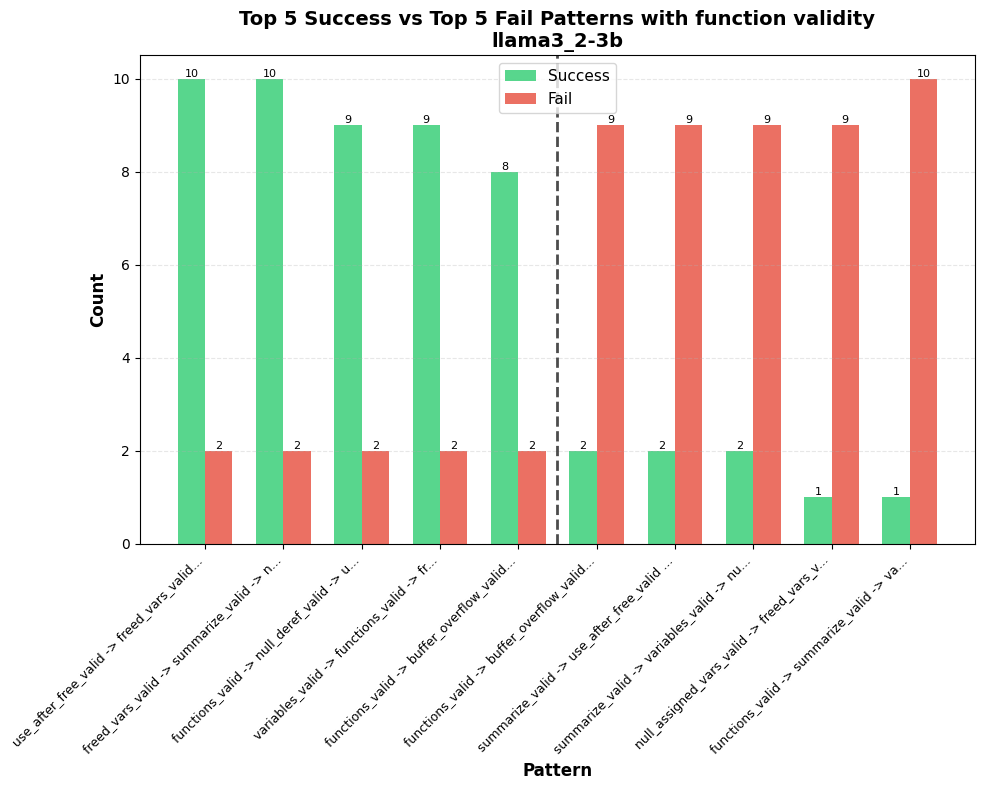




Model: mistral-7b


Total 4-grams collected: 64703

Total 4-grams from successful executions: 32938

Total 4-grams from failed executions: 31765
1. CORRELATION ANALYSIS
----------------------------------------------------------------------------------------------------
Pearson Correlation: -1.0000 (p-value: 0.0000e+00)
Spearman Correlation: -1.0000 (p-value: 0.0000e+00)

Note: Since success_rate + fail_rate = 1, they are perfectly negatively correlated by definition.

2. STATISTICAL DIFFERENCE TESTS
----------------------------------------------------------------------------------------------------
Chi-Square Test (Top 20 patterns):
  Chi-square statistic: 79.0092
  p-value: 2.7538e-09
  Degrees of freedom: 19
  Interpretation: Patterns have significantly different success/fail distributions

3. PAIRWISE COMPARISONS
----------------------------------------------------------------------------------------------------

Top 5 Success Patterns:

  Pattern: buffer_overflow_valid -> buffer

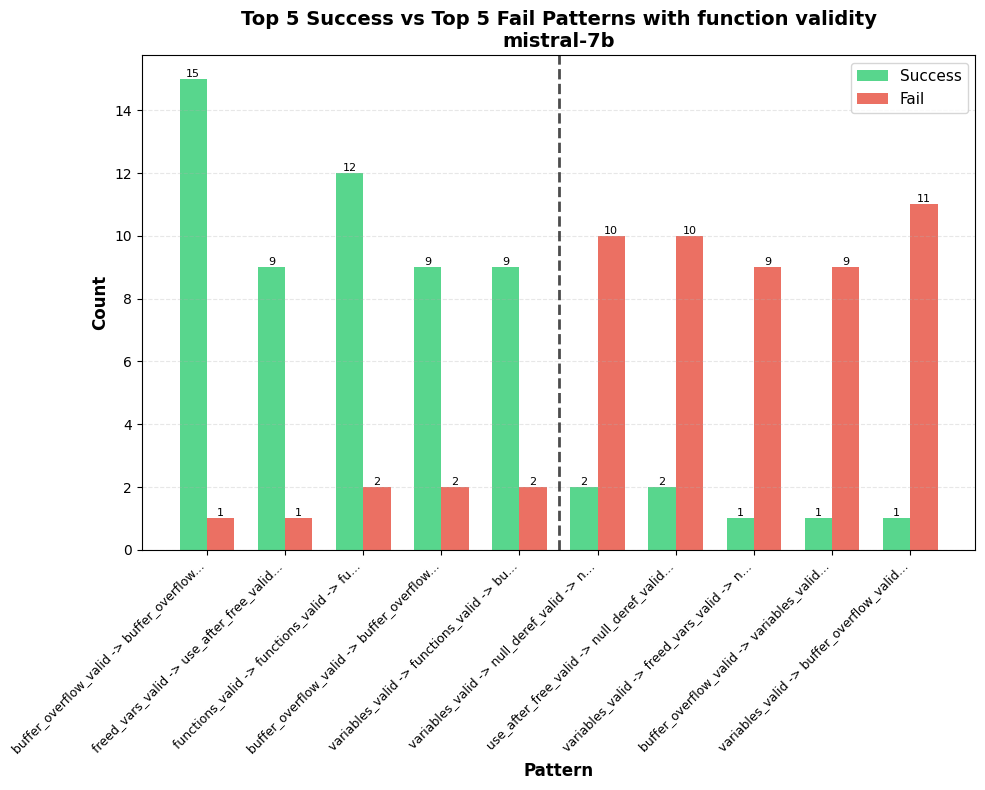

In [127]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import pearsonr, spearmanr, chi2_contingency
import matplotlib.pyplot as plt
from collections import Counter

name_mapping = {
    "summarize_code()": "summarize",
    "list_variables()": "variables",
    "list_functions()": "functions",
    "list_freed_variables()": "freed_vars",
    "list_null_assigned_variables()": "null_assigned_vars",
    "check_pattern(buffer_overflow)": "buffer_overflow",
    "check_pattern(null_deref)": "null_deref",
    "check_pattern(use_after_free)": "use_after_free",

    "summarize_code()_valid": "summarize_valid",
    "list_variables()_valid": "variables_valid",
    "list_functions()_valid": "functions_valid",
    "list_freed_variables()_valid": "freed_vars_valid",
    "list_null_assigned_variables()_valid": "null_assigned_vars_valid",
    "check_pattern(buffer_overflow)_valid": "buffer_overflow_valid",
    "check_pattern(null_deref)_valid": "null_deref_valid",
    "check_pattern(use_after_free)_valid": "use_after_free_valid",

    "summarize_code()_invalid": "summarize_invalid",
    "list_variables()_invalid": "variables_invalid",
    "list_functions()_invalid": "functions_invalid",
    "list_freed_variables()_invalid": "freed_vars_invalid",
    "list_null_assigned_variables()_invalid": "null_assigned_vars_invalid",
    "check_pattern(buffer_overflow)_invalid": "buffer_overflow_invalid",
    "check_pattern(null_deref)_invalid": "null_deref_invalid",
    "check_pattern(use_after_free)_invalid": "use_after_free_invalid",
}


def shorten_pattern(pattern_tuple):
    """Convert long function names to short versions"""
    return ' -> '.join([name_mapping.get(func, func) for func in pattern_tuple])


# For each model
models = ['gemma3-4b', 'llama3_1-8b', 'llama3_2-3b', 'mistral-7b']
n=4
with_validity=True

for model in models:
    print(f"\n{'='*100}")
    print(f"Model: {model}")
    print(f"{'='*100}\n")
    
    # Load the three counters
    # all_n_grams = get_n_grams_for_all_executions(model)
    # success_n_grams = get_n_grams_for_success_executions(model)
    # fail_n_grams = get_n_grams_for_fail_executions(model)

    all_n_grams, success_n_grams, fail_n_grams = get_ngrams_for_executions(model, n, with_validity=with_validity)


    
    all_counter = Counter(all_n_grams)
    success_counter = Counter(success_n_grams)
    fail_counter = Counter(fail_n_grams)
    
    # Filter patterns with minimum count
    min_count = 10
    patterns_data = []
    
    for pattern in all_counter:
        all_count = all_counter[pattern]
        if all_count >= min_count:
            success_count = success_counter[pattern]
            fail_count = fail_counter[pattern]
            success_rate = success_count / all_count
            fail_rate = fail_count / all_count
            
            patterns_data.append({
                'pattern': pattern,
                'pattern_short': shorten_pattern(pattern),
                'all_count': all_count,
                'success_count': success_count,
                'fail_count': fail_count,
                'success_rate': success_rate,
                'fail_rate': fail_rate
            })
    
    df = pd.DataFrame(patterns_data)
    
    # ============================================================
    # 1. CORRELATION ANALYSIS
    # ============================================================
    print("1. CORRELATION ANALYSIS")
    print("-" * 100)
    
    # Pearson correlation (linear relationship)
    pearson_corr, pearson_p = pearsonr(df['success_rate'], df['fail_rate'])
    print(f"Pearson Correlation: {pearson_corr:.4f} (p-value: {pearson_p:.4e})")
    
    # Spearman correlation (monotonic relationship)
    spearman_corr, spearman_p = spearmanr(df['success_rate'], df['fail_rate'])
    print(f"Spearman Correlation: {spearman_corr:.4f} (p-value: {spearman_p:.4e})")
    
    # Note: Success rate + Fail rate = 1, so they should be perfectly negatively correlated
    print(f"\nNote: Since success_rate + fail_rate = 1, they are perfectly negatively correlated by definition.")
    print()
    
    # ============================================================
    # 2. STATISTICAL DIFFERENCE TESTS
    # ============================================================
    print("2. STATISTICAL DIFFERENCE TESTS")
    print("-" * 100)
    
    # Prepare data for chi-square test of independence
    # We'll test if success/fail distribution is significantly different across patterns
    
    # Create contingency table for top patterns
    top_n = 20  # Test top 20 patterns
    df_top = df.nlargest(top_n, 'all_count')
    
    contingency_table = df_top[['success_count', 'fail_count']].values
    
    # Chi-square test
    chi2, chi2_p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-Square Test (Top {top_n} patterns):")
    print(f"  Chi-square statistic: {chi2:.4f}")
    print(f"  p-value: {chi2_p:.4e}")
    print(f"  Degrees of freedom: {dof}")
    print(f"  Interpretation: {'Patterns have significantly different success/fail distributions' if chi2_p < 0.05 else 'No significant difference in distributions'}")
    print()
    
    # ============================================================
    # 3. PAIRWISE COMPARISON OF TOP SUCCESS vs TOP FAIL PATTERNS
    # ============================================================
    print("3. PAIRWISE COMPARISONS")
    print("-" * 100)
    
    # Get top success and fail patterns
    df_sorted = df.sort_values('success_rate', ascending=False)
    top_success = df_sorted.head(5)
    top_fail = df_sorted.tail(5)
    
    print("\nTop 5 Success Patterns:")
    for idx, row in top_success.iterrows():
        # Fisher's exact test for each pattern
        # Compare this pattern against all others
        pattern_success = row['success_count']
        pattern_fail = row['fail_count']
        other_success = df['success_count'].sum() - pattern_success
        other_fail = df['fail_count'].sum() - pattern_fail
        
        contingency = [[pattern_success, pattern_fail],
                       [other_success, other_fail]]
        
        oddsratio, fisher_p = stats.fisher_exact(contingency)
        
        print(f"\n  Pattern: {row['pattern_short']}")
        print(f"    Success Rate: {row['success_rate']*100:.1f}%")
        print(f"    Fisher's Exact Test p-value: {fisher_p:.4e}")
        print(f"    Odds Ratio: {oddsratio:.4f}")
        print(f"    Significance: {'***' if fisher_p < 0.001 else '**' if fisher_p < 0.01 else '*' if fisher_p < 0.05 else 'ns'}")
    
    print("\n\nTop 5 Fail Patterns:")
    for idx, row in top_fail.iterrows():
        pattern_success = row['success_count']
        pattern_fail = row['fail_count']
        other_success = df['success_count'].sum() - pattern_success
        other_fail = df['fail_count'].sum() - pattern_fail
        
        contingency = [[pattern_success, pattern_fail],
                       [other_success, other_fail]]
        
        oddsratio, fisher_p = stats.fisher_exact(contingency)
        
        print(f"\n  Pattern: {row['pattern_short']}")
        print(f"    Fail Rate: {row['fail_rate']*100:.1f}%")
        print(f"    Fisher's Exact Test p-value: {fisher_p:.4e}")
        print(f"    Odds Ratio: {oddsratio:.4f}")
        print(f"    Significance: {'***' if fisher_p < 0.001 else '**' if fisher_p < 0.01 else '*' if fisher_p < 0.05 else 'ns'}")
    
    print("\n" + "="*100)
    
    # ============================================================
    # 4. VISUALIZATION - Top 5 Success vs Top 5 Fail Patterns
    # ============================================================
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    combined = pd.concat([
        top_success.assign(group='Top Success'),
        top_fail.assign(group='Top Fail')
    ])
    
    x = np.arange(len(combined))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, combined['success_count'], width, 
                   label='Success', color='#2ecc71', alpha=0.8)
    bars2 = ax.bar(x + width/2, combined['fail_count'], width, 
                   label='Fail', color='#e74c3c', alpha=0.8)
    
    ax.set_xlabel('Pattern', fontsize=12, fontweight='bold')
    ax.set_ylabel('Count', fontsize=12, fontweight='bold')
    if with_validity:
        ax.set_title(f'Top 5 Success vs Top 5 Fail Patterns with function validity\n{model}', 
                    fontsize=14, fontweight='bold')
        
    if not with_validity:
        ax.set_title(f'Top 5 Success vs Top 5 Fail Patterns without function validity\n{model}', 
                    fontsize=14, fontweight='bold')
        
    ax.set_xticks(x)
    labels = [p[:40] + '...' if len(p) > 40 else p for p in combined['pattern_short']]
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3, axis='y', linestyle='--')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height)}',
                       ha='center', va='bottom', fontsize=8)
    
    # Add group separators and labels
    ax.axvline(4.5, color='black', linestyle='--', linewidth=2, alpha=0.7)
    # ax.text(2, ax.get_ylim()[1]*0.95, 'Top Success Patterns', 
    #         ha='center', fontweight='bold', fontsize=12, 
    #         bbox=dict(boxstyle='round', facecolor='#2ecc71', alpha=0.3))
    # ax.text(7, ax.get_ylim()[1]*0.95, 'Top Fail Patterns', 
    #         ha='center', fontweight='bold', fontsize=12,
    #         bbox=dict(boxstyle='round', facecolor='#e74c3c', alpha=0.3))
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*100 + "\n")